<a href="https://colab.research.google.com/github/quanndm/kltn/blob/dev/notebooks/tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Init - import library - download data

In [1]:
!rm -rf kltn
!rm -rf sample_data
!git clone -b dev https://github.com/quanndm/kltn.git

Cloning into 'kltn'...
remote: Enumerating objects: 2536, done.
remote: Counting objects: 100% (171/171), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 2536 (delta 114), reused 78 (delta 38), pack-reused 2365 (from 2)
Receiving objects: 100% (2536/2536), 30.88 MiB | 9.23 MiB/s, done.
Resolving deltas: 100% (1757/1757), done.


In [2]:
from kltn.init.install_dependencies import install_packages, load_config
install_packages("./kltn")
config = load_config("./kltn/parameters.yaml")

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
import json
import gc

from kltn import *
from kltn.datasets.get_datasets import get_datasets_lits, convert_to_2D_dataset, get_datasets_lits_2d, get_liver_mask_bbox
from kltn.utils.logger import init_logger
from kltn.utils.train_val_epochs import  trainer_stage2
from kltn.utils.metrics import  DiceMetric, TverskyLossWSigmoid, DiceLossWSigmoid
from kltn.models.model_factory import ModelFactory
from kltn.utils.visualize_results import visualize_results_stage_2

In [4]:
drive.flush_and_unmount()
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [5]:
LOGGER = init_logger(config["log_path"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
from kltn.datasets.prepare_data import prepare_dataset_LiTS
prepare_dataset_LiTS(dir_name=config["source_folder_lits"])

0.30% complete (down: 0.0 kB/s up: 0.0 kB/s peers: 1) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (udp://tracker.opentrackr.org:1337/announce)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
4.85% complete (down: 69592.5 kB/s up: 2017.1 kB/s peers: 8) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://academictorrents.com/announce.php)[1

## Model

In [ ]:
weight_path = "/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWResNeXtCoT_liver.pth"
model_stage_1 = ModelFactory.get_model("unet3d_resnextcot",in_channels=1, n_classes=1, n_channels=16).to(device)
model_stage_1.load_state_dict(torch.load(weight_path, map_location=device))

<All keys matched successfully>

In [6]:
model = ModelFactory.get_model("unet2d_resnextcot",in_channels=3, n_classes=1, n_channels=32).to(device)
# model = ModelFactory.get_model("unet2d_resnextcot",in_channels=5, n_classes=1, n_channels=32).to(device) # use this when 5 slide 3d image

## Prepare Dataset 2.5D

In [ ]:
liver_masks_bbox = get_liver_mask_bbox(source=config["source_folder_lits"], model_stage_1=model_stage_1, device=device)

In [ ]:
import json
path_save_result = f"/content/gdrive/MyDrive/KLTN/bbox.json"


patient_ids, bboxs = liver_masks_bbox
results = [
    {
        "patient_id": int(pid),
        "bbox": [int(x) for x in bbox]
    }
    for pid, bbox in zip(patient_ids, bboxs)
]
with open(path_save_result, "w") as f:
    json.dump(results, f, indent=4)

In [9]:
import json

path_save_result = f"/content/gdrive/MyDrive/KLTN/bbox.json"
def load_json(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

liver_masks_bbox = load_json(path_save_result)


In [13]:
convert_to_2D_dataset(source=config["source_folder_lits"], bbox=liver_masks_bbox, slides=3, save_dir=config["path_save_dataset_2D"]) # 3 slide of 3d and stride 2

Patient 112 processed.
Patient 130 processed.
Patient 12 processed.
Patient 36 processed.
Patient 30 processed.
Patient 2 processed.
Patient 106 processed.
Patient 29 processed.
Patient 108 processed.
Patient 125 processed.
Patient 9 processed.
Patient 80 processed.
Patient 99 processed.
Patient 90 processed.
Patient 95 processed.
Patient 89 processed.
Patient 91 processed.
Patient 62 processed.
Patient 82 processed.
Patient 67 processed.
Patient 11 processed.
Patient 40 processed.
Patient 86 processed.
Patient 17 processed.
Patient 33 processed.
Patient 92 processed.
Patient 117 processed.
Patient 75 processed.
Patient 38 processed.
Patient 0 processed.
Patient 83 processed.
Patient 116 processed.
Patient 65 processed.
Patient 98 processed.
Patient 111 processed.
Patient 1 processed.
Patient 127 processed.
Patient 54 processed.
Patient 129 processed.
Patient 15 processed.
Patient 128 processed.
Patient 71 processed.
Patient 93 processed.
Patient 77 processed.
Patient 19 processed.
Pat

## Load data

In [7]:
# full_train_dataset, val_dataset = get_datasets_lits(source_folder=config["source_folder_lits"], seed=123, fold_number=3, mode="tumor", device=device, liver_masks_bbox=liver_masks_bbox)
full_train_dataset, val_dataset = get_datasets_lits_2d(source_folder=config["path_save_dataset_2D"], seed=123, fold_number=2)
print(len(full_train_dataset), len(val_dataset))

23380 5845


In [8]:
train_loader = torch.utils.data.DataLoader(full_train_dataset, batch_size=4, shuffle=True,
                                           num_workers=1, pin_memory=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False,
                                         pin_memory=True, num_workers=1)

## Statistic Sample of Datasets

In [ ]:
def count_nonzero_masks(data_loader):
    total_samples = 0
    liver_count = 0
    tumor_count = 0

    liver_list = []  # lưu True/False theo từng mẫu
    tumor_list = []

    for batch in data_loader:
        images = batch["image"]           # [B, C, H, W]
        segs = batch["label"]             # [B, 1, H, W]
        liver_masks = batch["liver_mask"] # [B, 1, H, W]

        B = images.shape[0]
        total_samples += B

        for i in range(B):
            has_liver = liver_masks[i].sum().item() > 0
            has_tumor = segs[i].sum().item() > 0

            liver_list.append(has_liver)
            tumor_list.append(has_tumor)

            if has_liver:
                liver_count += 1
            if has_tumor:
                tumor_count += 1

    liver_percent = liver_count / total_samples * 100
    tumor_percent = tumor_count / total_samples * 100

    print(f"Tổng số mẫu: {total_samples}")
    print(f"Số mẫu có liver mask: {liver_count} ({liver_percent:.2f}%)")
    print(f"Số mẫu có tumor mask: {tumor_count} ({tumor_percent:.2f}%)")

    return {
        "total": total_samples,
        "liver_count": liver_count,
        "tumor_count": tumor_count,
        "liver_percent": liver_percent,
        "tumor_percent": tumor_percent,
        "liver_list": liver_list,
        "tumor_list": tumor_list
    }

In [ ]:
train_stats = count_nonzero_masks(train_loader)

Tổng số mẫu: 46700
Số mẫu có liver mask: 15462 (33.11%)
Số mẫu có tumor mask: 6048 (12.95%)


In [ ]:
train_stats

{'total': 46700,
 'liver_count': 15462,
 'tumor_count': 6048,
 'liver_percent': 33.109207708779444,
 'tumor_percent': 12.950749464668093,
 'liver_list': [True,
  False,
  True,
  False,
  True,
  True,
  False,
  False,
  False,
  False,
  True,
  True,
  False,
  True,
  True,
  True,
  False,
  False,
  False,
  False,
  False,
  False,
  True,
  True,
  False,
  False,
  False,
  False,
  False,
  False,
  True,
  True,
  True,
  True,
  True,
  False,
  True,
  False,
  False,
  True,
  False,
  False,
  True,
  False,
  False,
  False,
  False,
  True,
  False,
  False,
  False,
  False,
  False,
  False,
  True,
  False,
  False,
  True,
  True,
  False,
  False,
  False,
  True,
  False,
  False,
  False,
  True,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  True,
  False,
  True,
  False,
  False,
  True,
  False,
  False,
  True,
  False,
  False,
  False,
  False,
  False,
  False,
  True,
  False,
  Fal

In [ ]:
val_stats = count_nonzero_masks(val_loader)

Tổng số mẫu: 11675
Số mẫu có liver mask: 3934 (33.70%)
Số mẫu có tumor mask: 1562 (13.38%)


In [ ]:
val_stats

{'total': 11675,
 'liver_count': 3934,
 'tumor_count': 1562,
 'liver_percent': 33.69593147751606,
 'tumor_percent': 13.379014989293362,
 'liver_list': [False,
  False,
  False,
  False,
  True,
  True,
  False,
  True,
  False,
  False,
  False,
  False,
  False,
  True,
  False,
  False,
  True,
  True,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  True,
  True,
  True,
  False,
  False,
  False,
  True,
  True,
  True,
  True,
  False,
  False,
  False,
  True,
  False,
  True,
  False,
  True,
  True,
  True,
  False,
  False,
  True,
  True,
  True,
  False,
  False,
  False,
  True,
  False,
  False,
  True,
  False,
  False,
  True,
  False,
  False,
  False,
  False,
  False,
  True,
  False,
  True,
  False,
  False,
  True,
  False,
  False,
  False,
  True,
  False,
  False,
  False,
  True,
  True,
  True,
  False,
  False,
  True,
  False,
  False,
  True,
  False,
  False,
  True,
  False,
  True,
  False,
  True,
  True,
  True,
  True,
  False,
  False

## Visualize

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
import random

def visualize_from_loader(image_tensor, label_tensor, liver_mask):
    """
    Hiển thị 3 ảnh: Volume, Liver Mask, và Liver Mask + Segmentation

    Args:
        image_tensor: Tensor, shape [1, 3, H, W]
        label_tensor: Tensor, shape [ 1, 1, H, W]
        liver_mask: Tensor, shape [1, 1, H, W]
    Notes:
        - Chuyển đổi sang numpy
        - Hiển thị 3 ảnh: volume, liver mask, và liver mask + segmentation
    """

    batch_size = image_tensor.shape[0]
    index = random.randint(0, batch_size - 1)

    # Chuyển đổi sang numpy, nén tensor về dạng [D, H, W]
    image = image_tensor[index].detach().cpu().numpy().squeeze() # shape [3, H, W]
    label = label_tensor[index].detach().cpu().numpy().squeeze() # shape [ H, W]
    liver_mask = liver_mask[index].detach().cpu().numpy().squeeze() # shape [ H, W]


    image_center = image[1]

    # Bảng màu cho mask khối u
    cmap1 = mcolors.ListedColormap(["black", "red"])
    cmap2 = mcolors.ListedColormap(["black", "yellow"])

    overlay = np.zeros((*image_center.shape, 4))  # RGBA (H, W, 4)
    overlay[liver_mask == 1] = (1.0, 1.0, 0.0, 0.6)  # Yellow
    overlay[label == 1] = (1.0, 0.0, 0.0, 0.8)       # Red (overwrite if overlapped)

    # Vẽ hình
    plt.figure(figsize=(18, 9))

    # Ảnh đầu tiên: Volume (Ảnh gốc)
    plt.subplot(1, 2, 1)
    plt.title("Volume (slice center of 2.5D)")
    plt.imshow(image_center, cmap='gray')
    plt.axis("off")

    # Ảnh thứ ba: Liver Mask + Segmentation
    plt.subplot(1, 2, 2)
    plt.title("Mask + Volume")
    plt.imshow(image_center, cmap='gray')
    # plt.imshow(liver_mask, cmap=cmap2, alpha=0.7)
    # plt.imshow(label, cmap=cmap1, alpha=0.8)
    plt.imshow(overlay)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

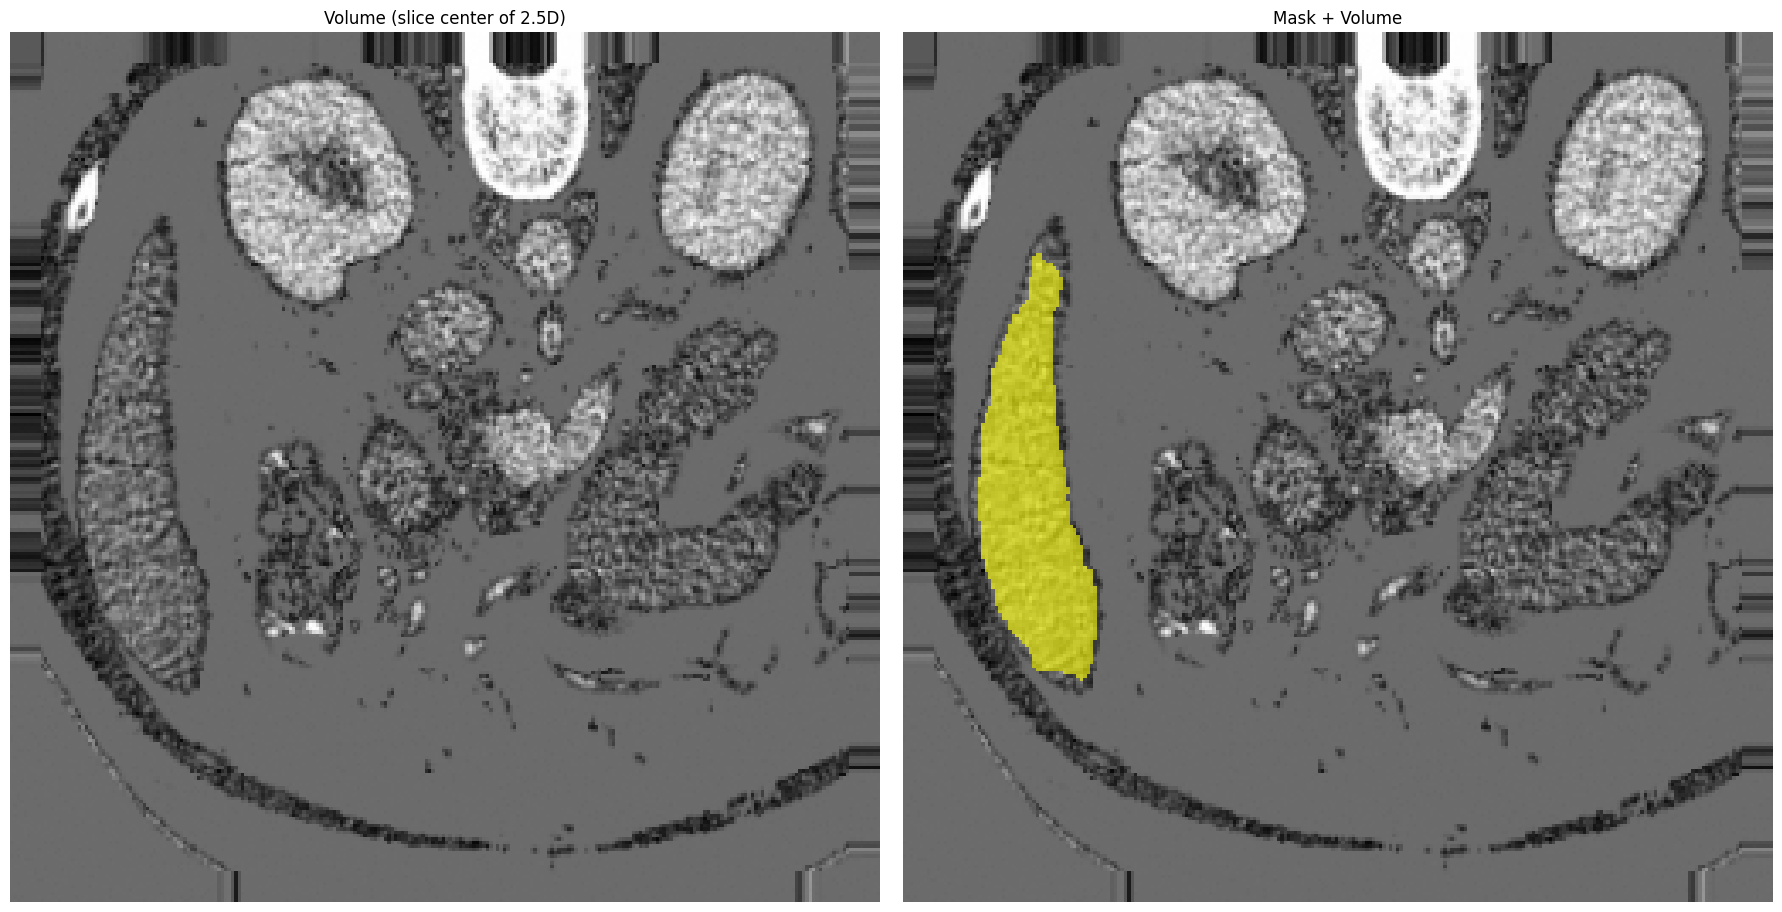

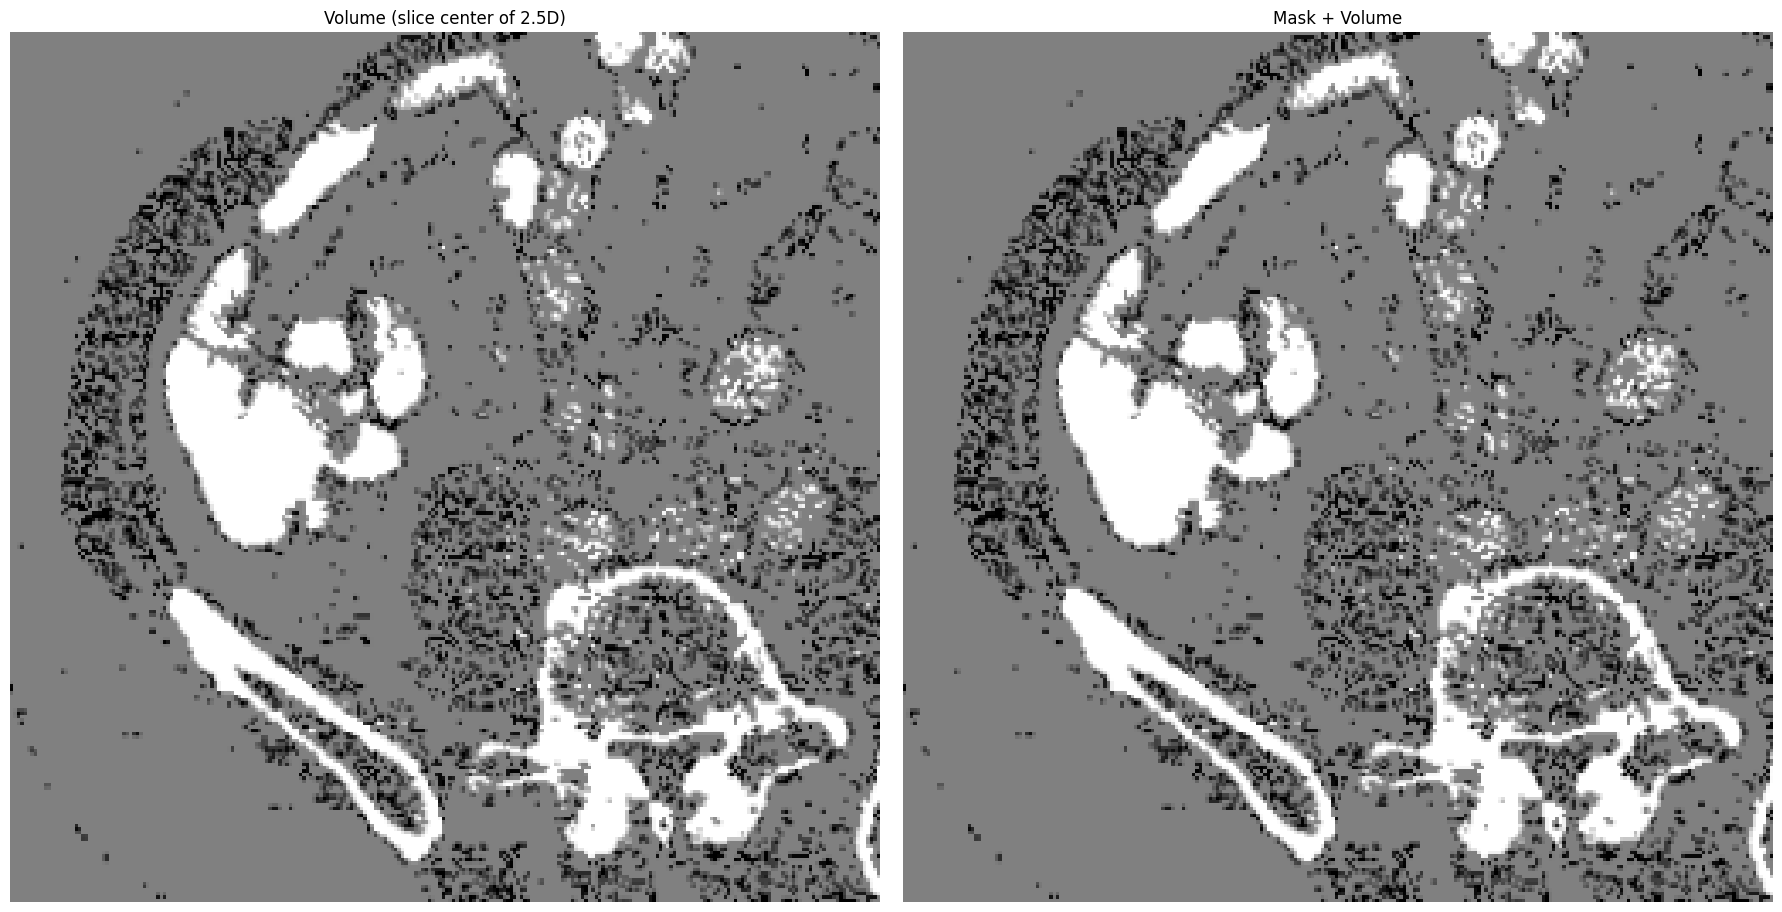

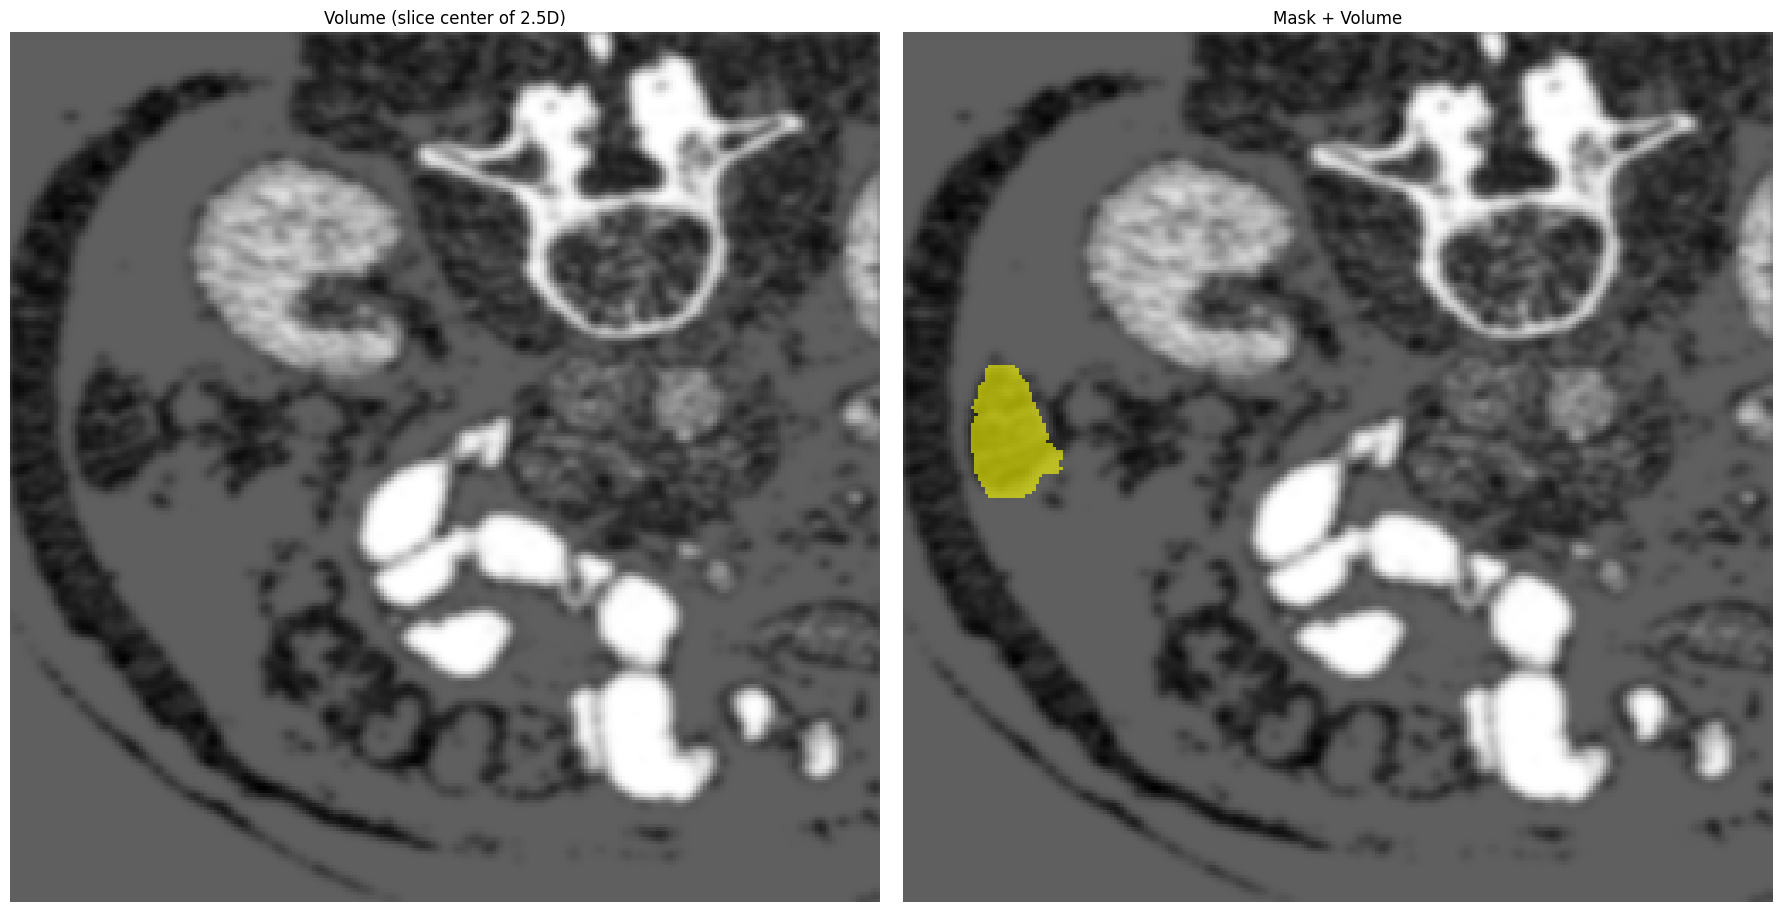

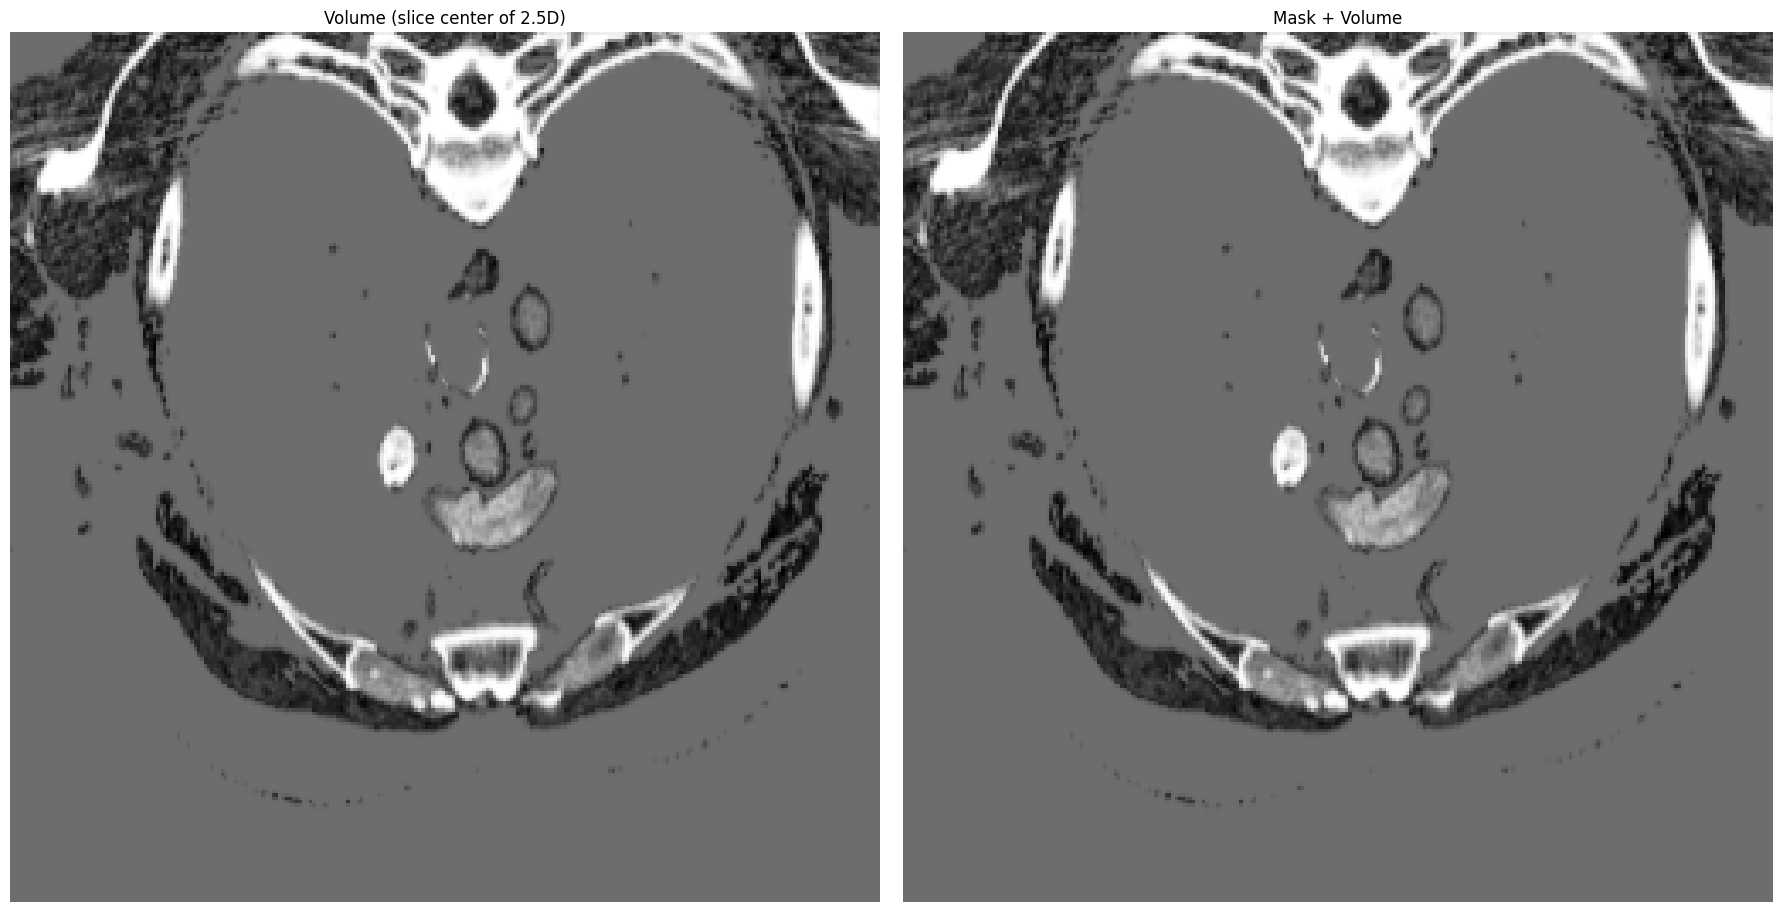

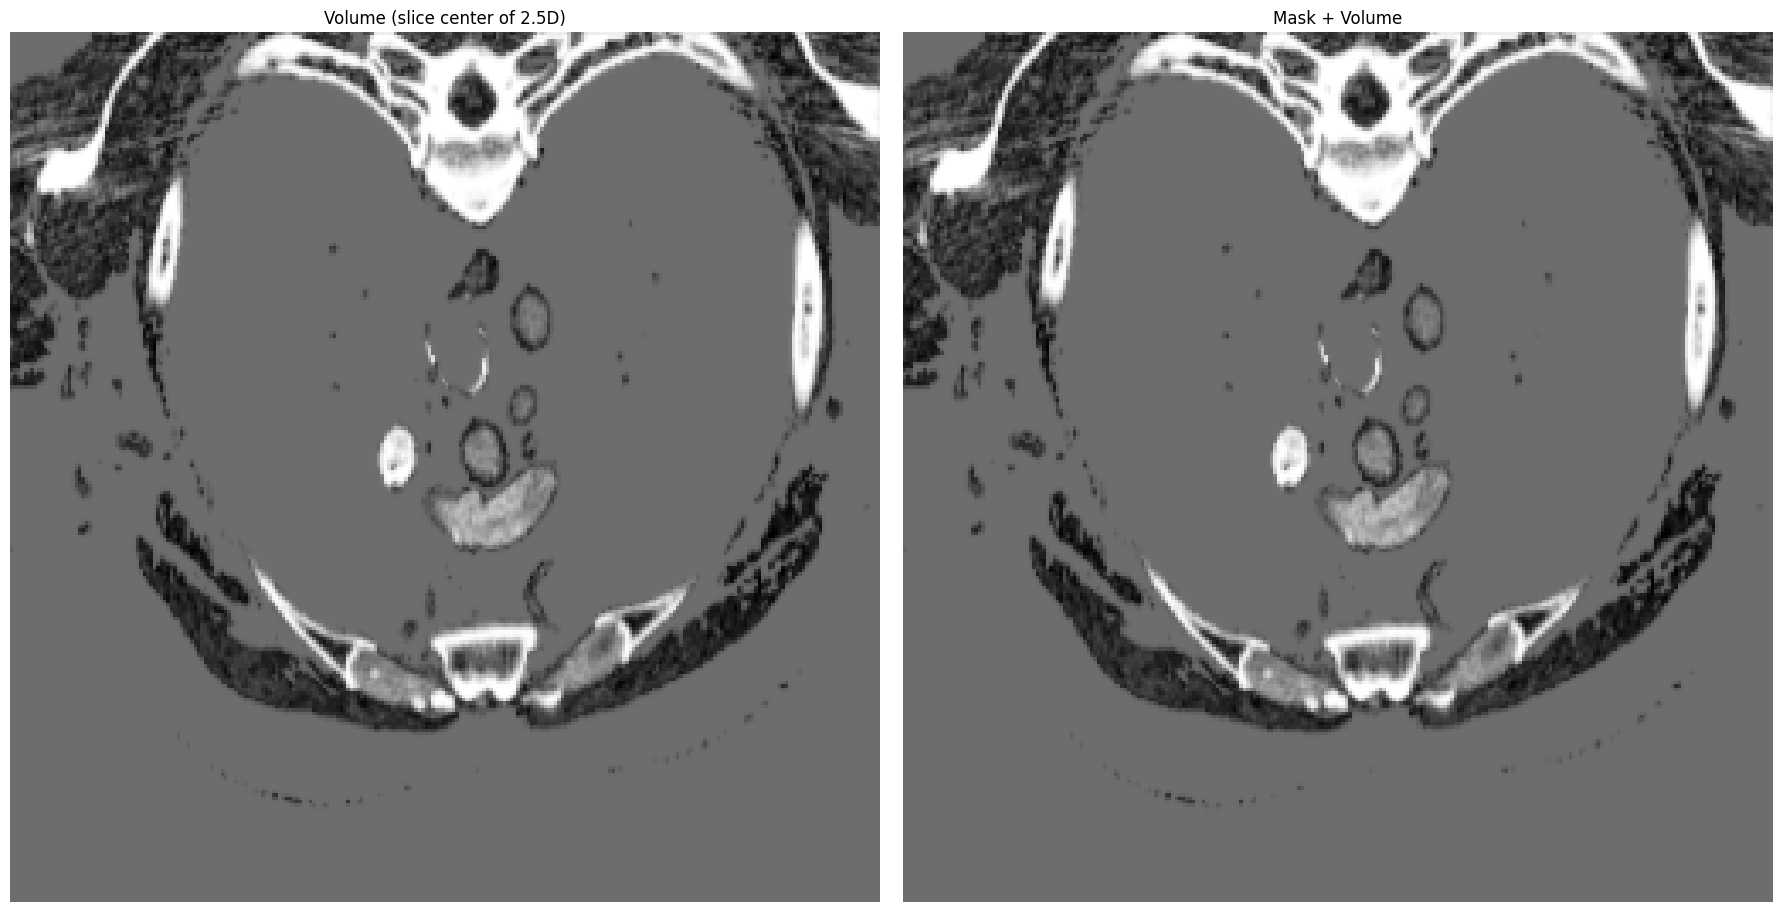

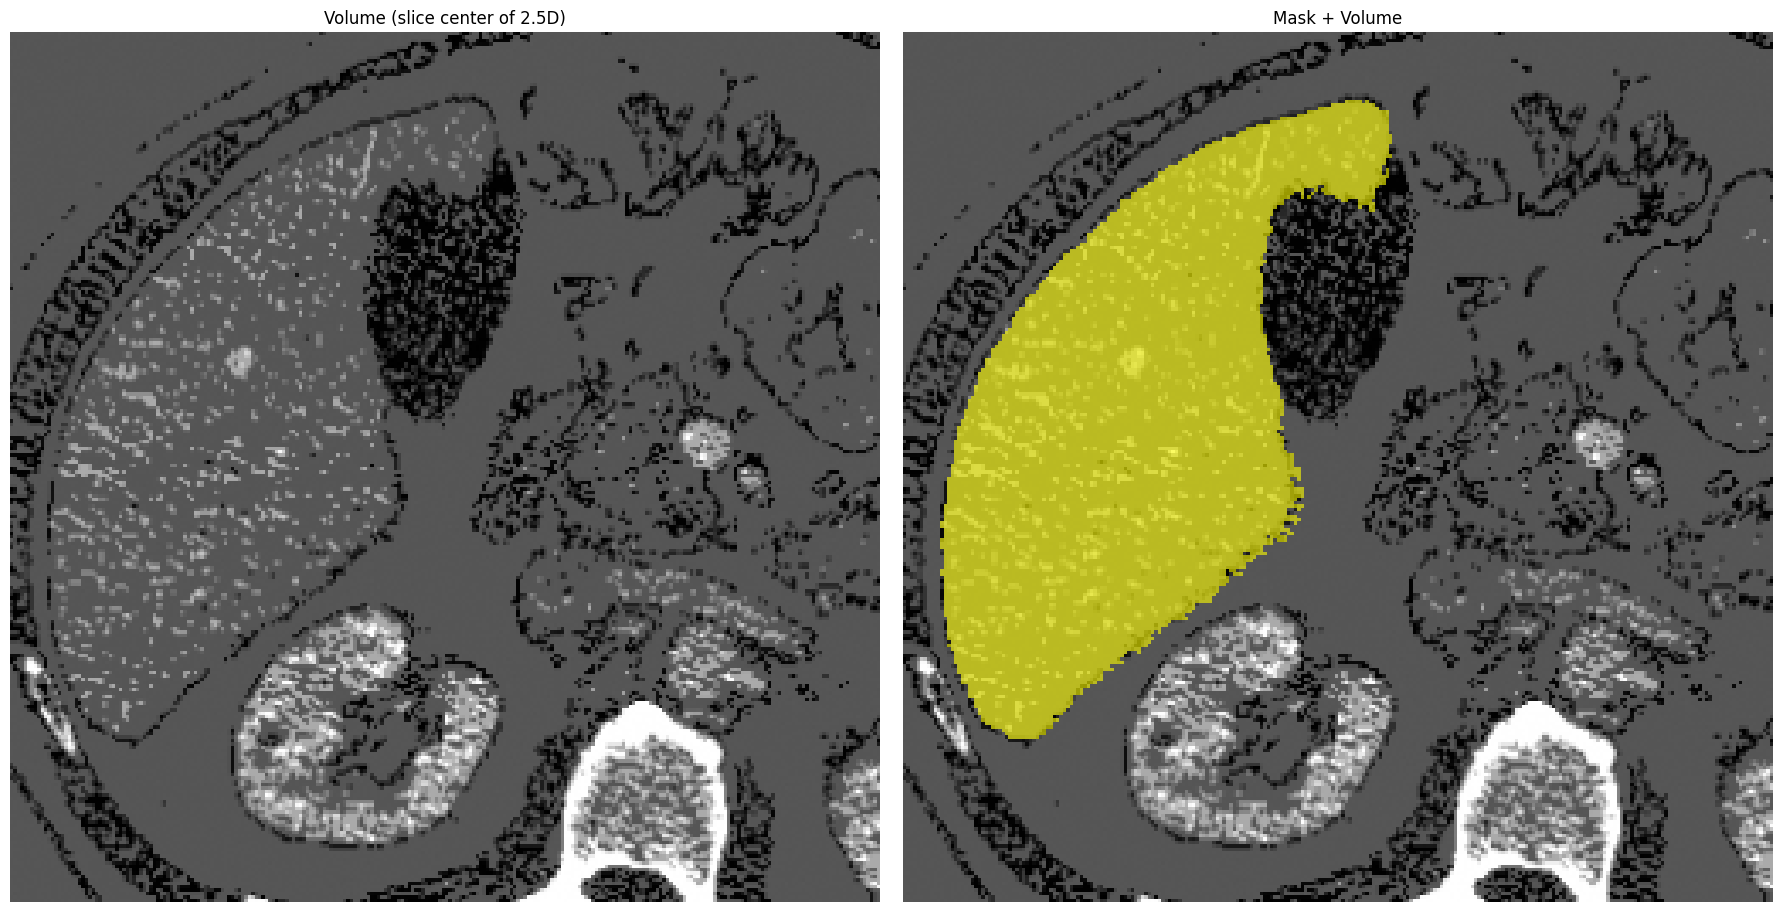

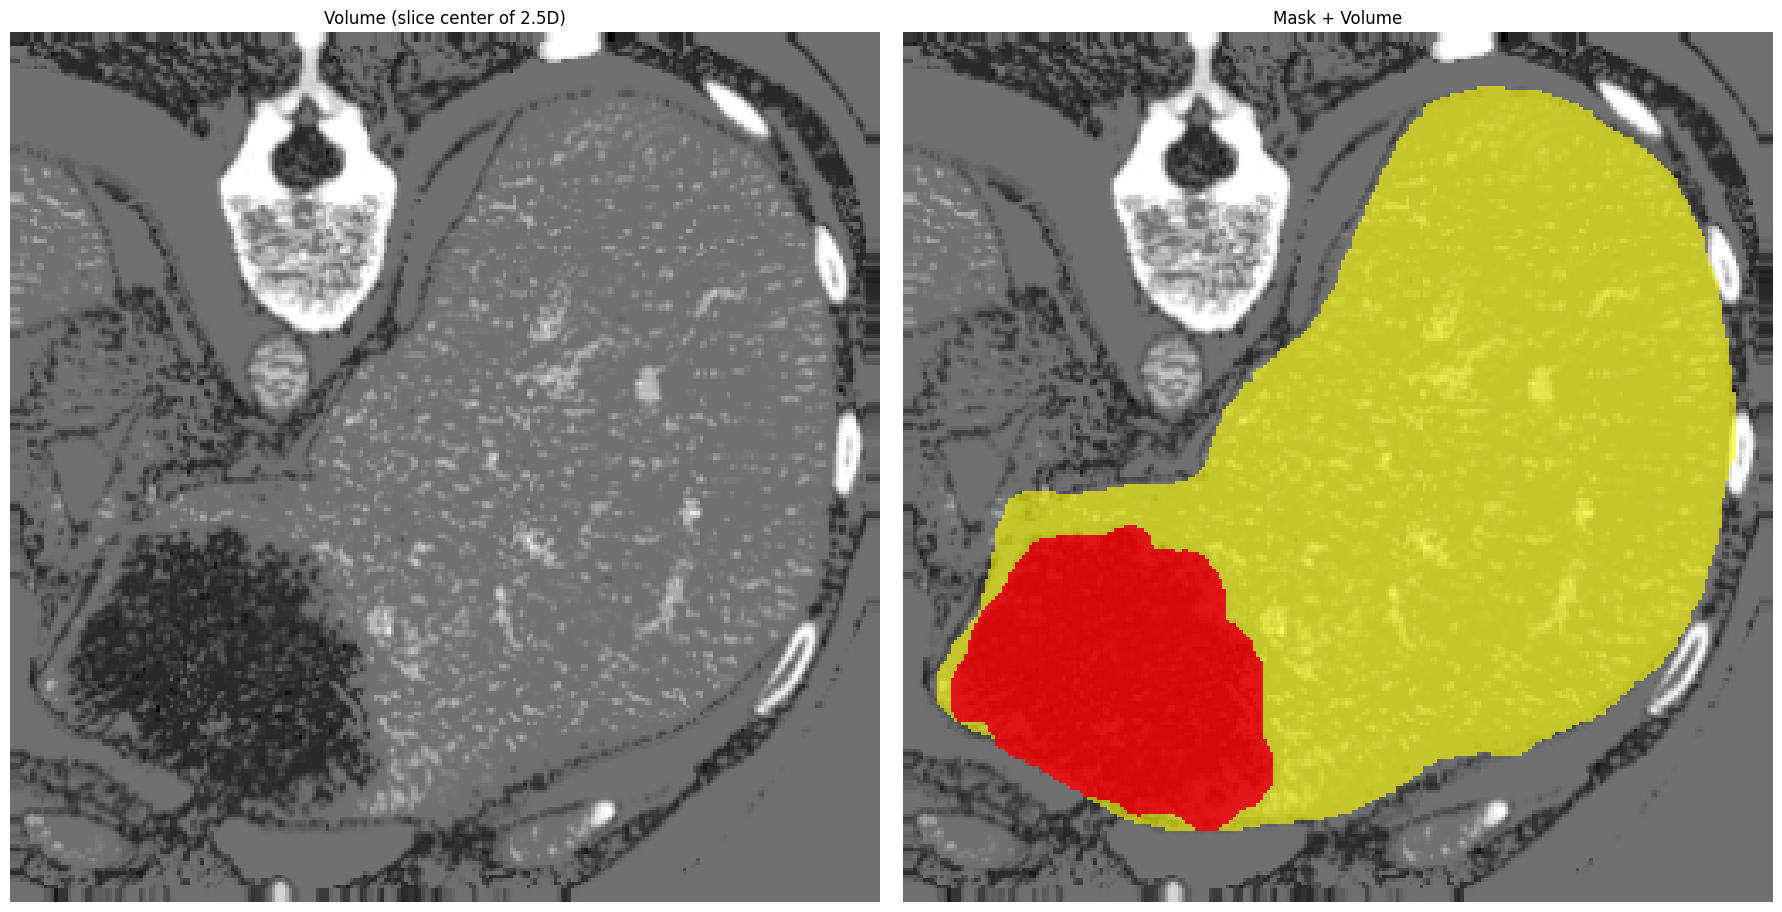

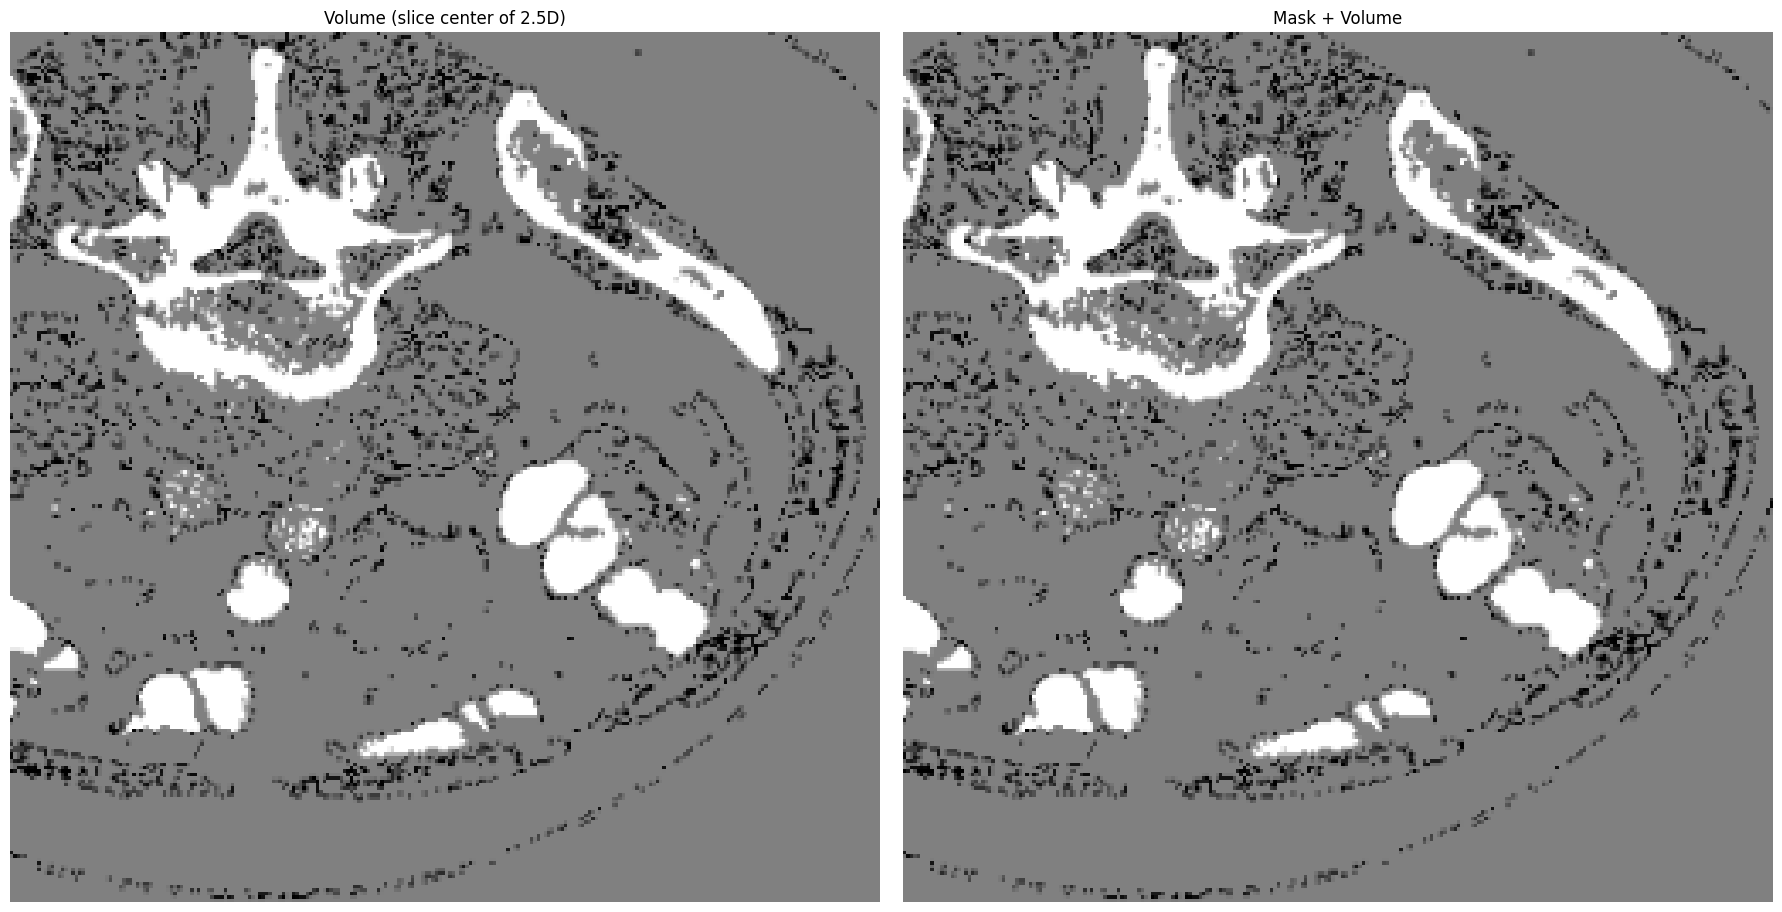

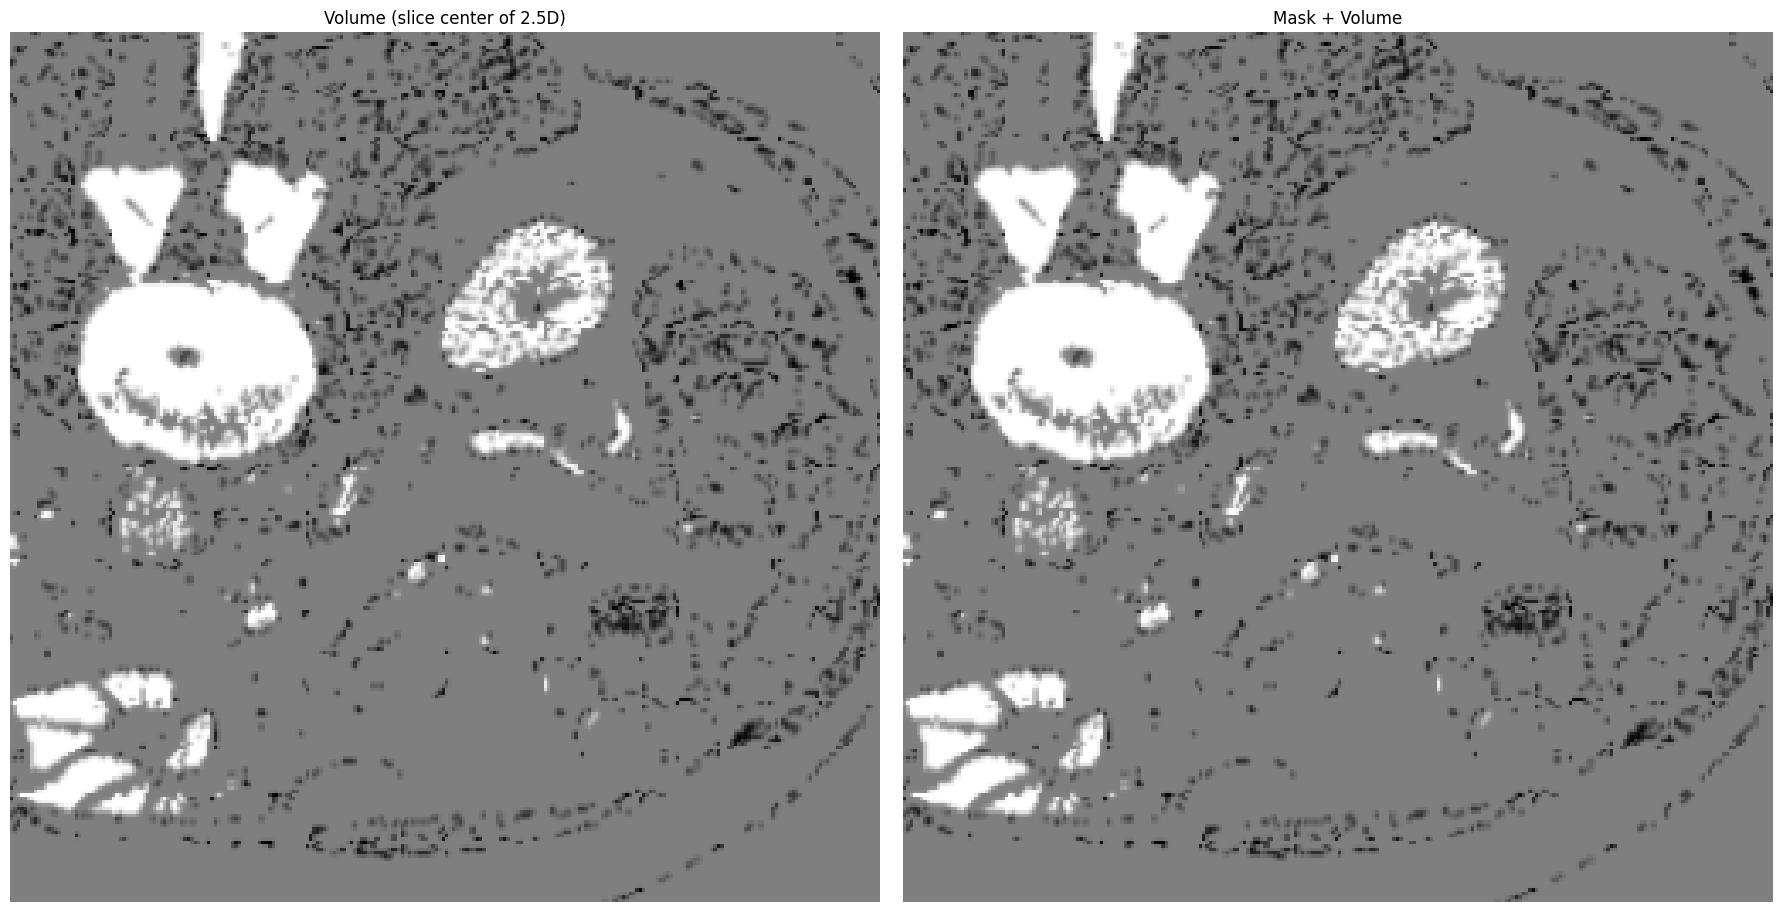

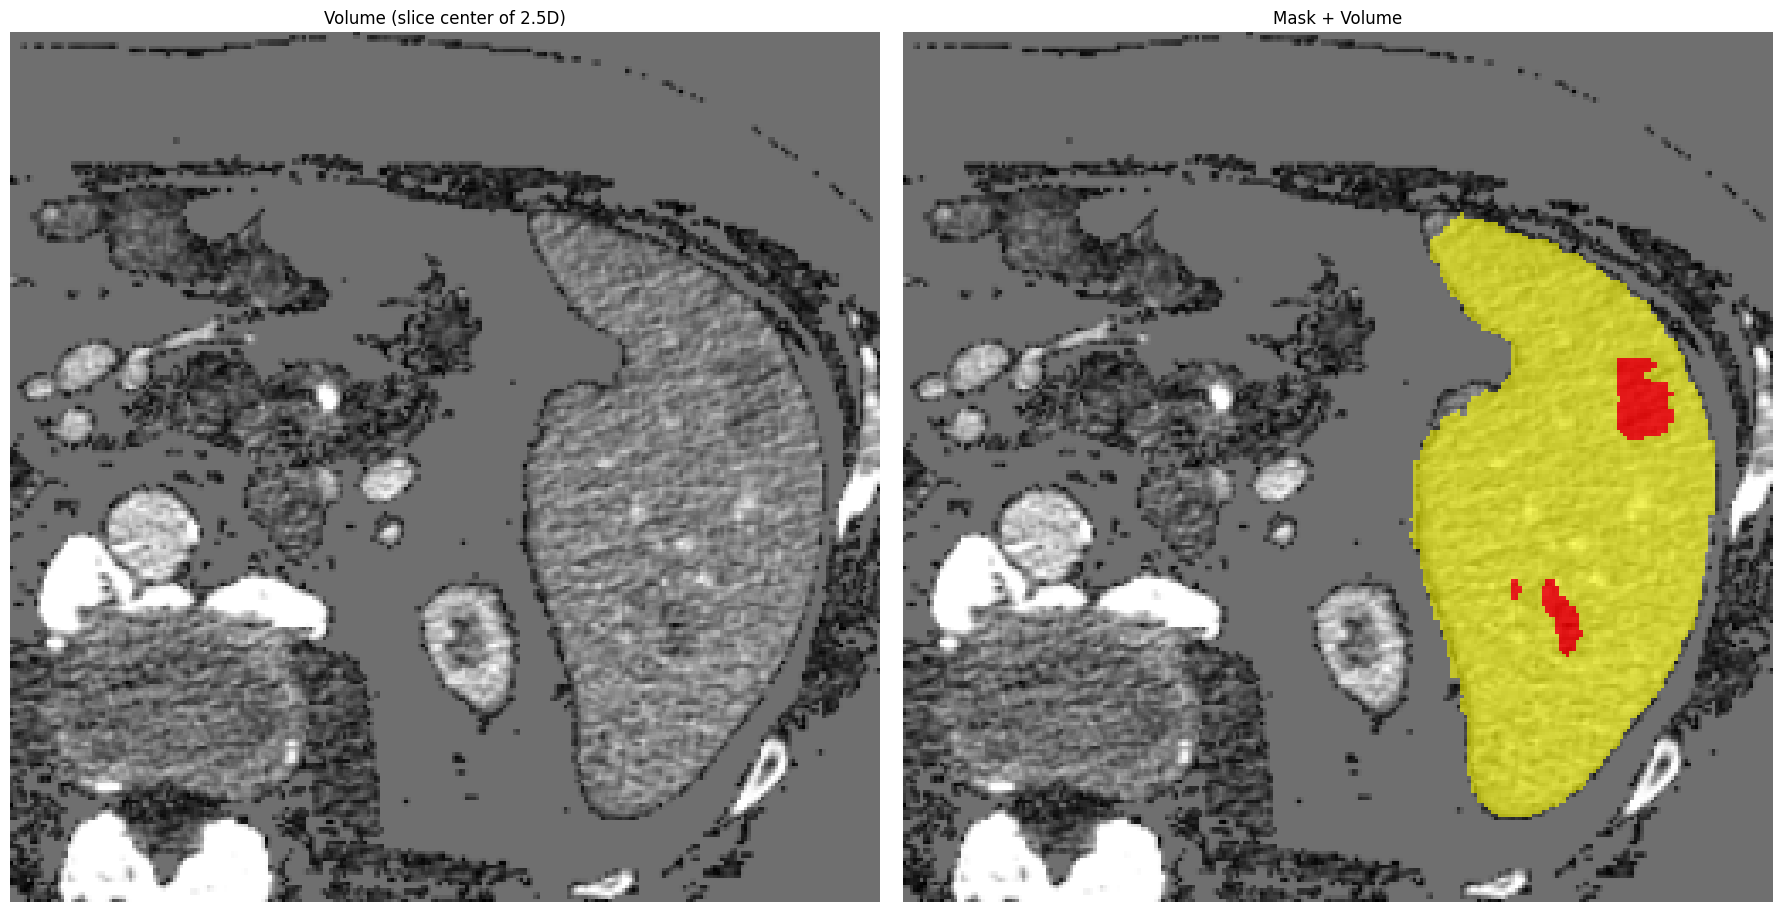

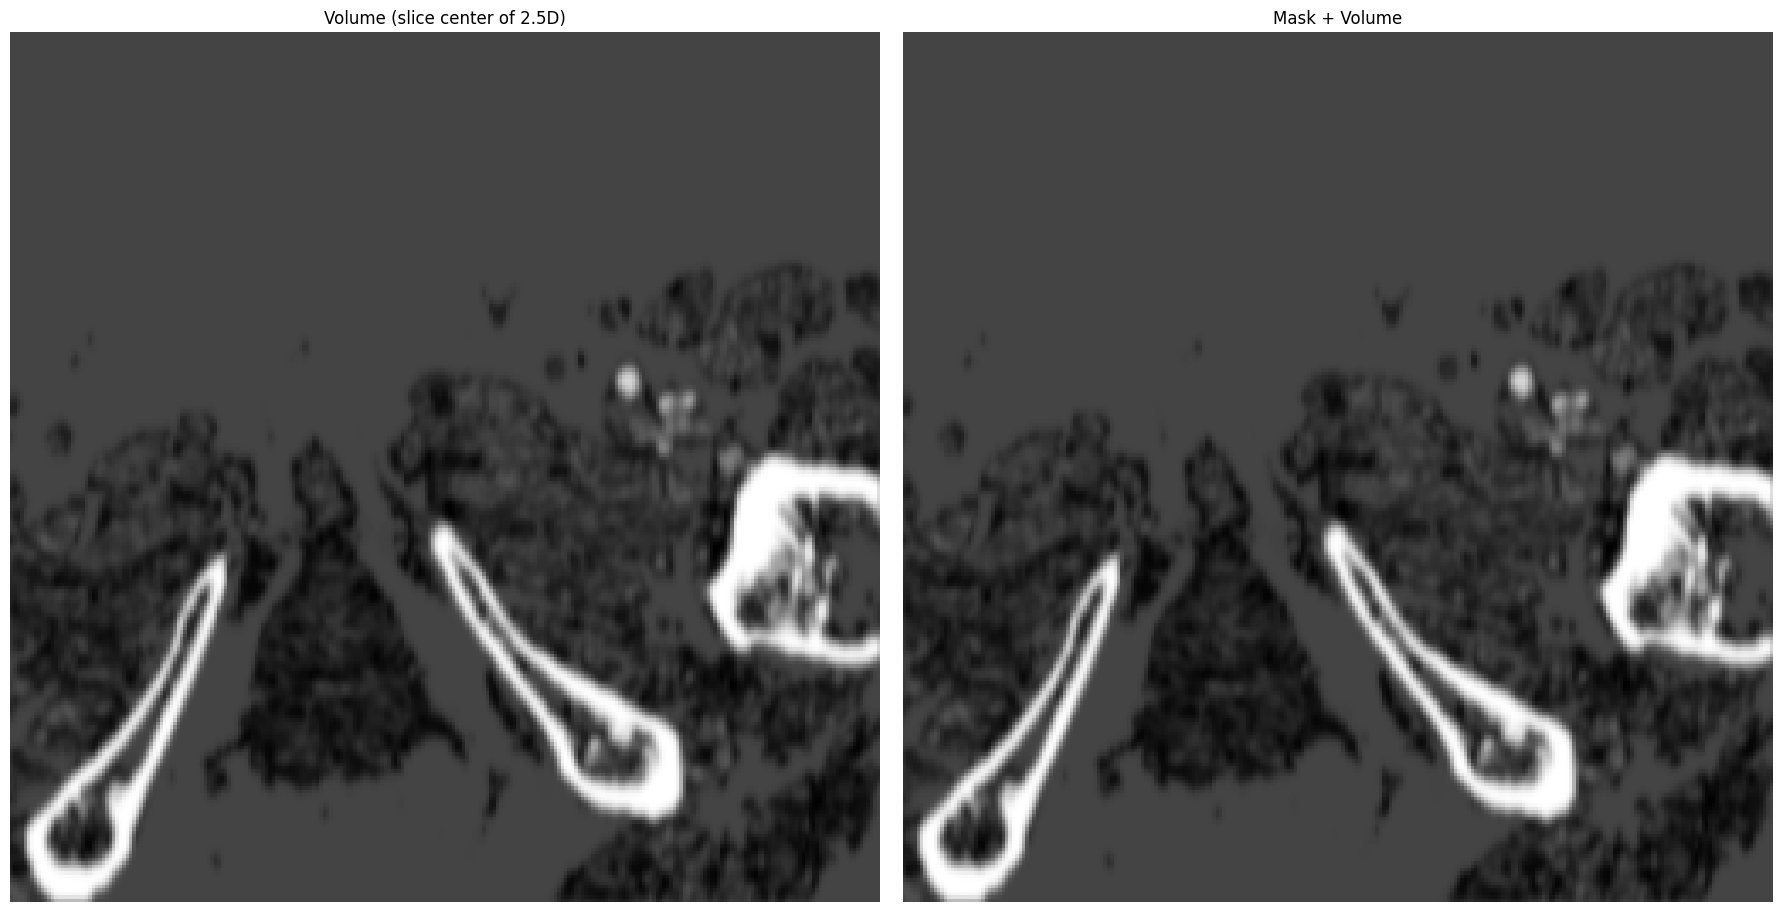

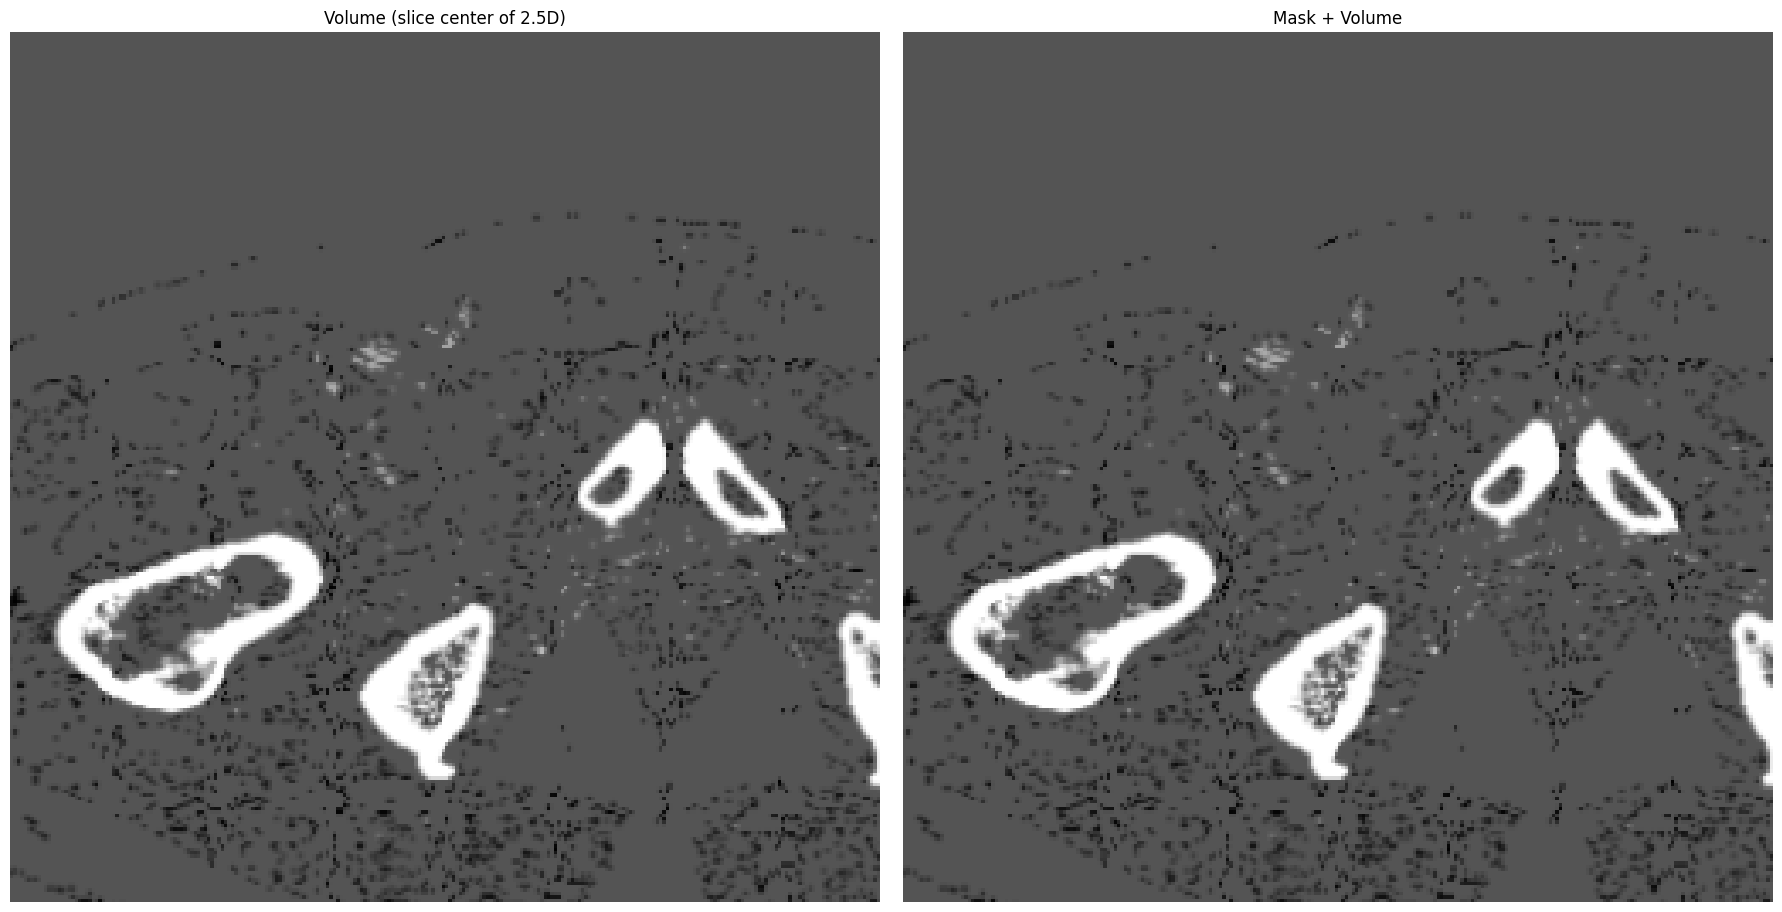

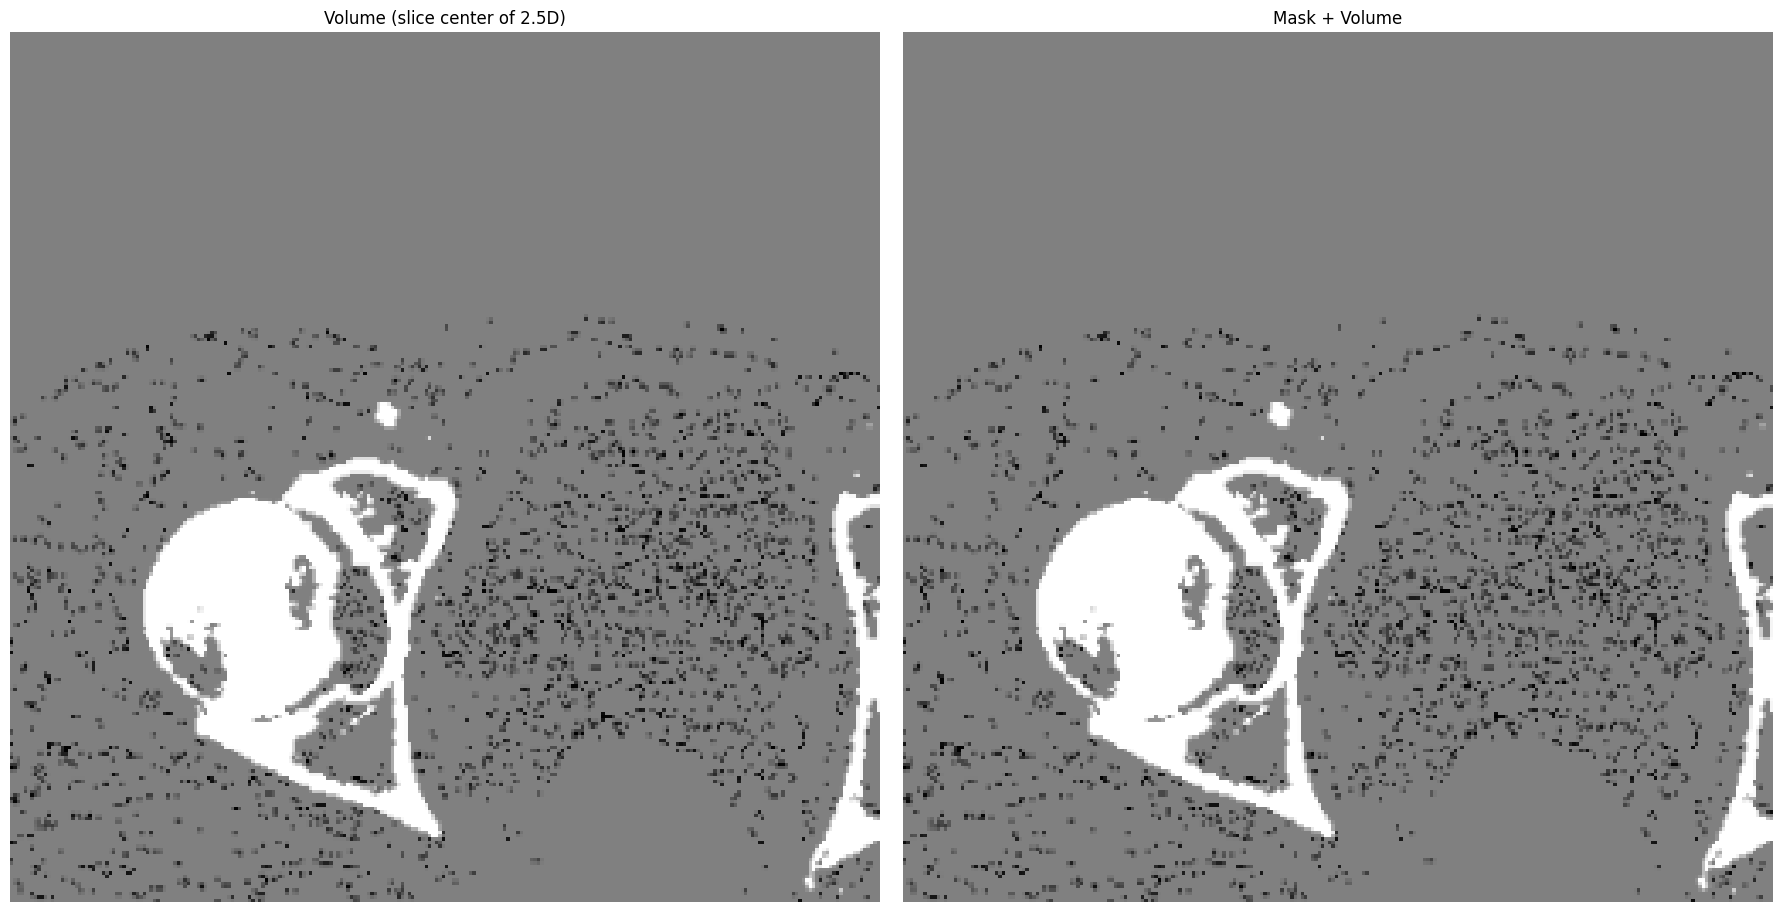

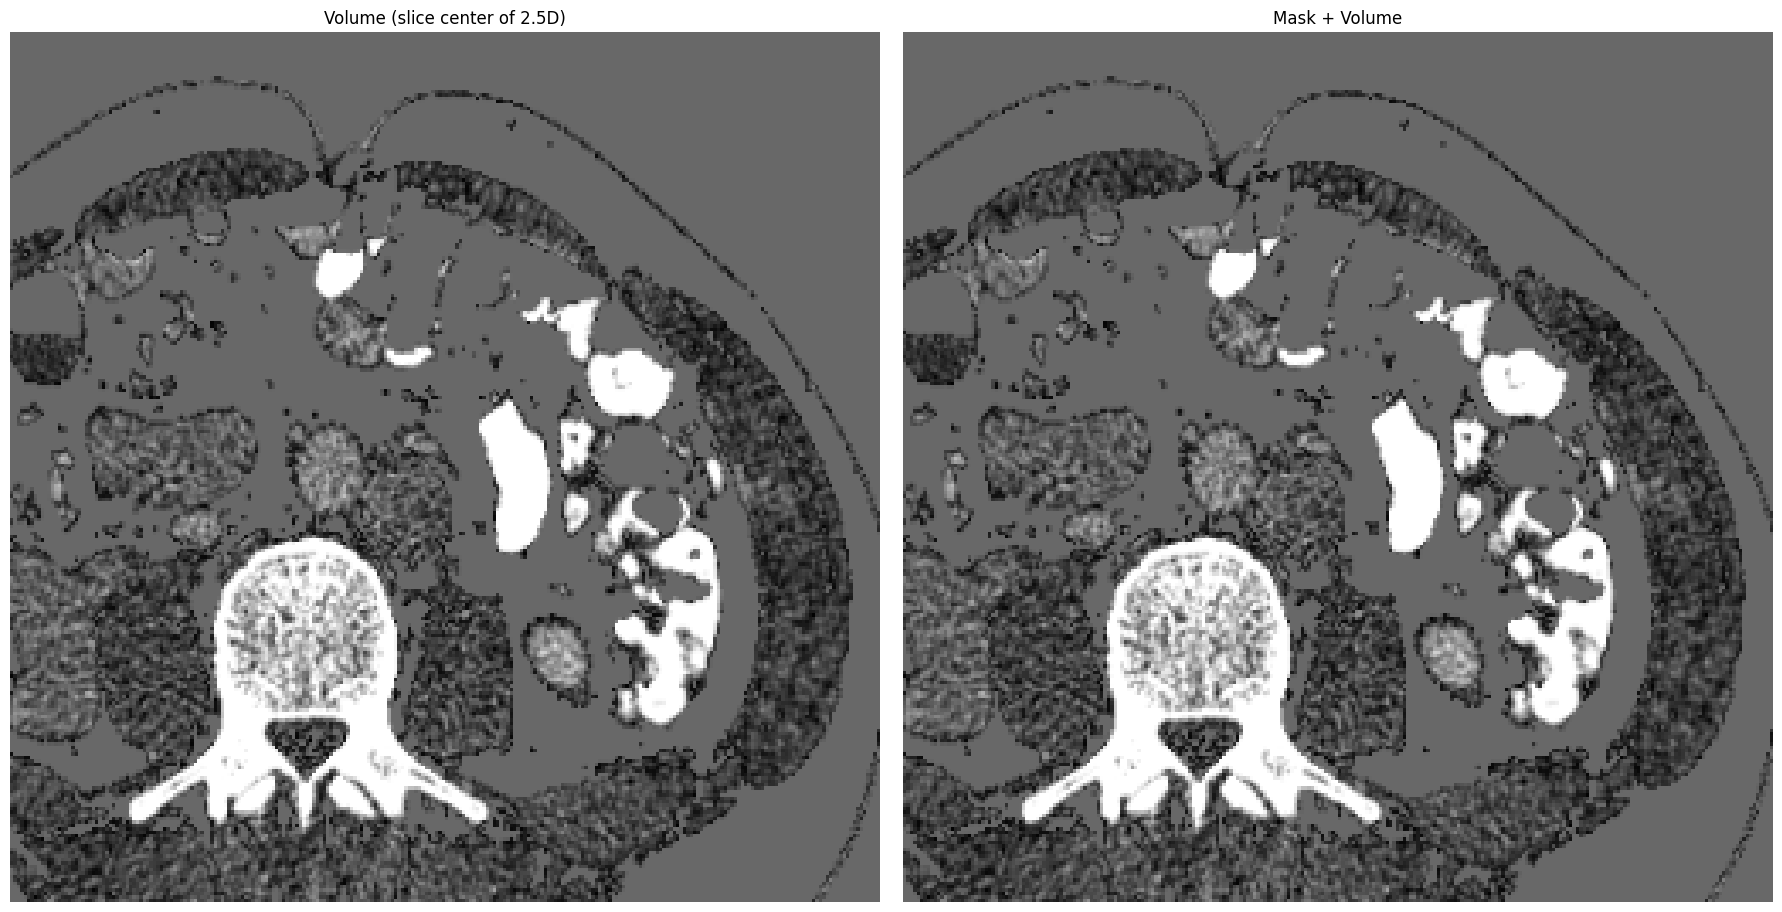

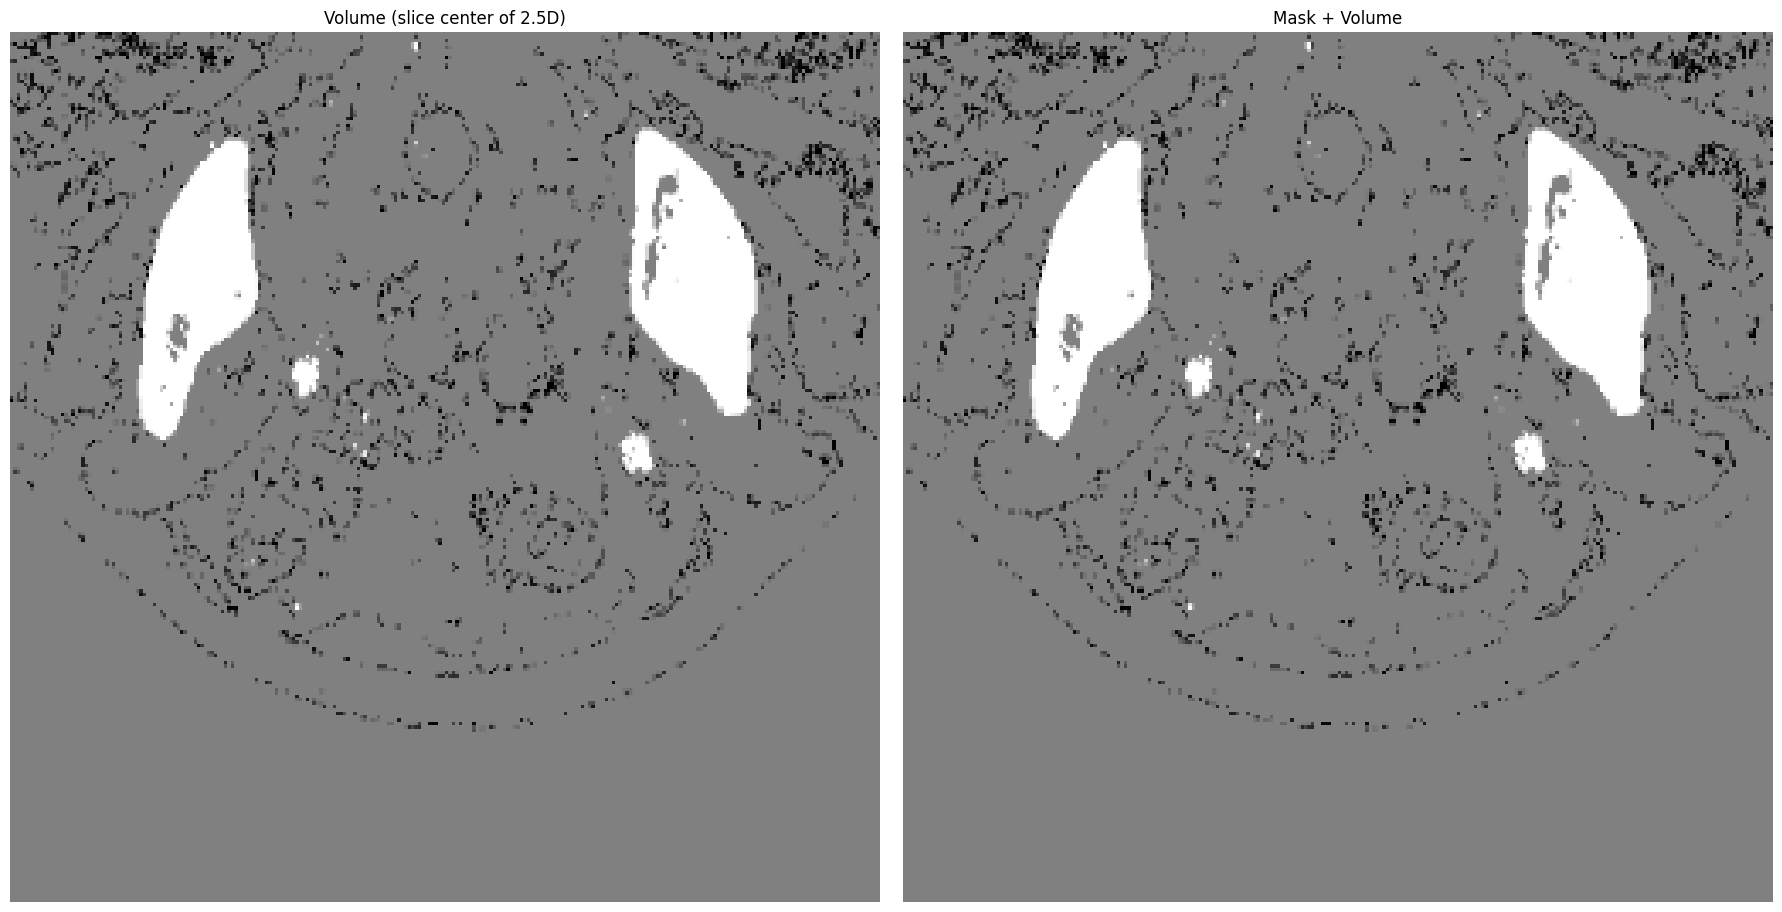

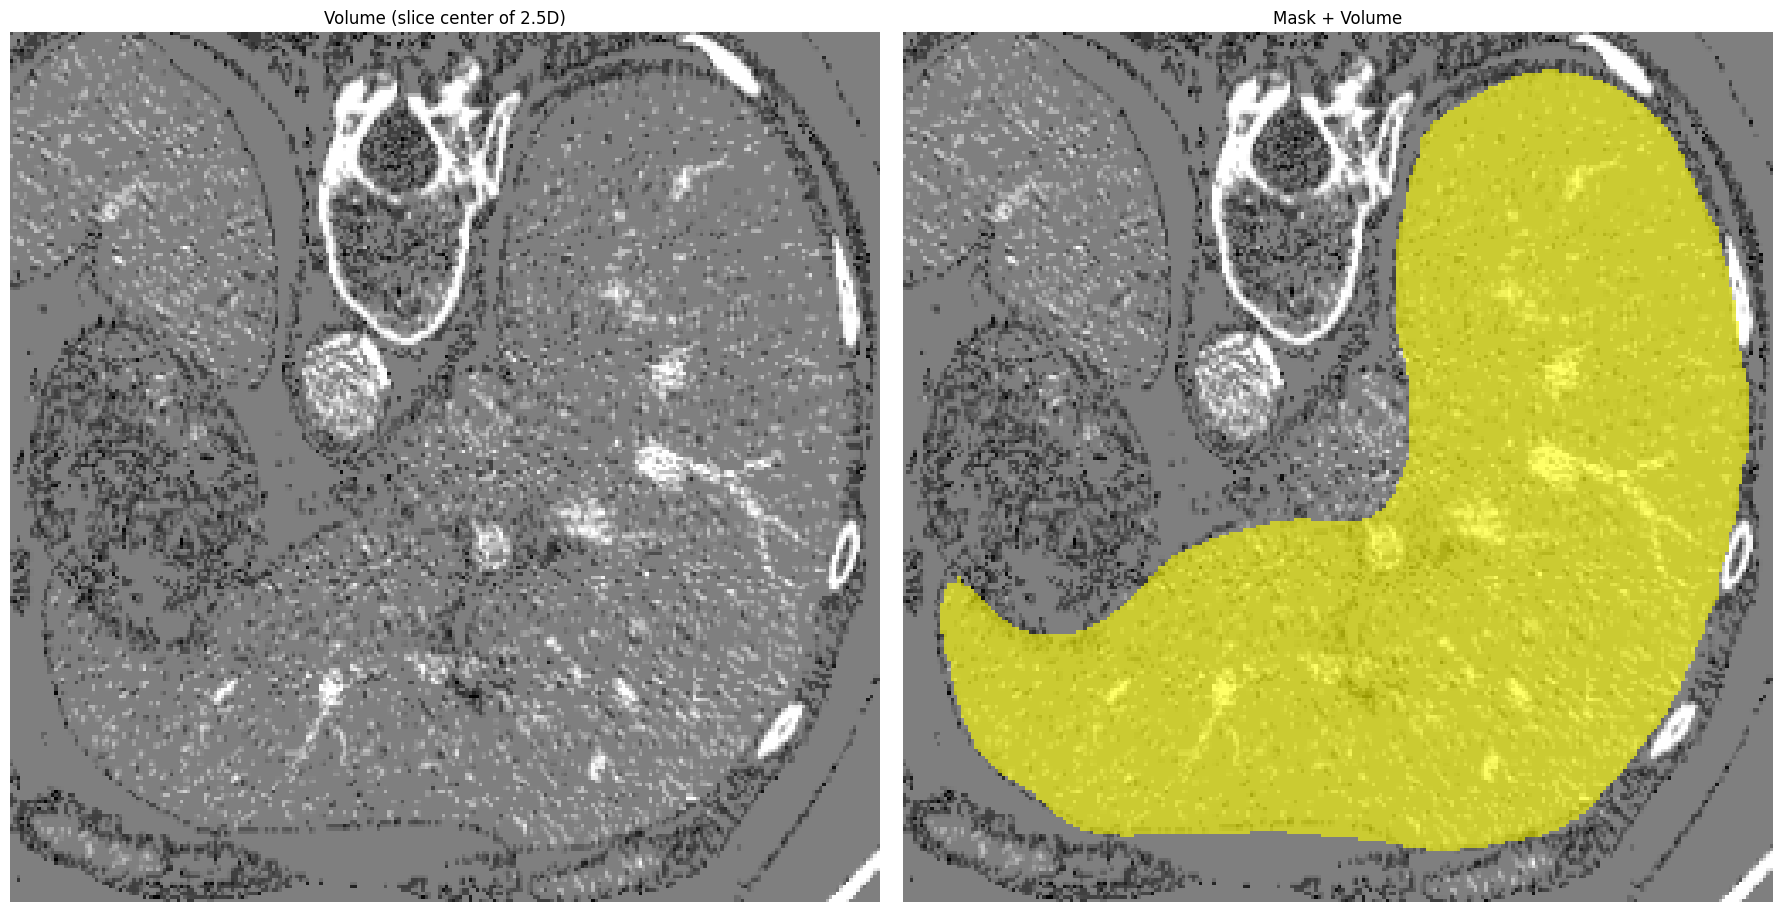

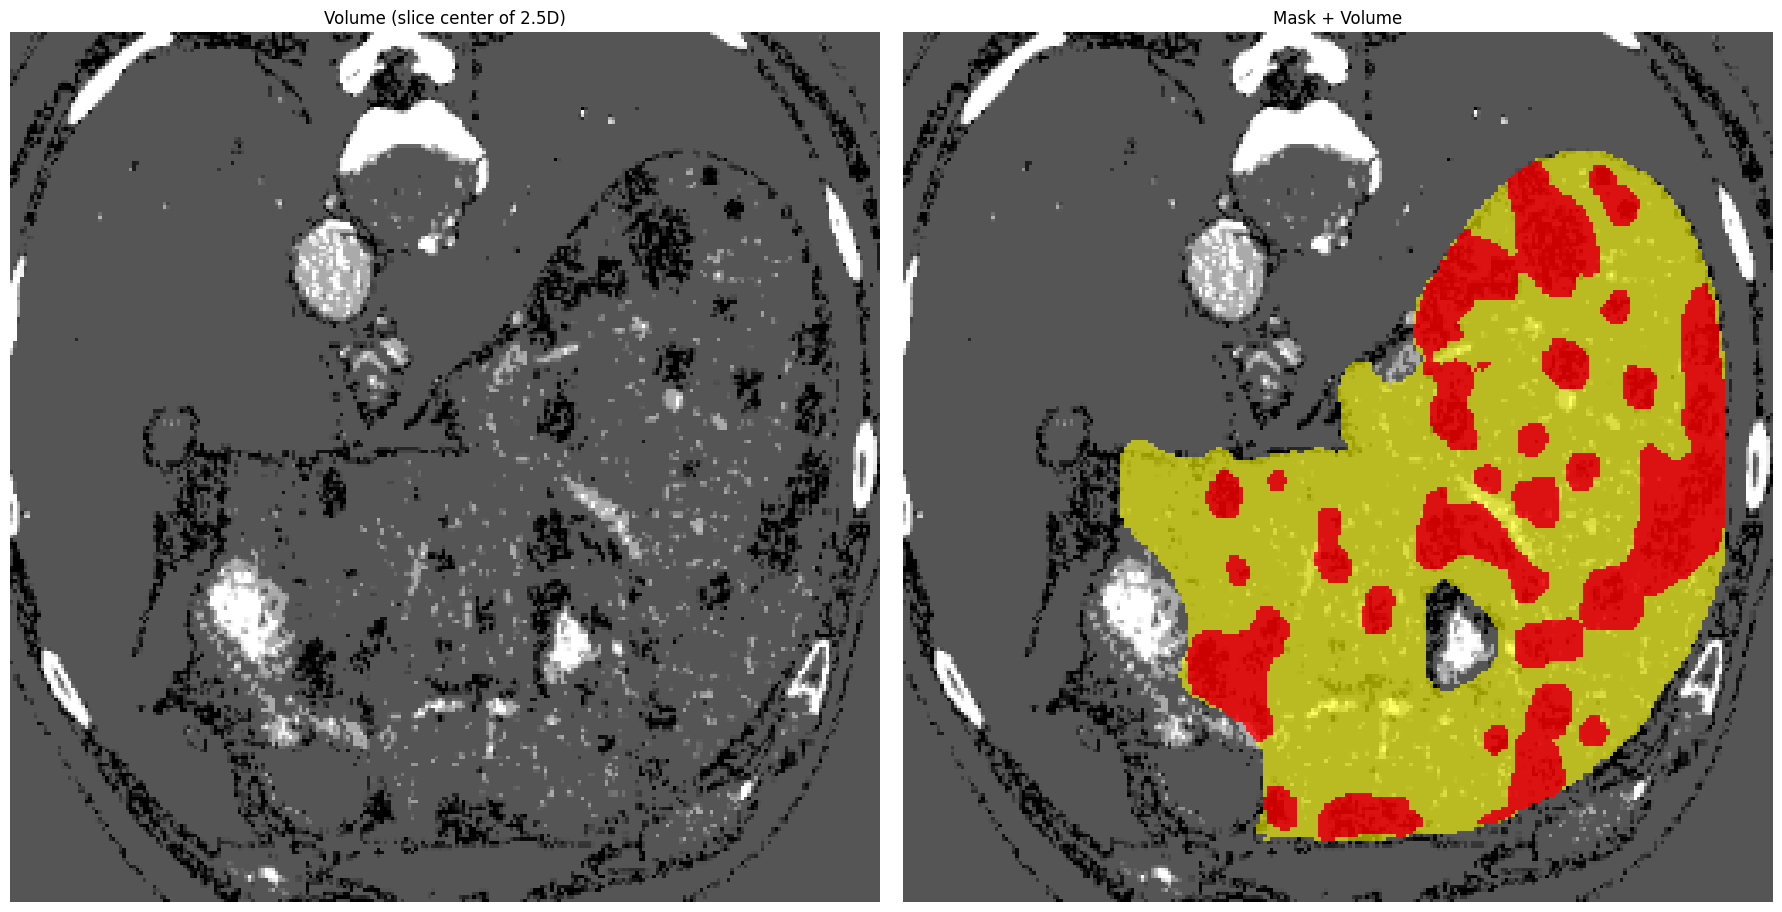

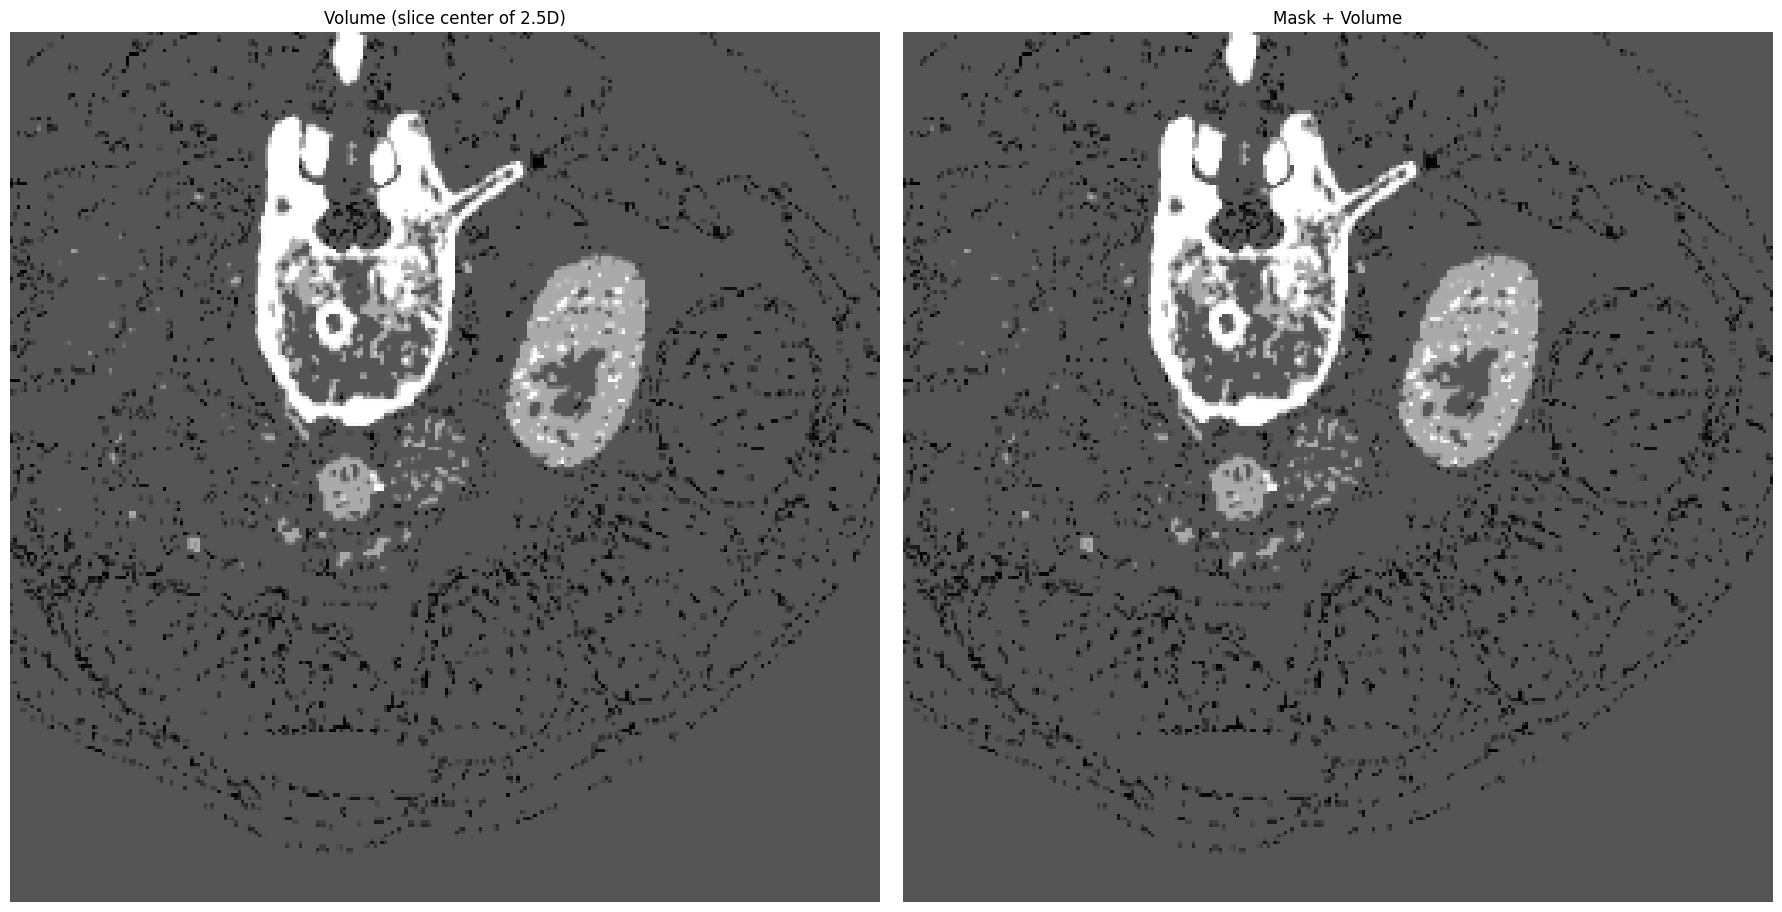

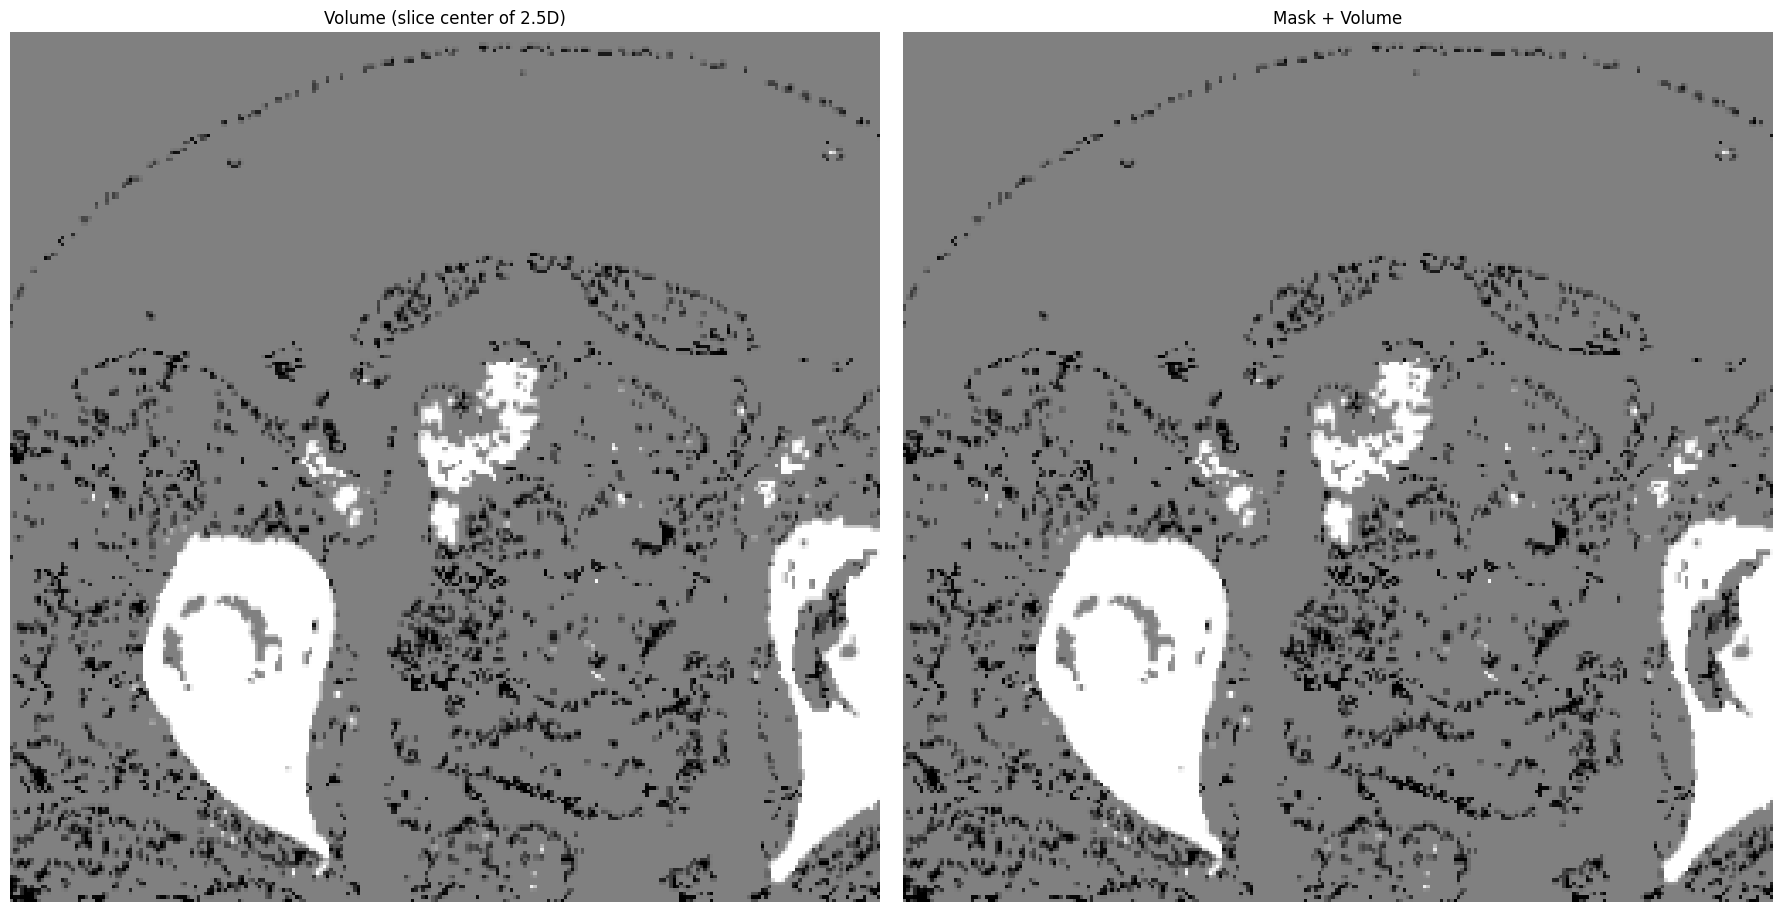

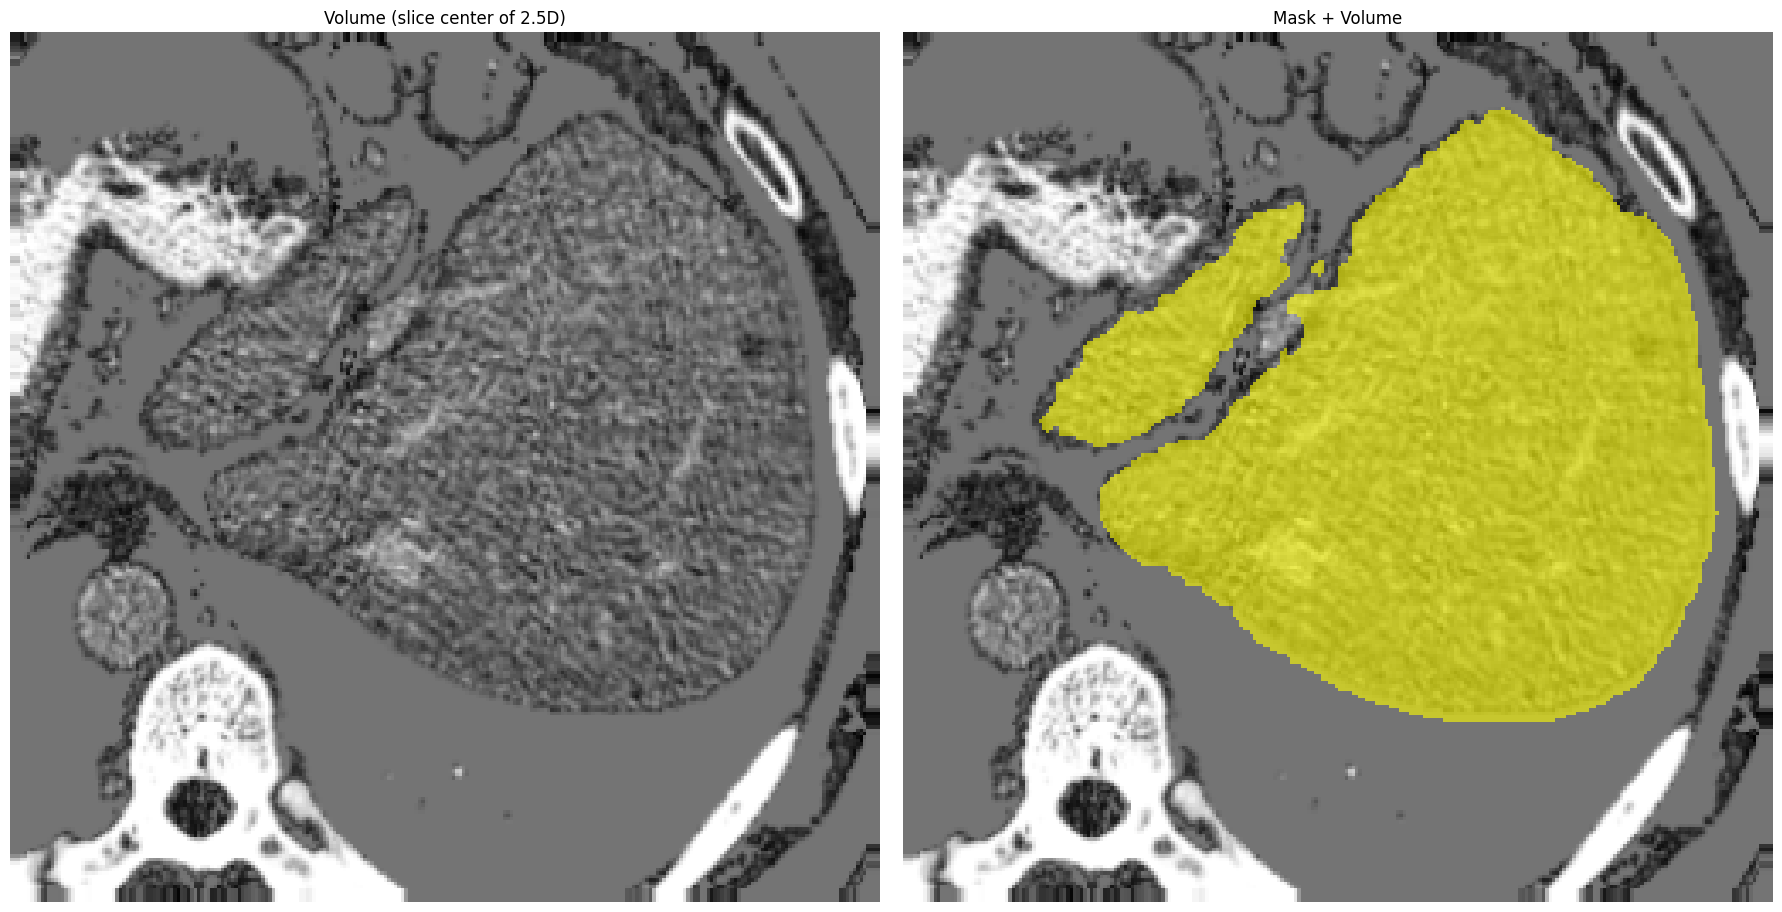

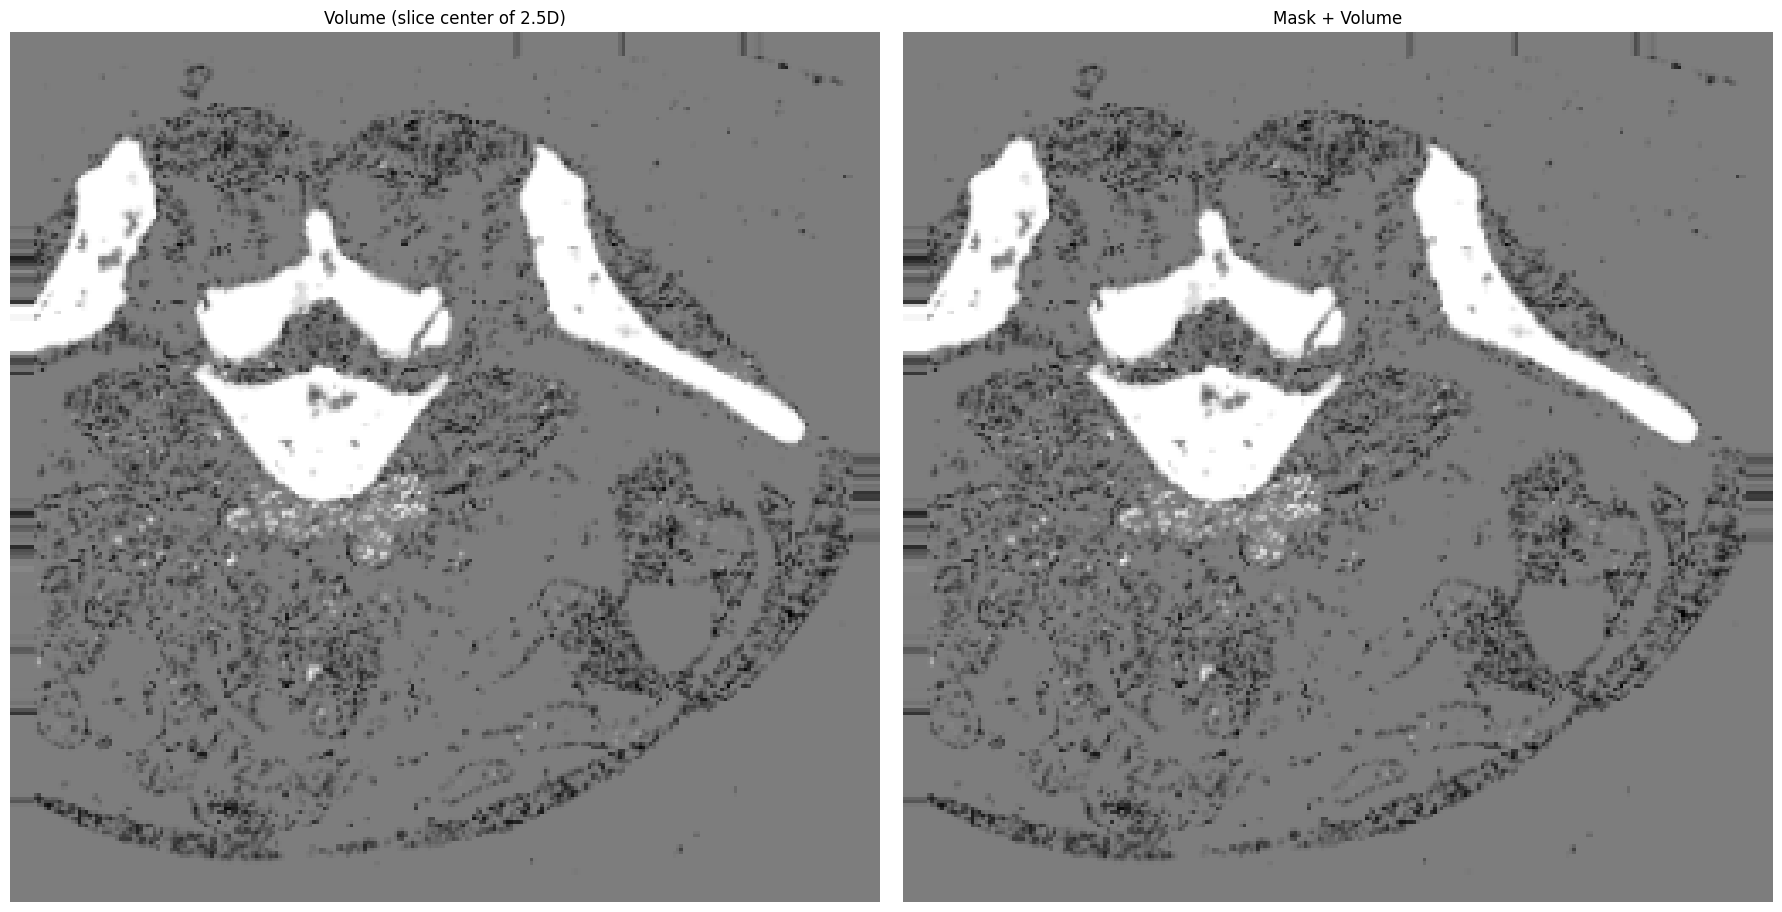

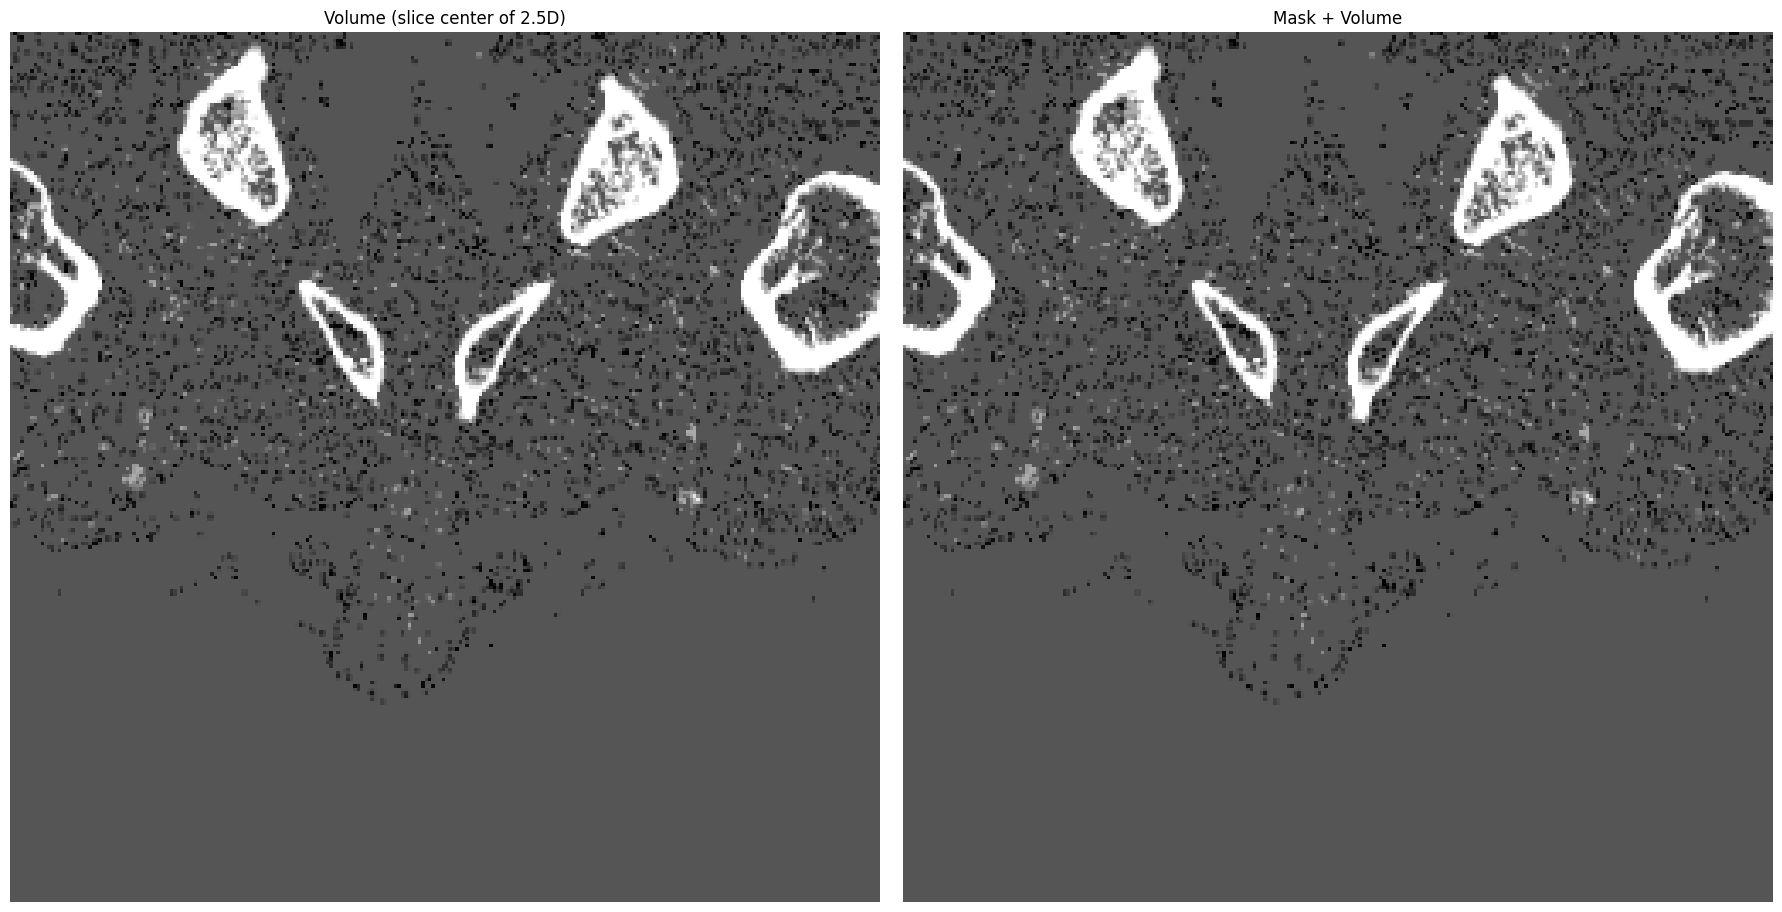

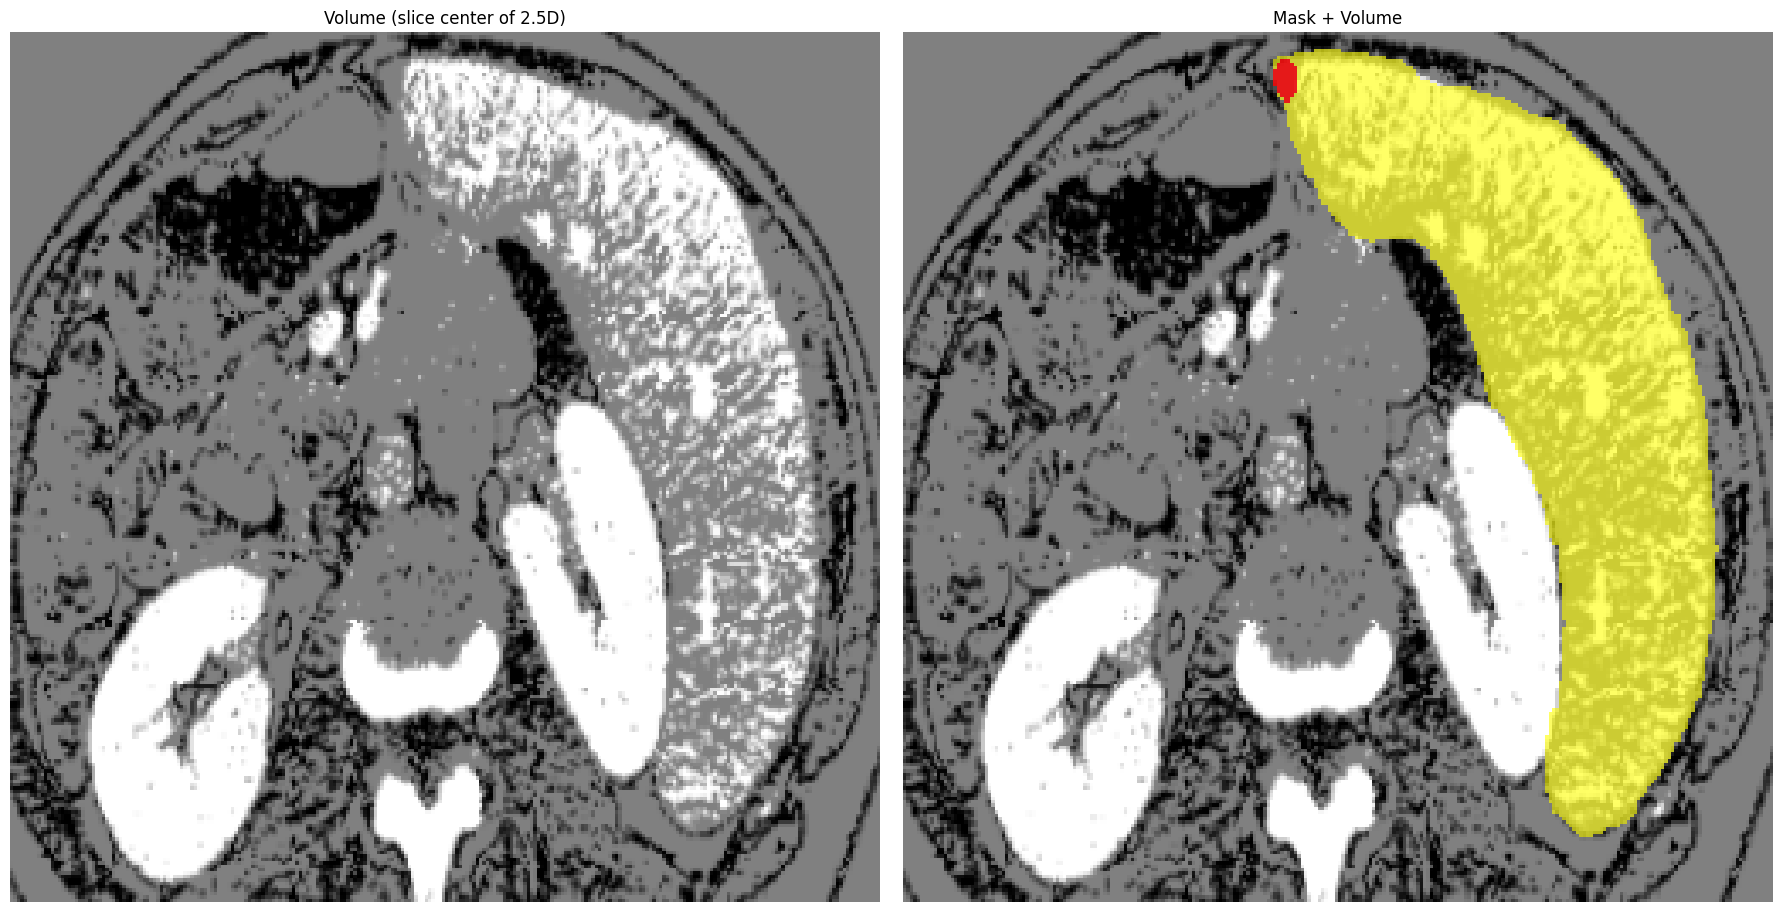

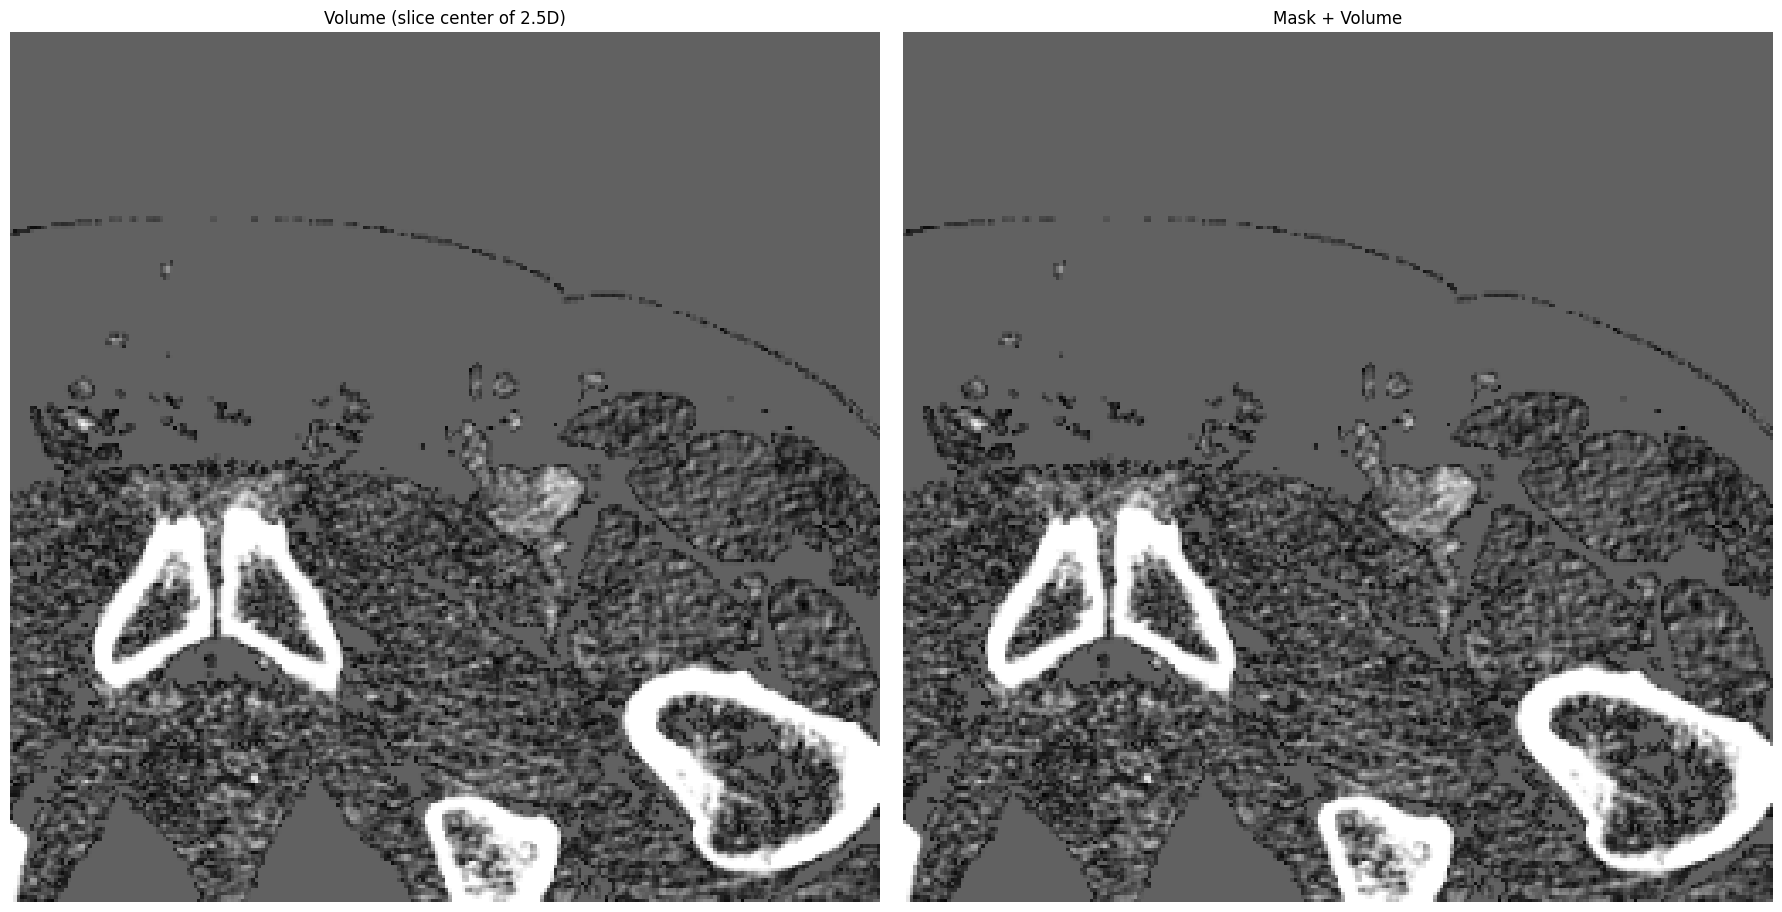

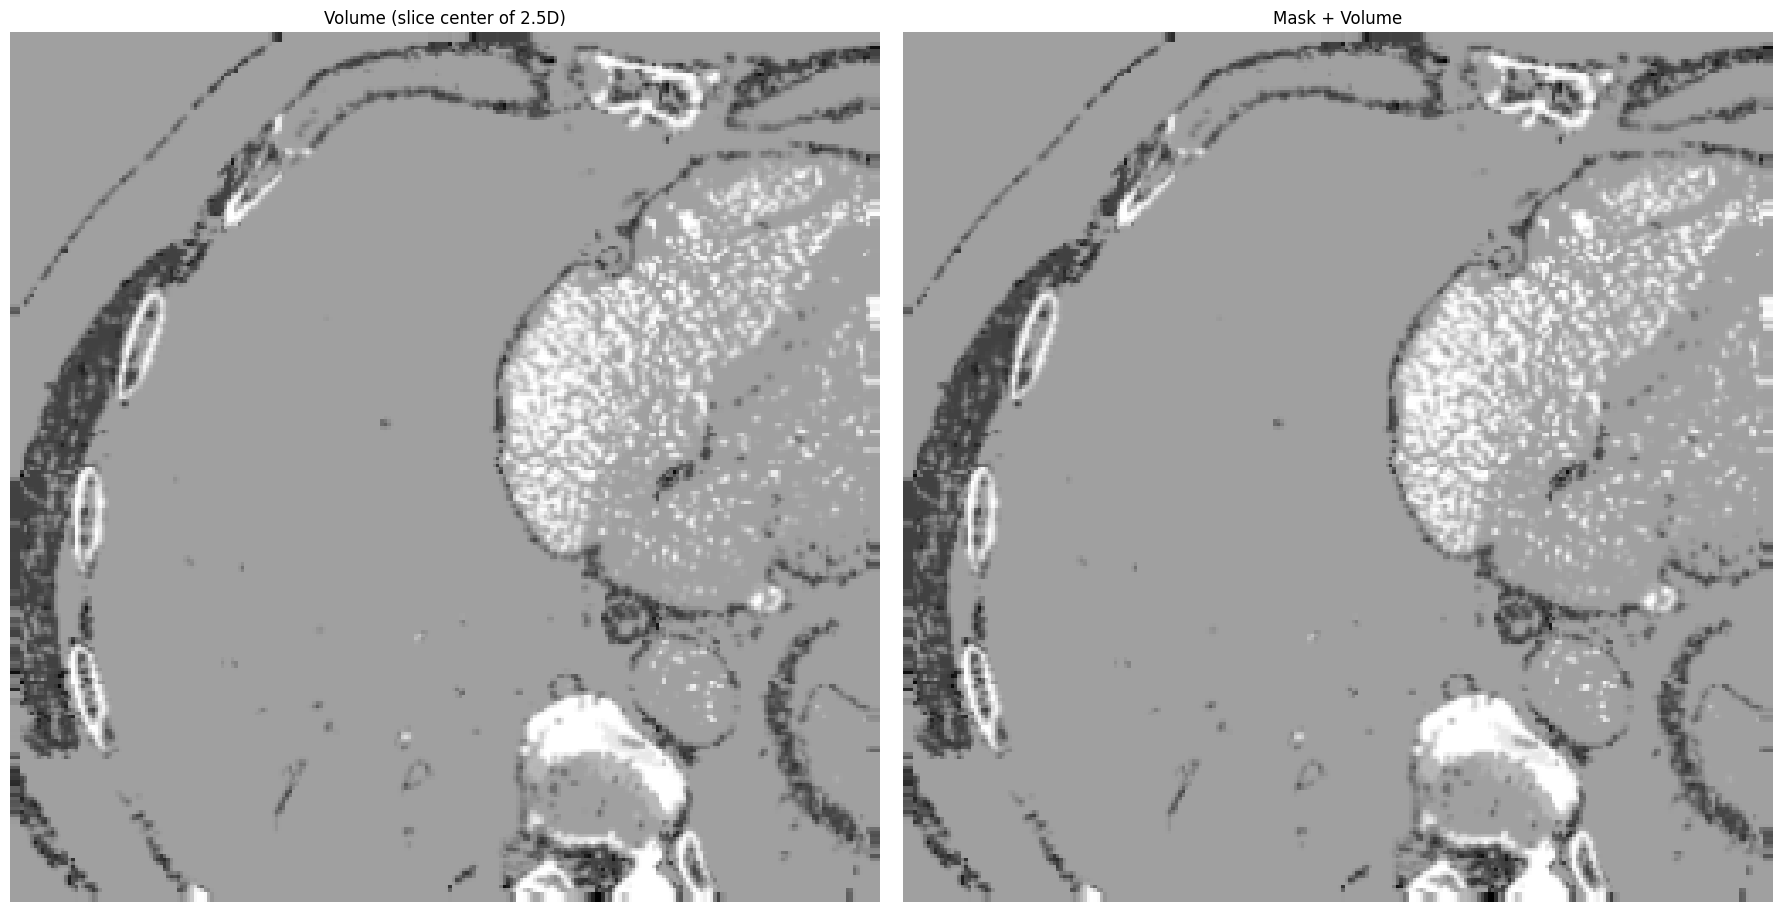

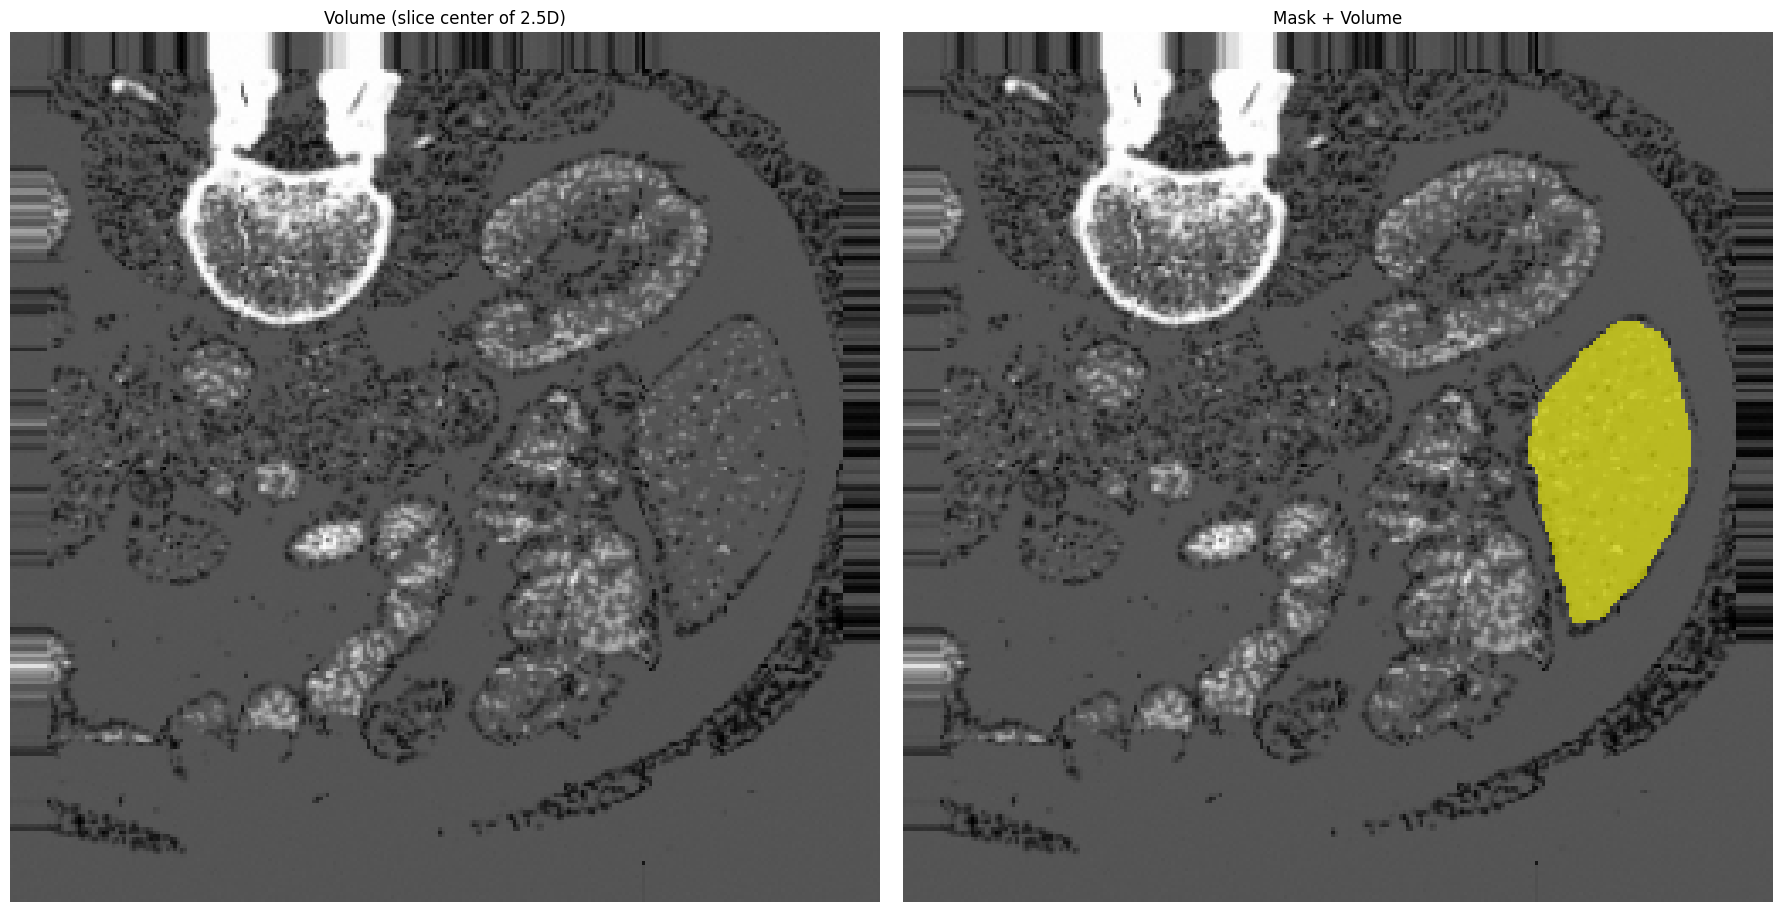

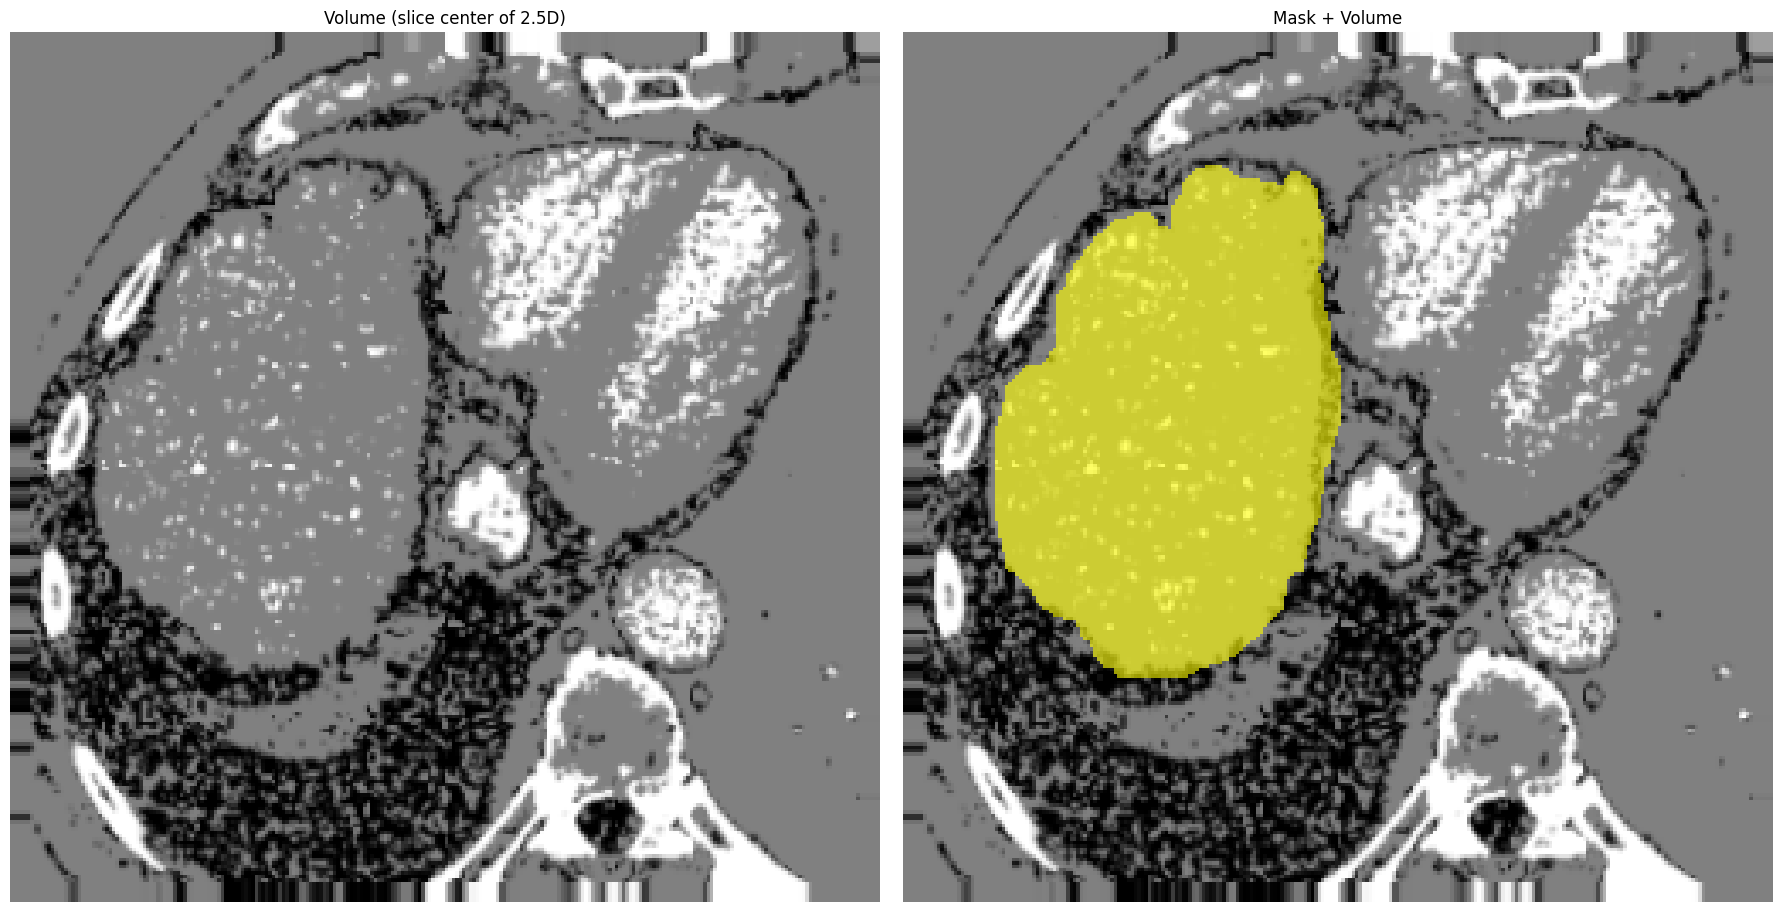

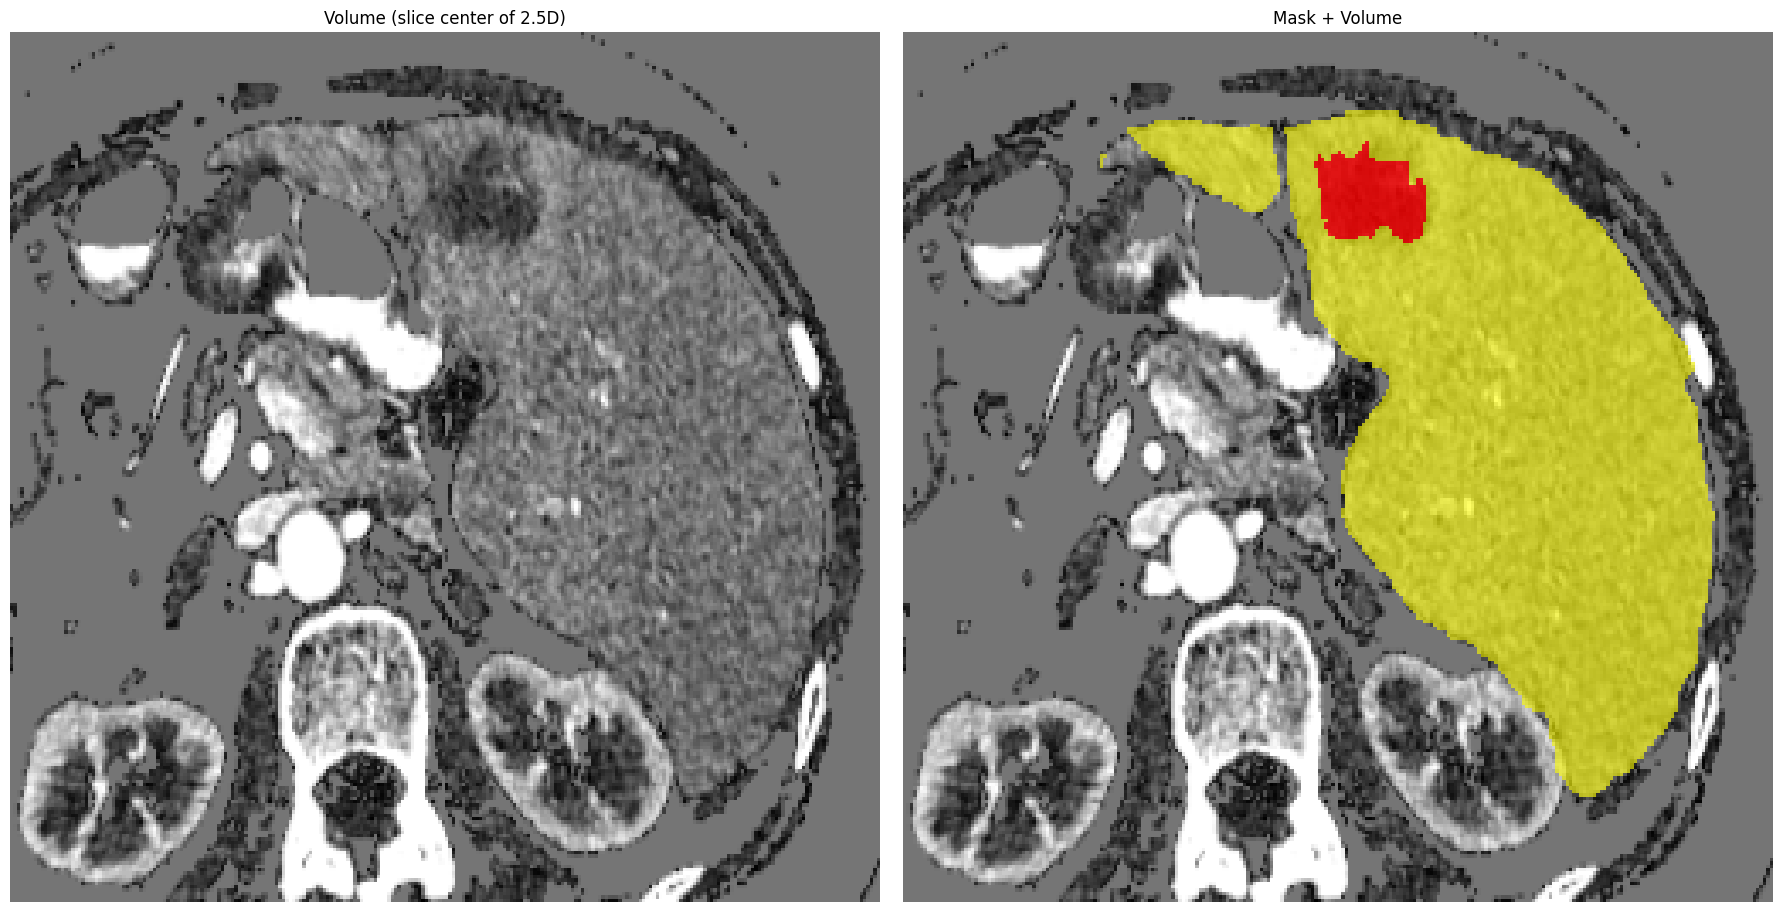

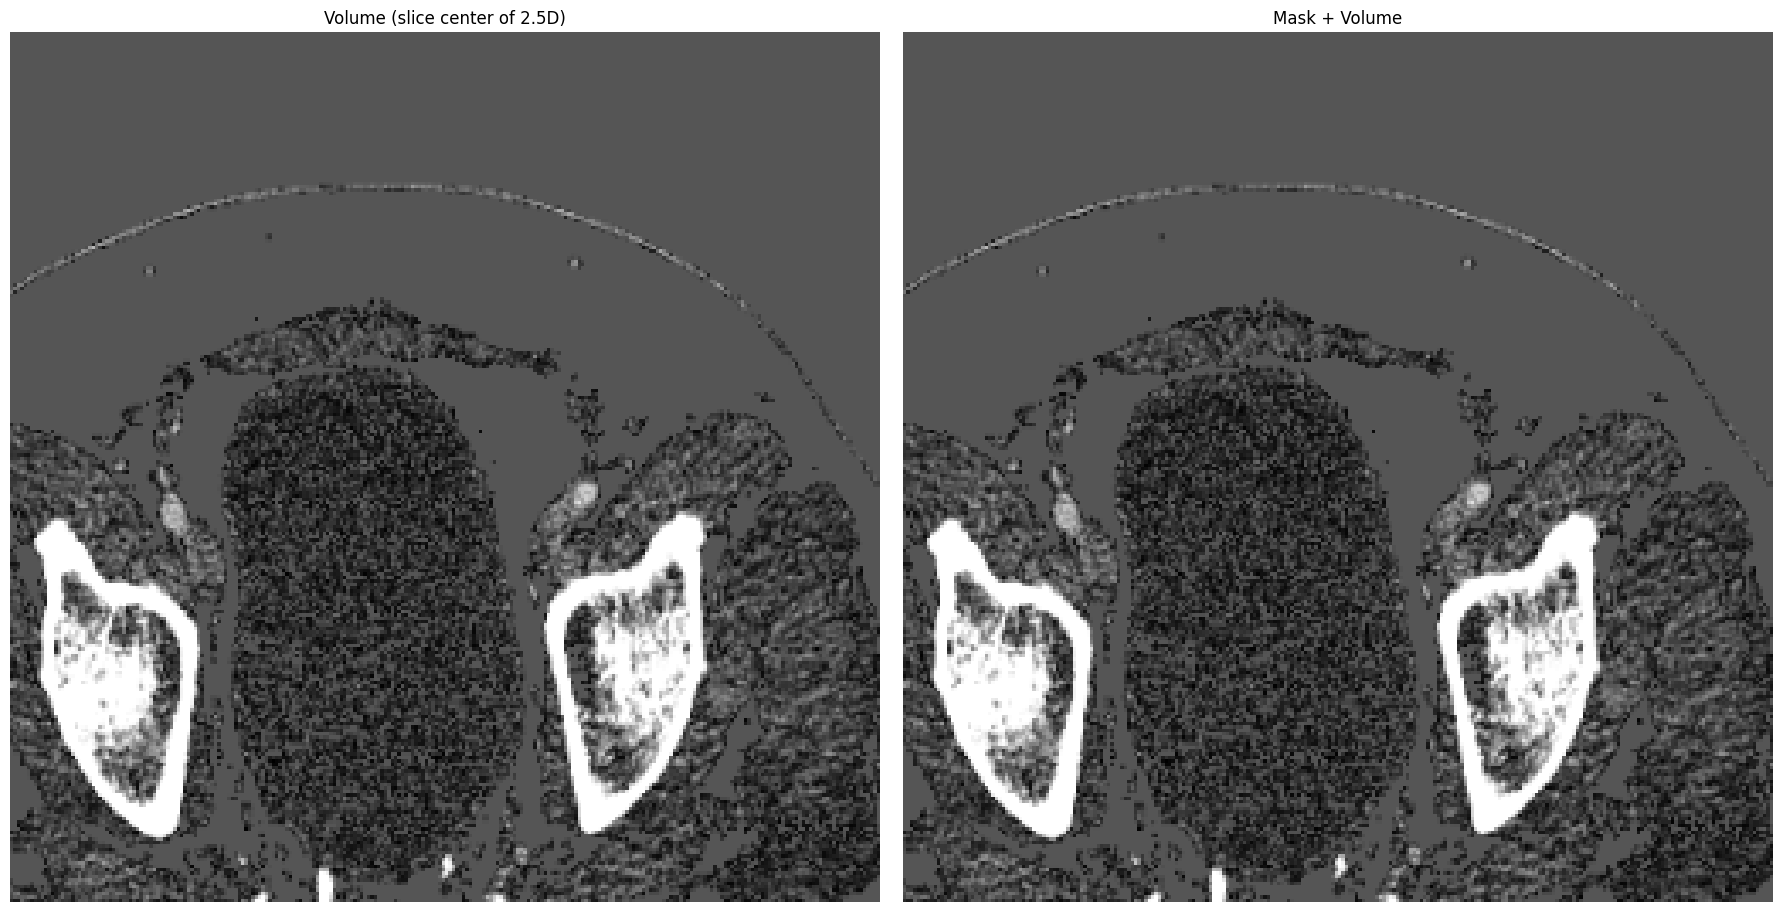

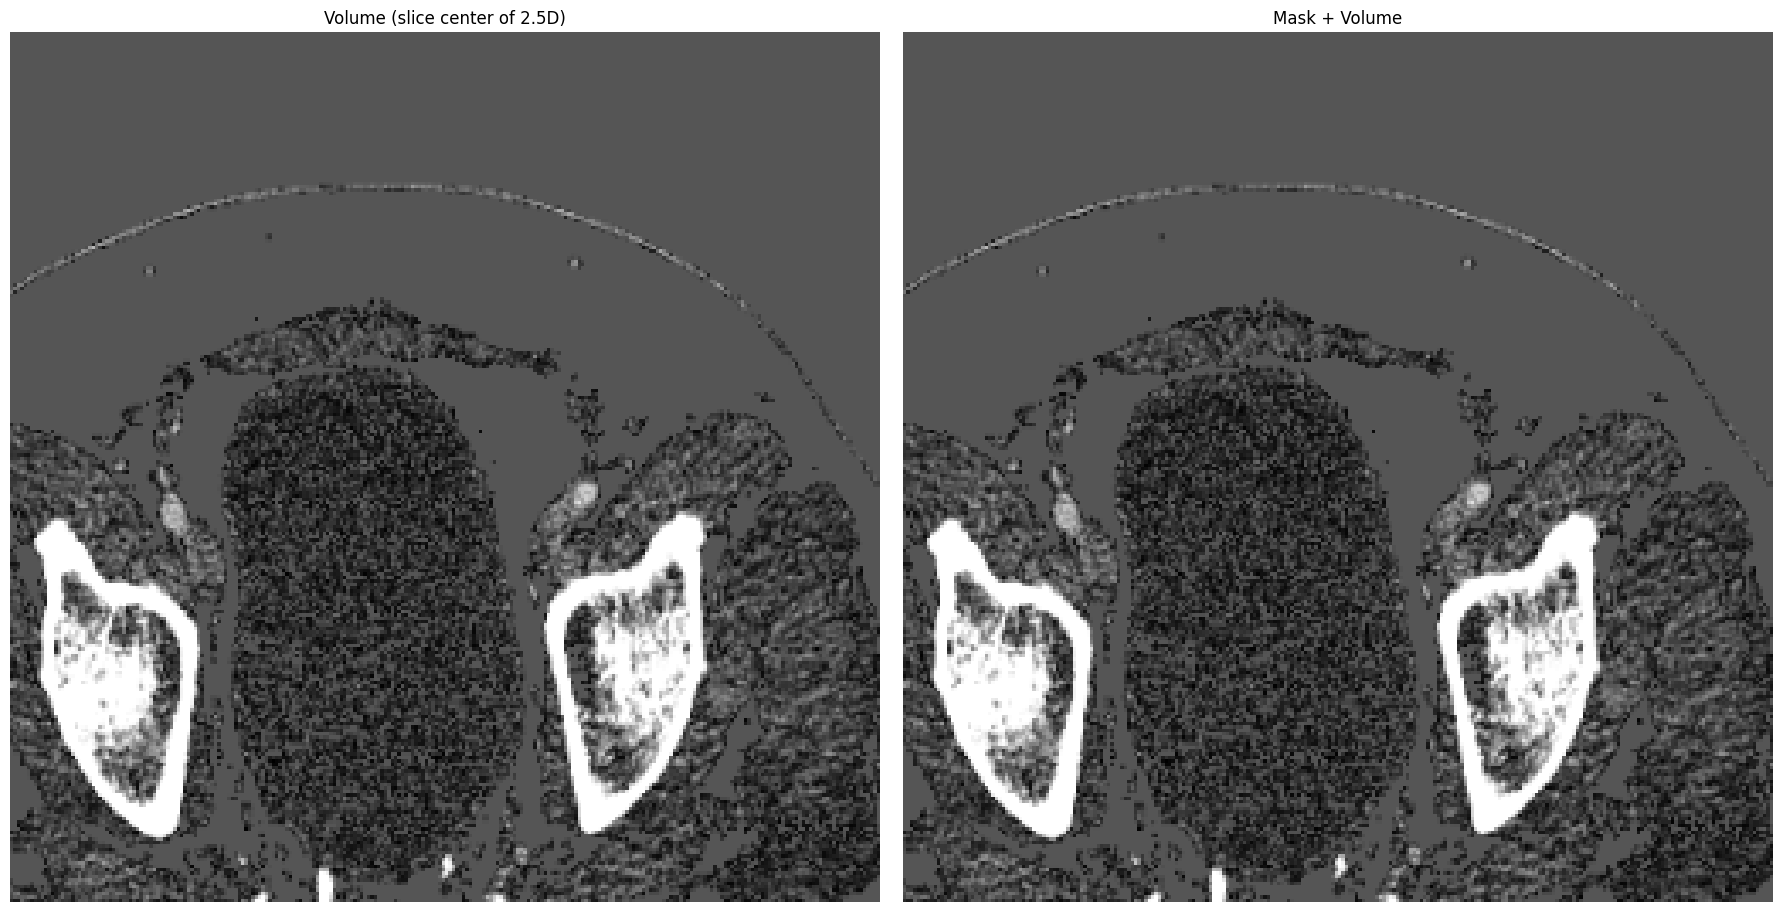

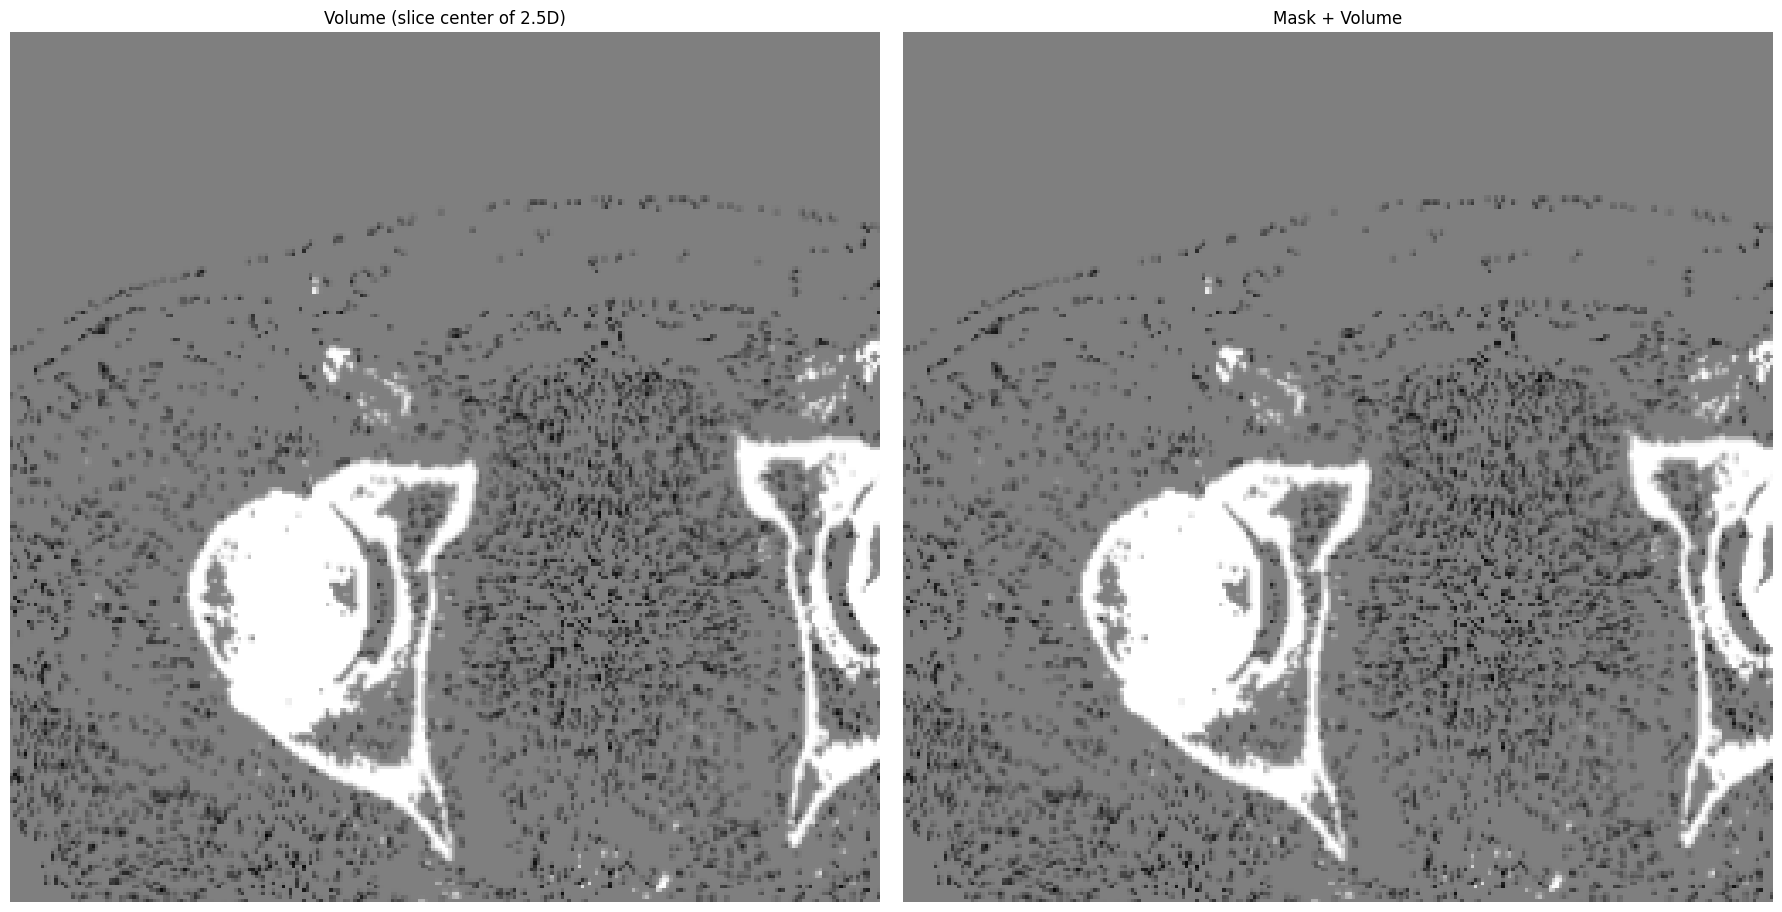

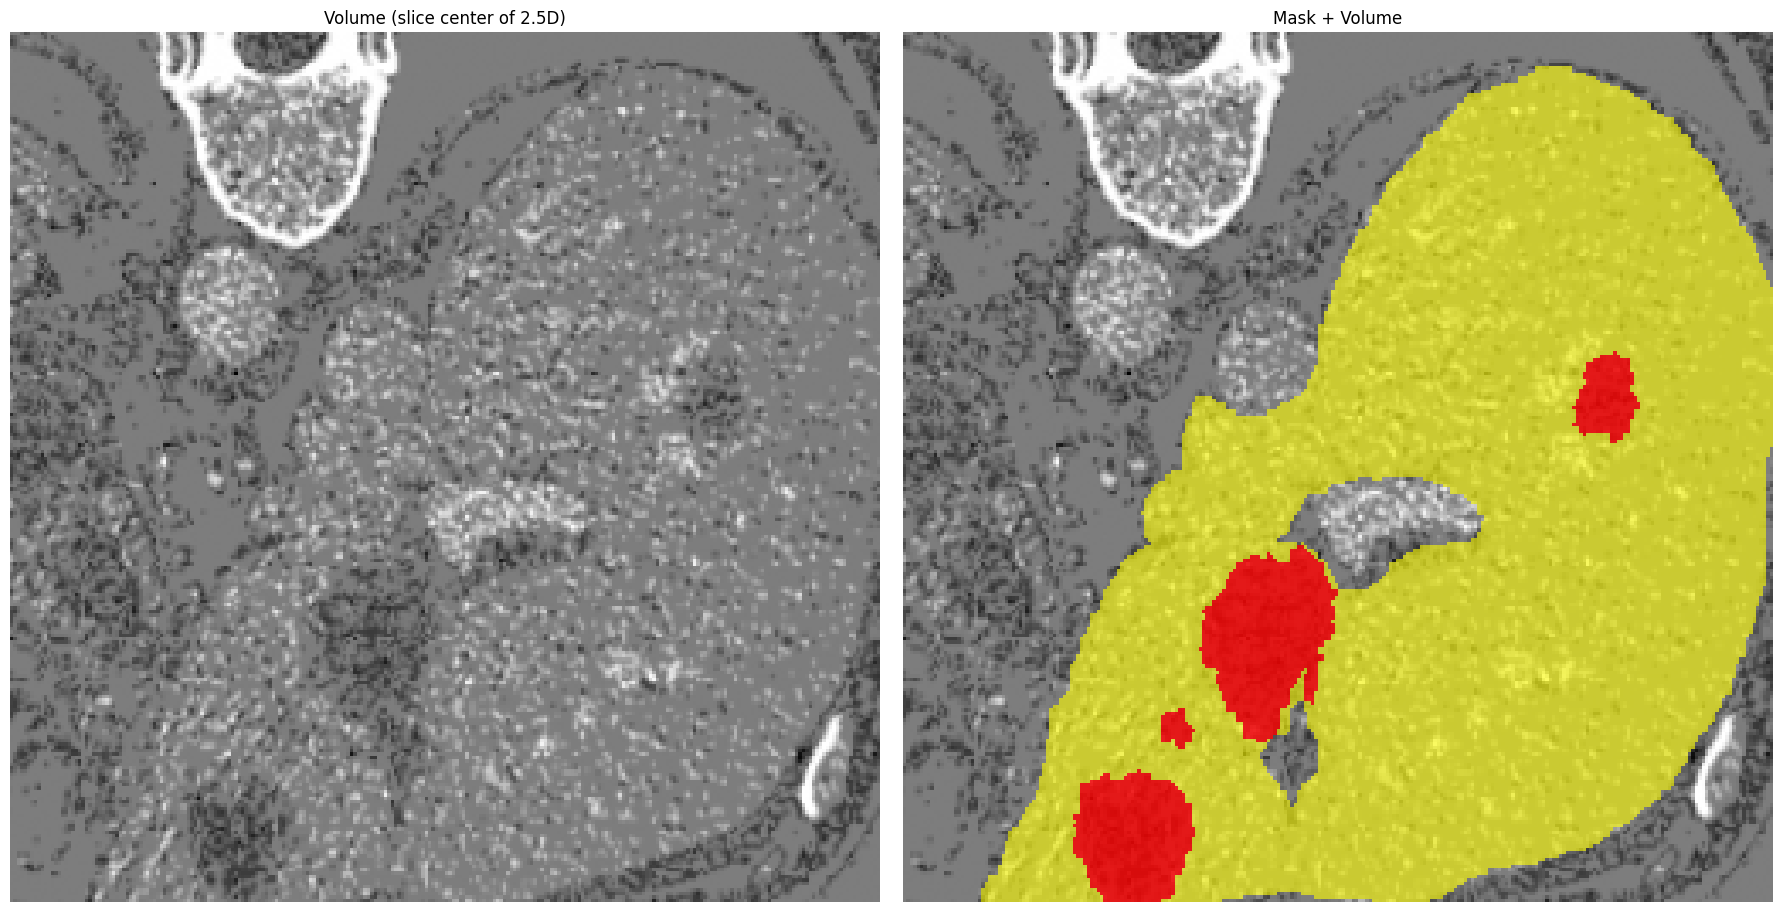

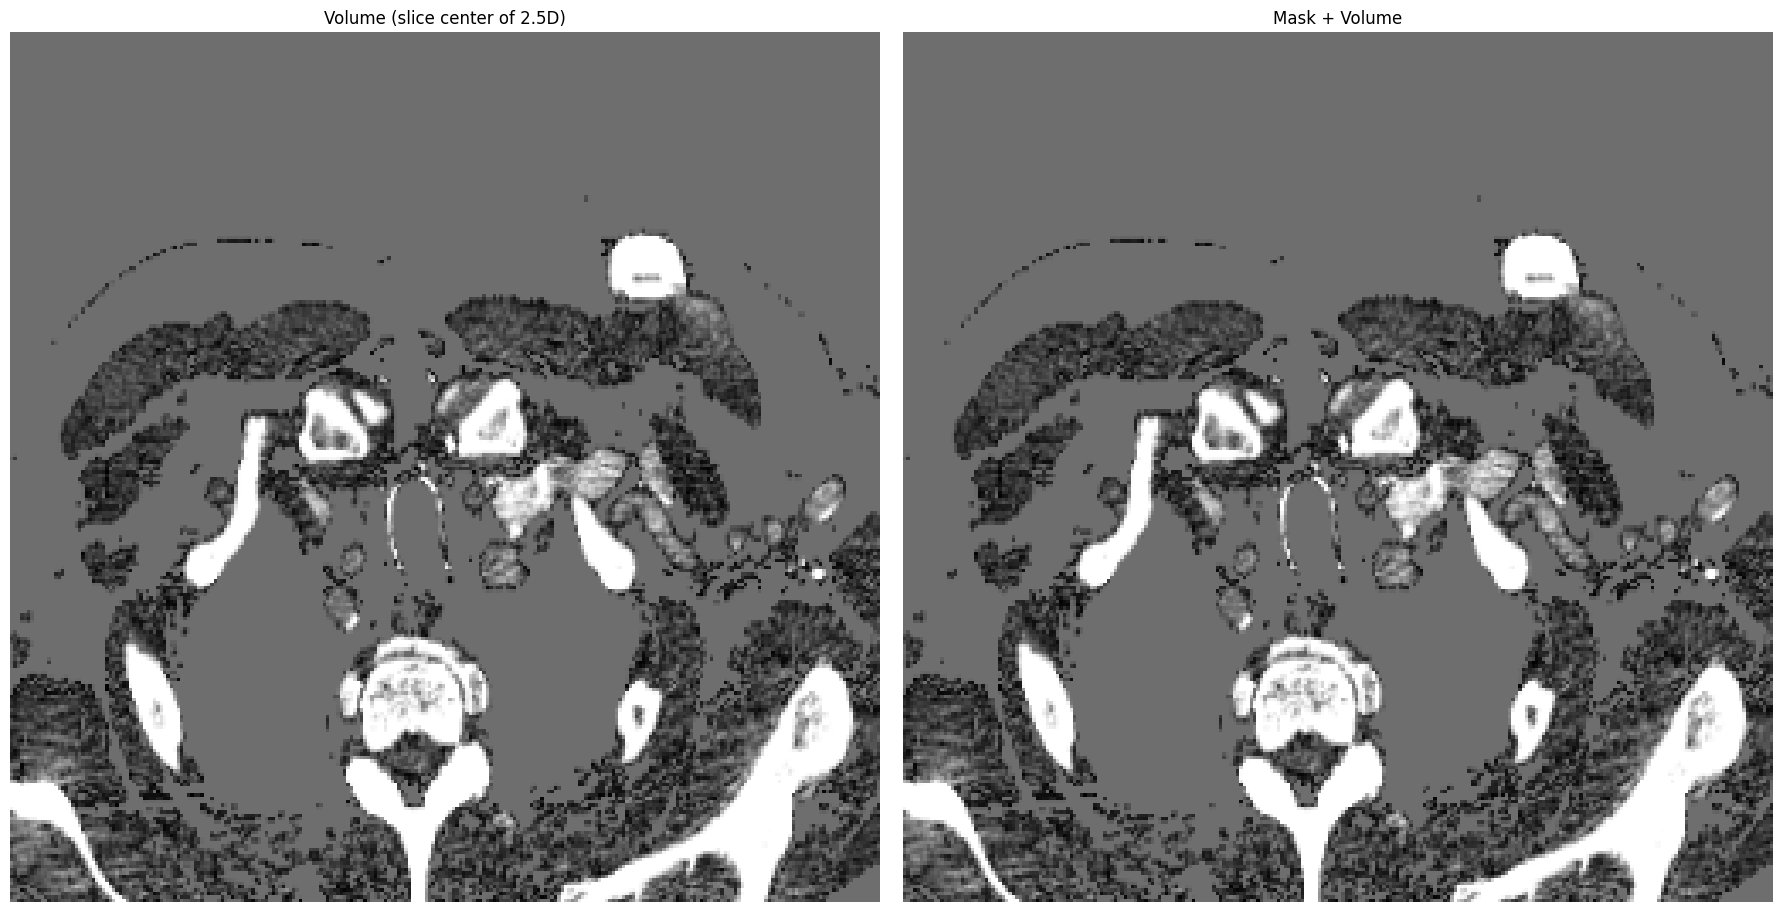

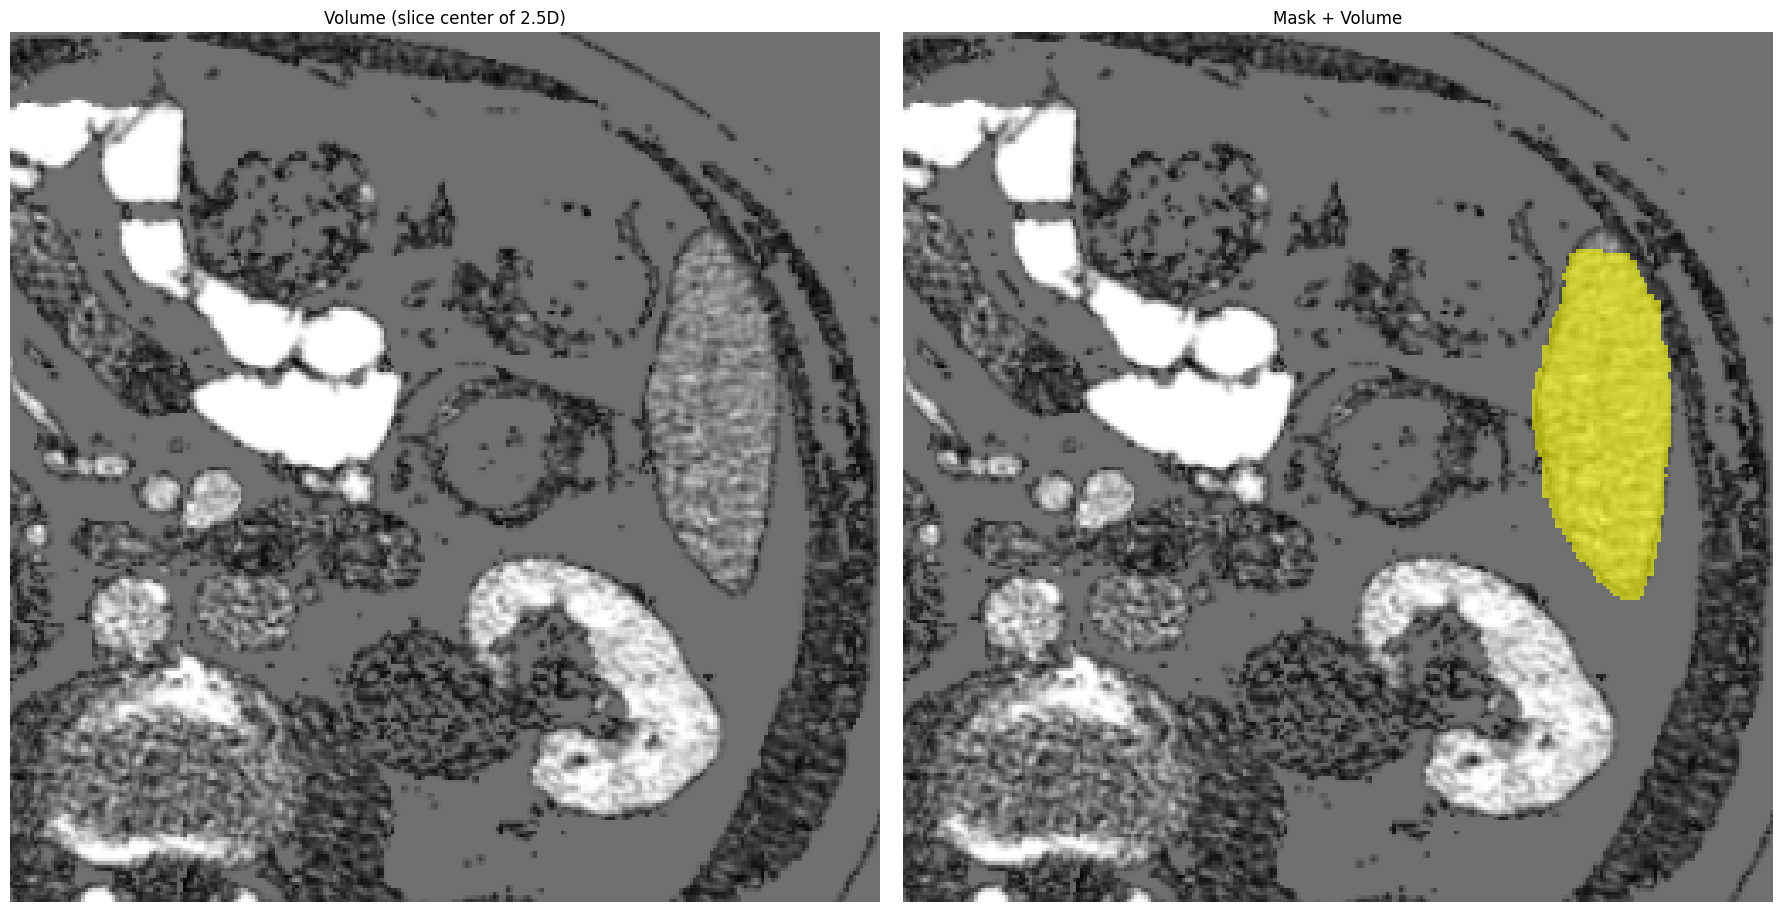

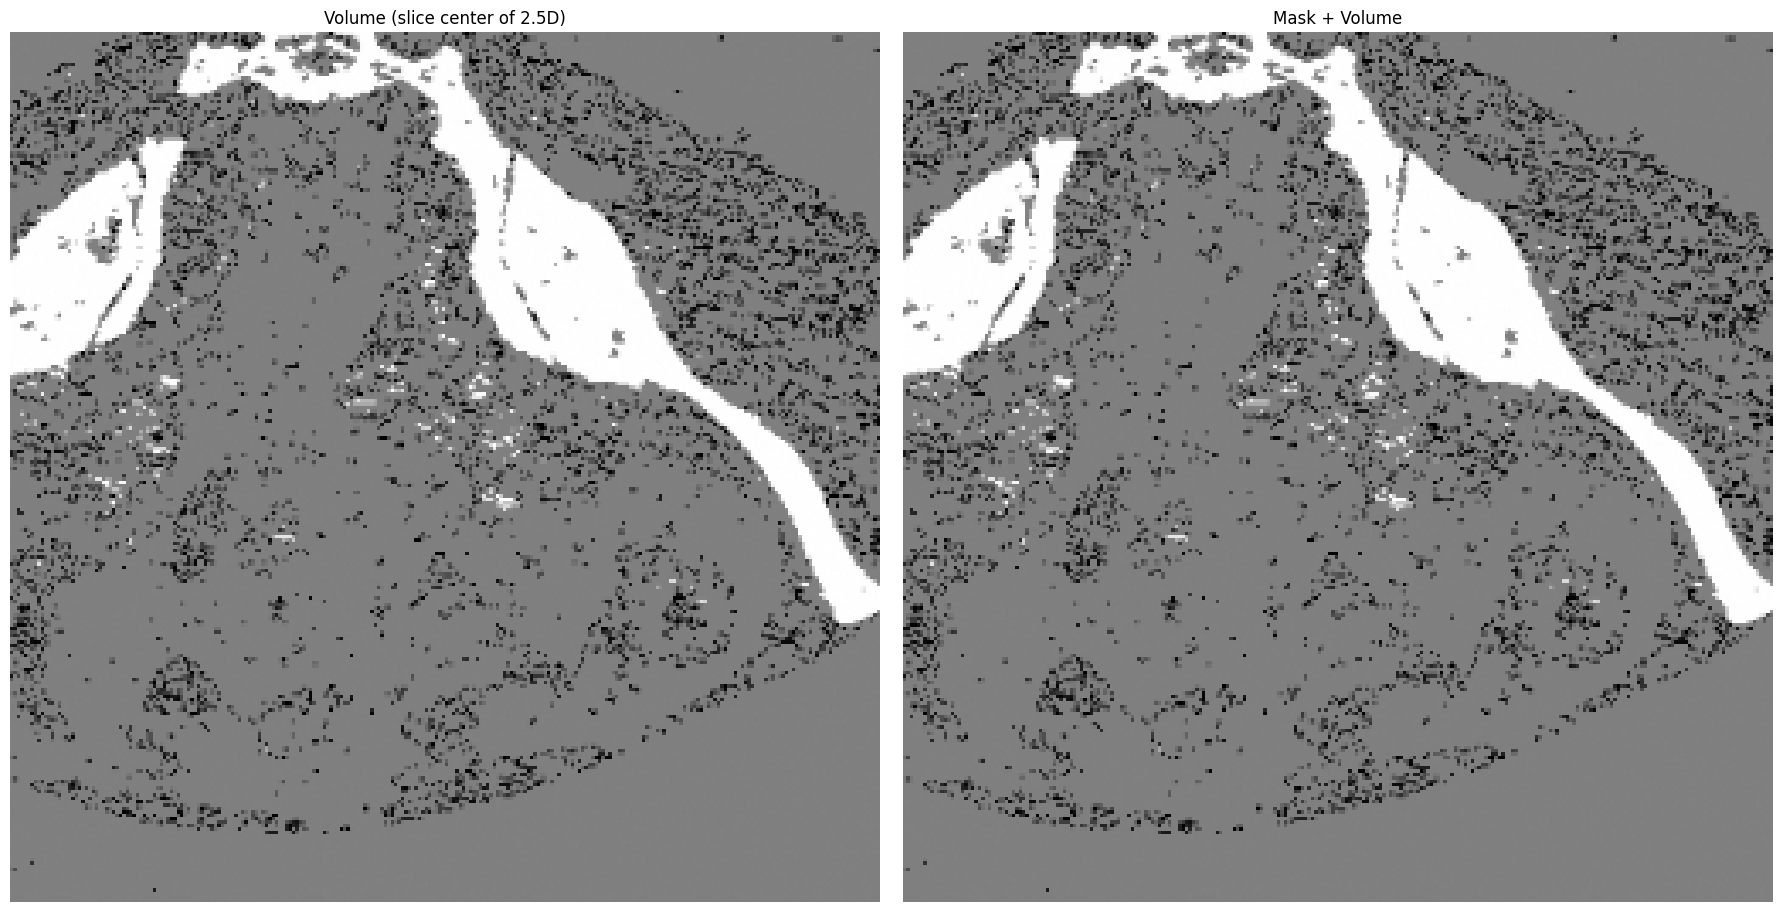

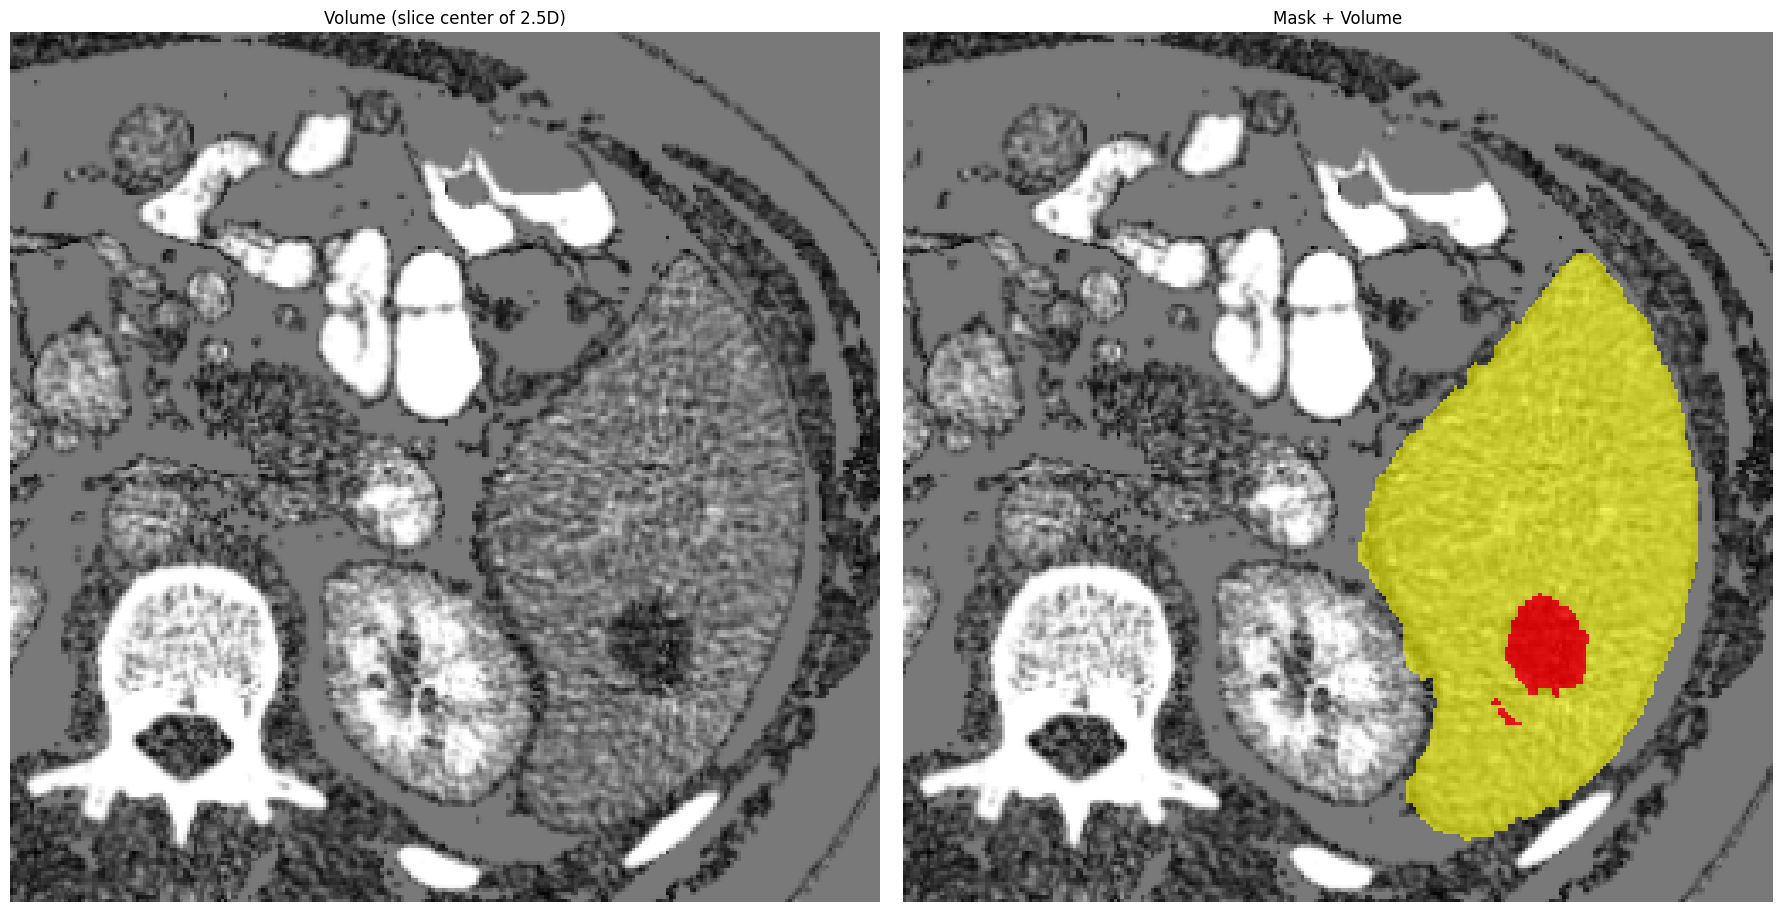

In [ ]:
i = 0
for train_data in train_loader:
    image = train_data["image"]
    label = train_data["label"]
    liver_mask = train_data["liver_mask"]
    visualize_from_loader(image, label, liver_mask)
    # i += 1
    # if i == 10:
    #   break

    if np.any(label.cpu().numpy().squeeze() > 0):
      i += 1
      visualize_from_loader(image, label, liver_mask)

      if i == 10:
        break
    else:
      continue



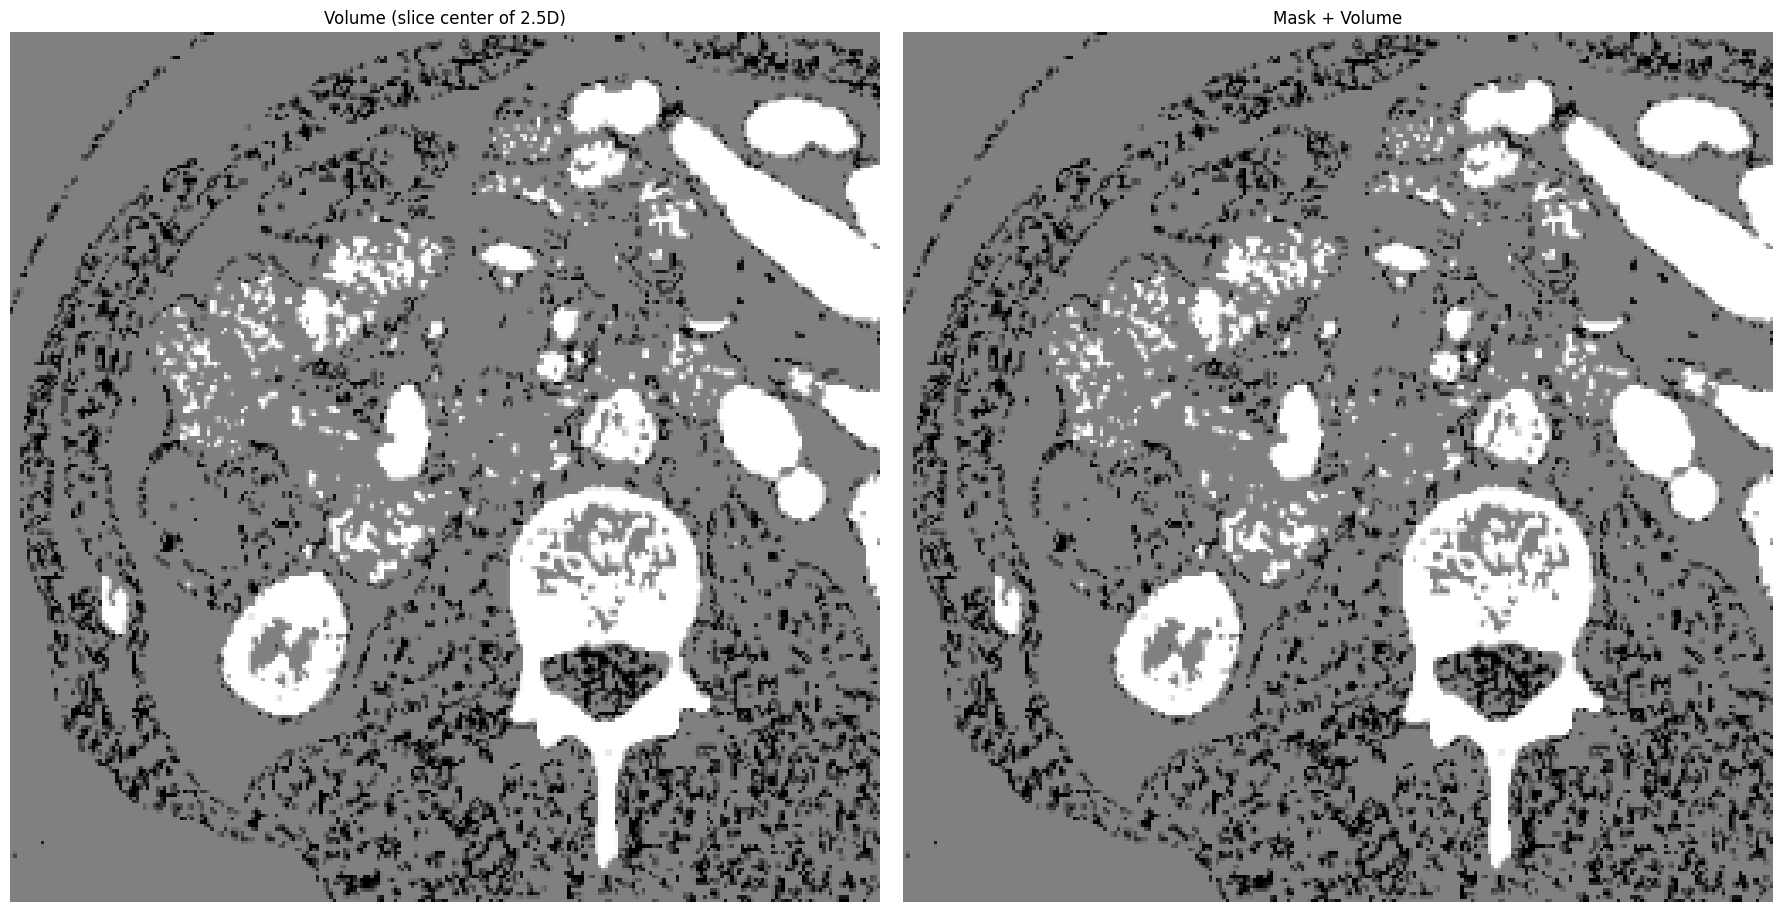

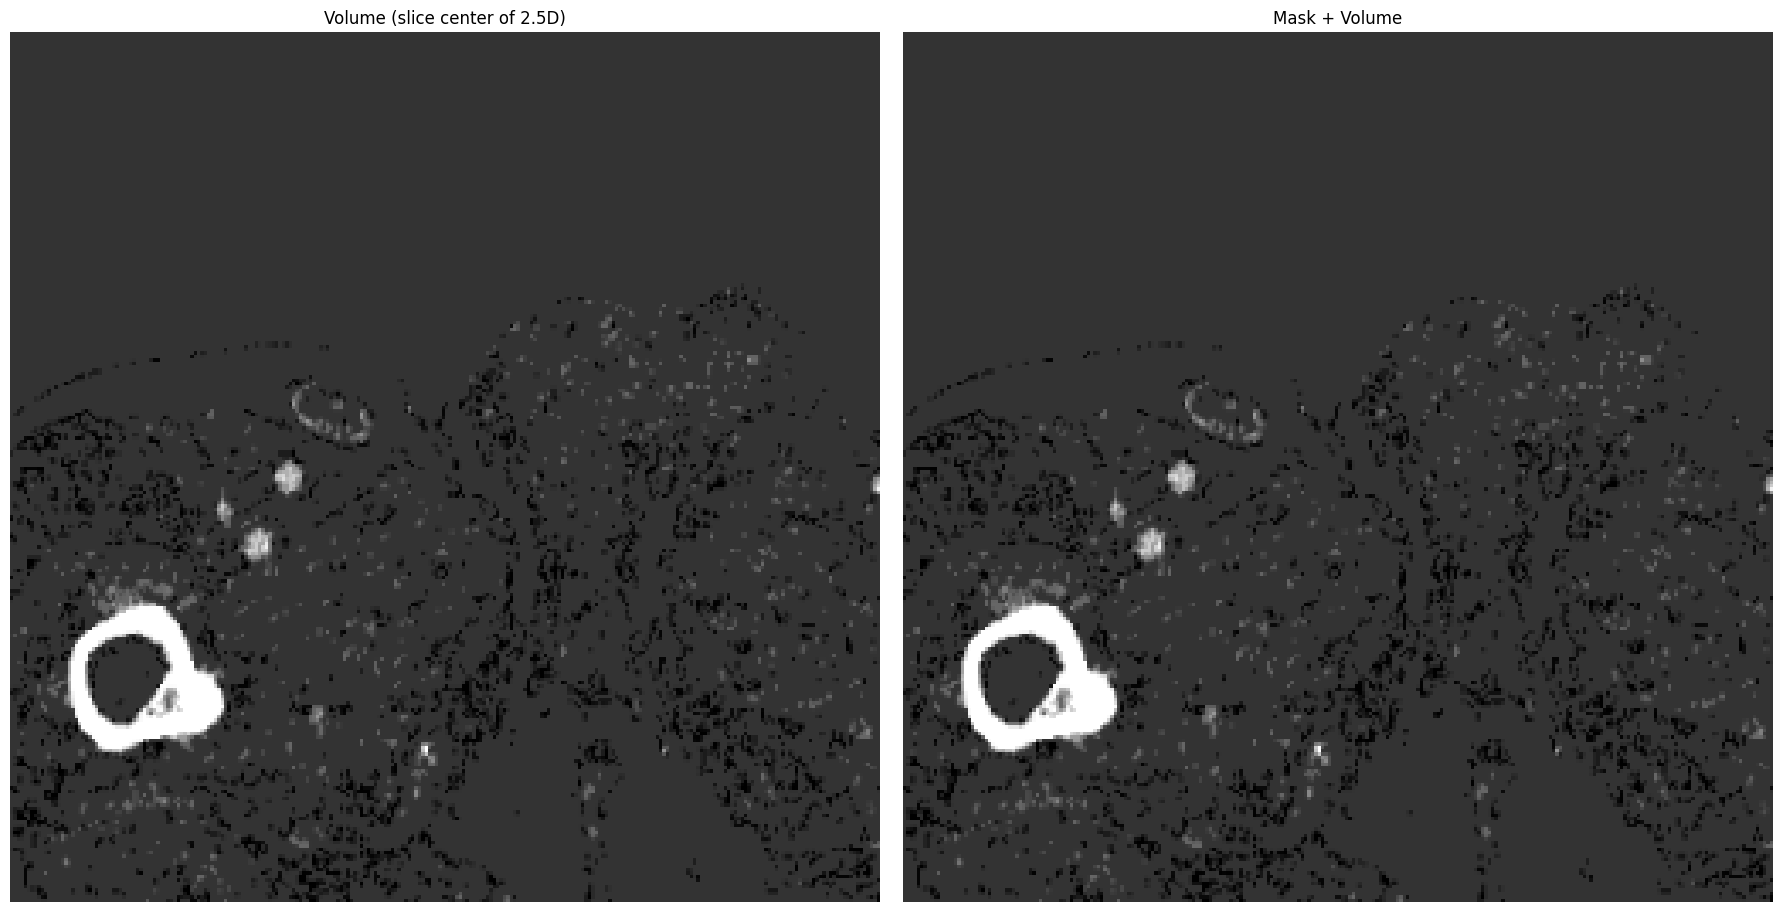

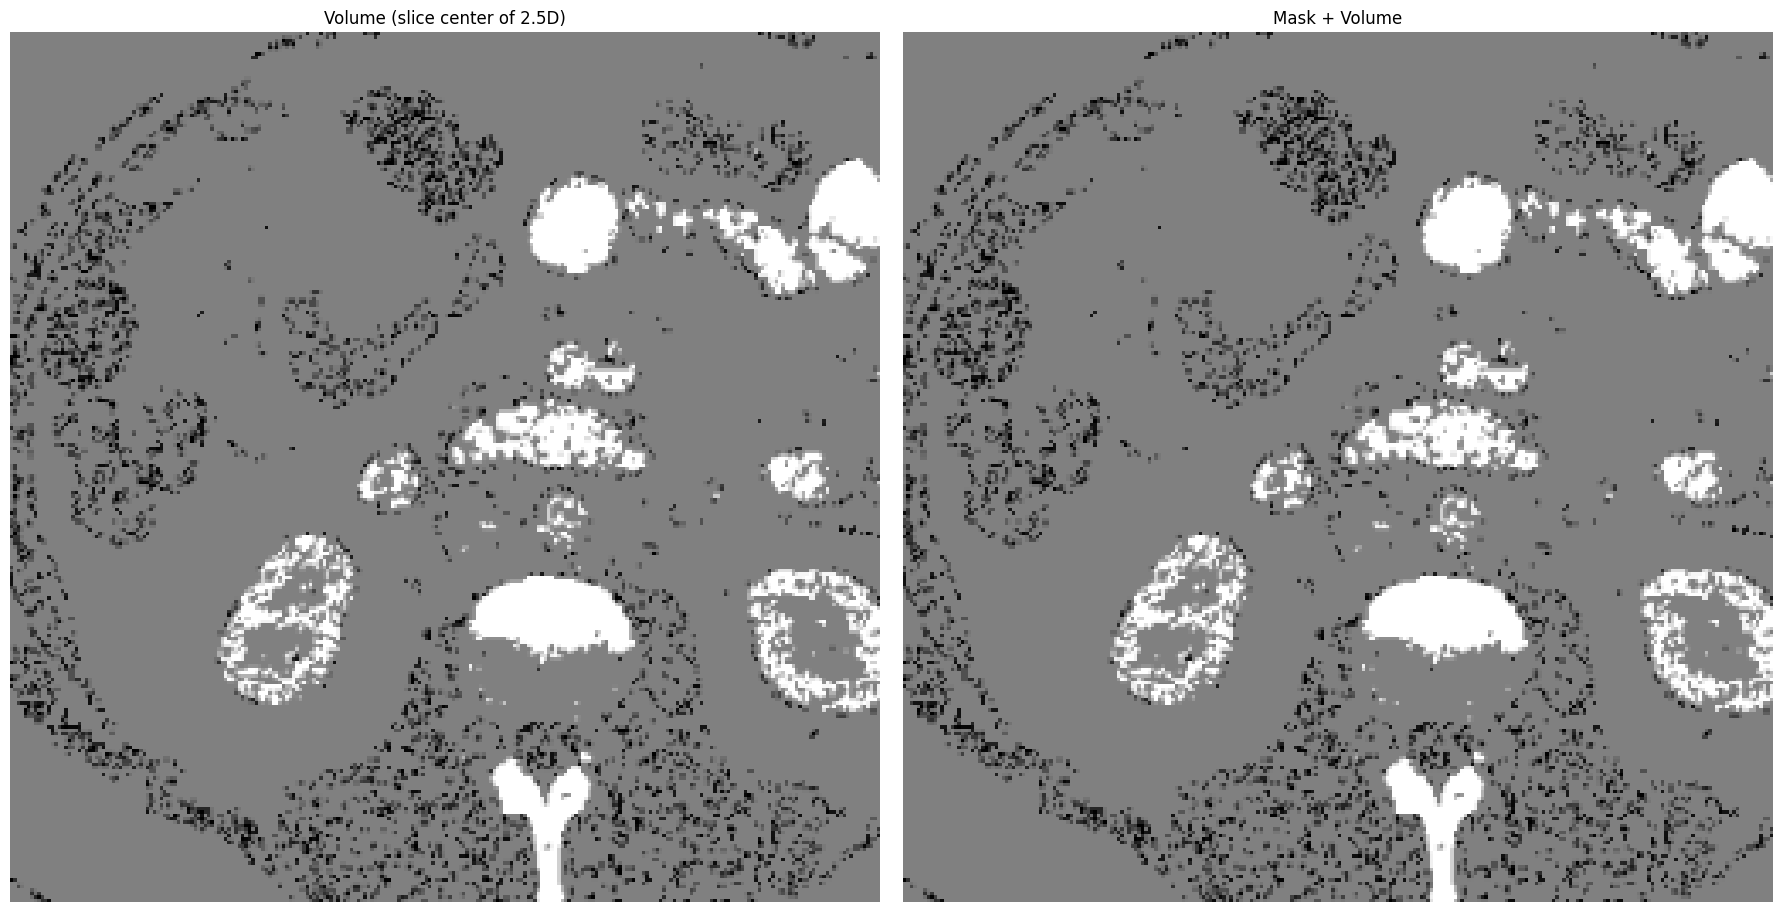

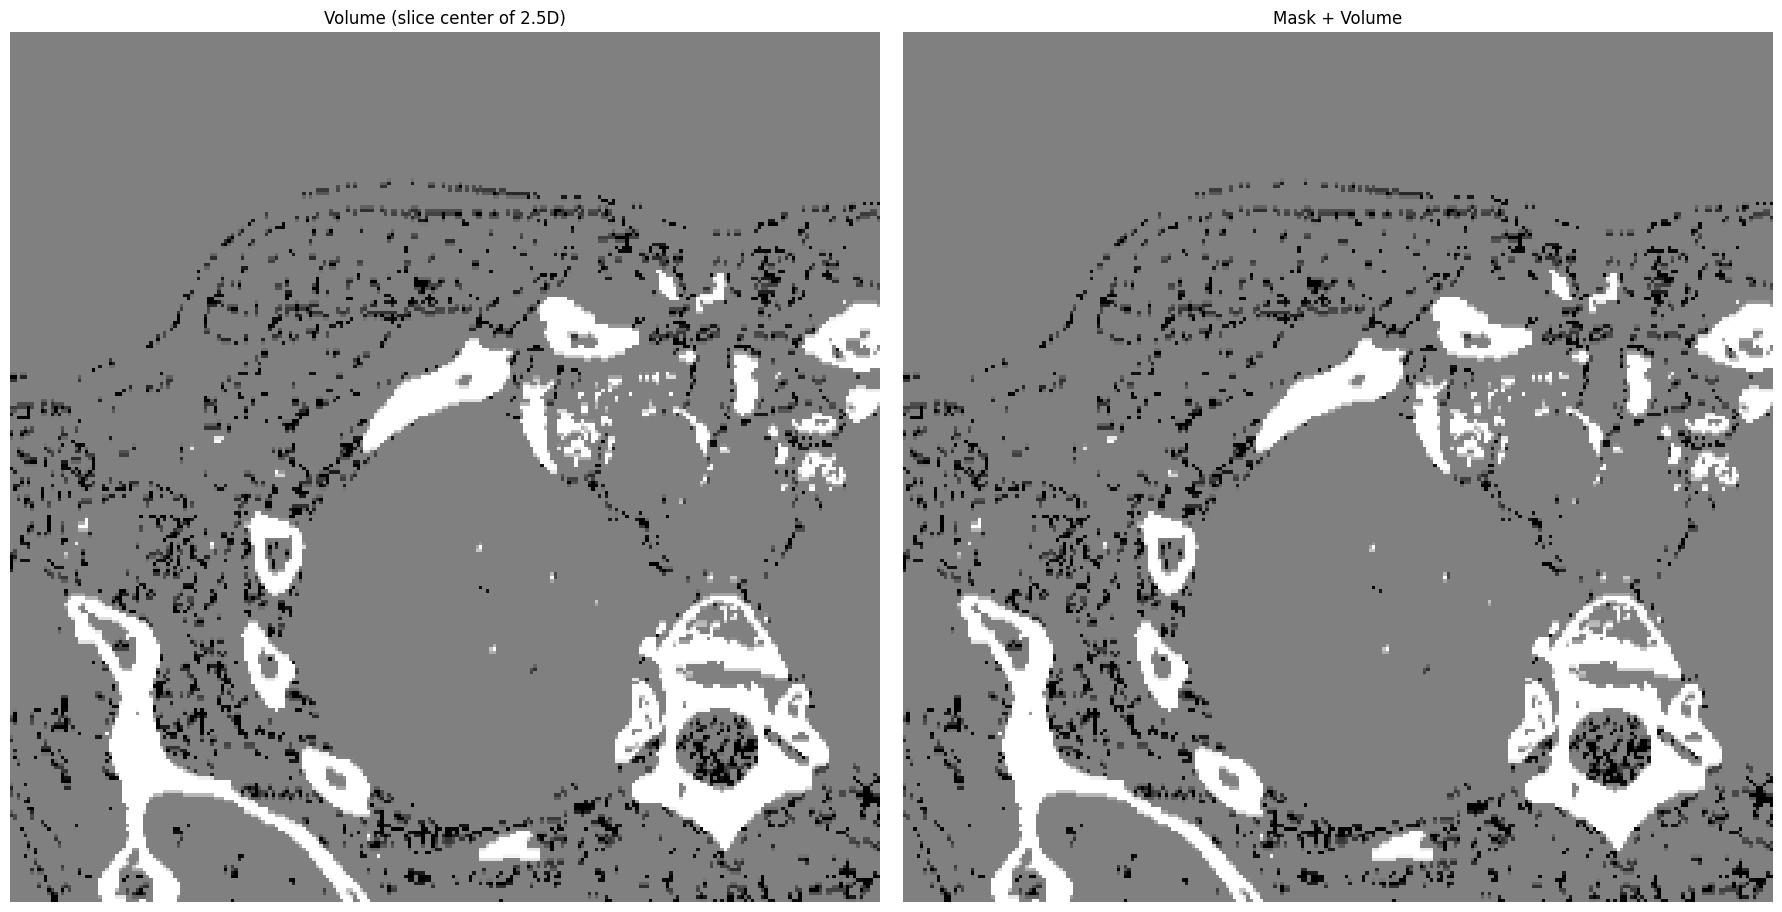

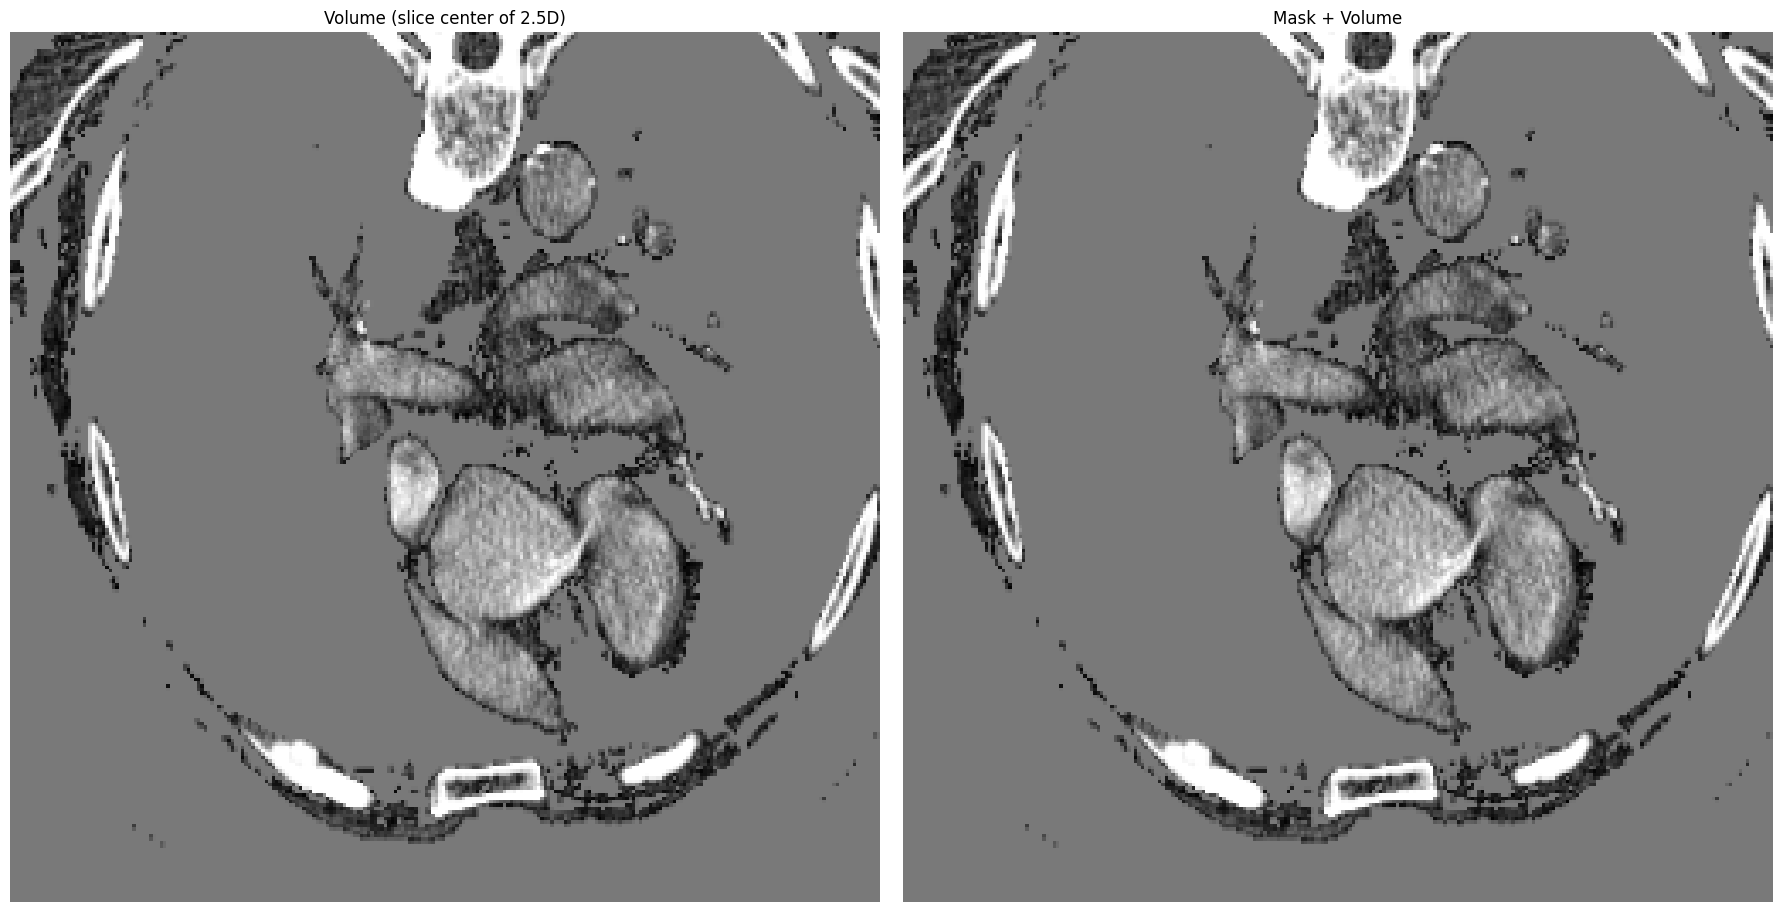

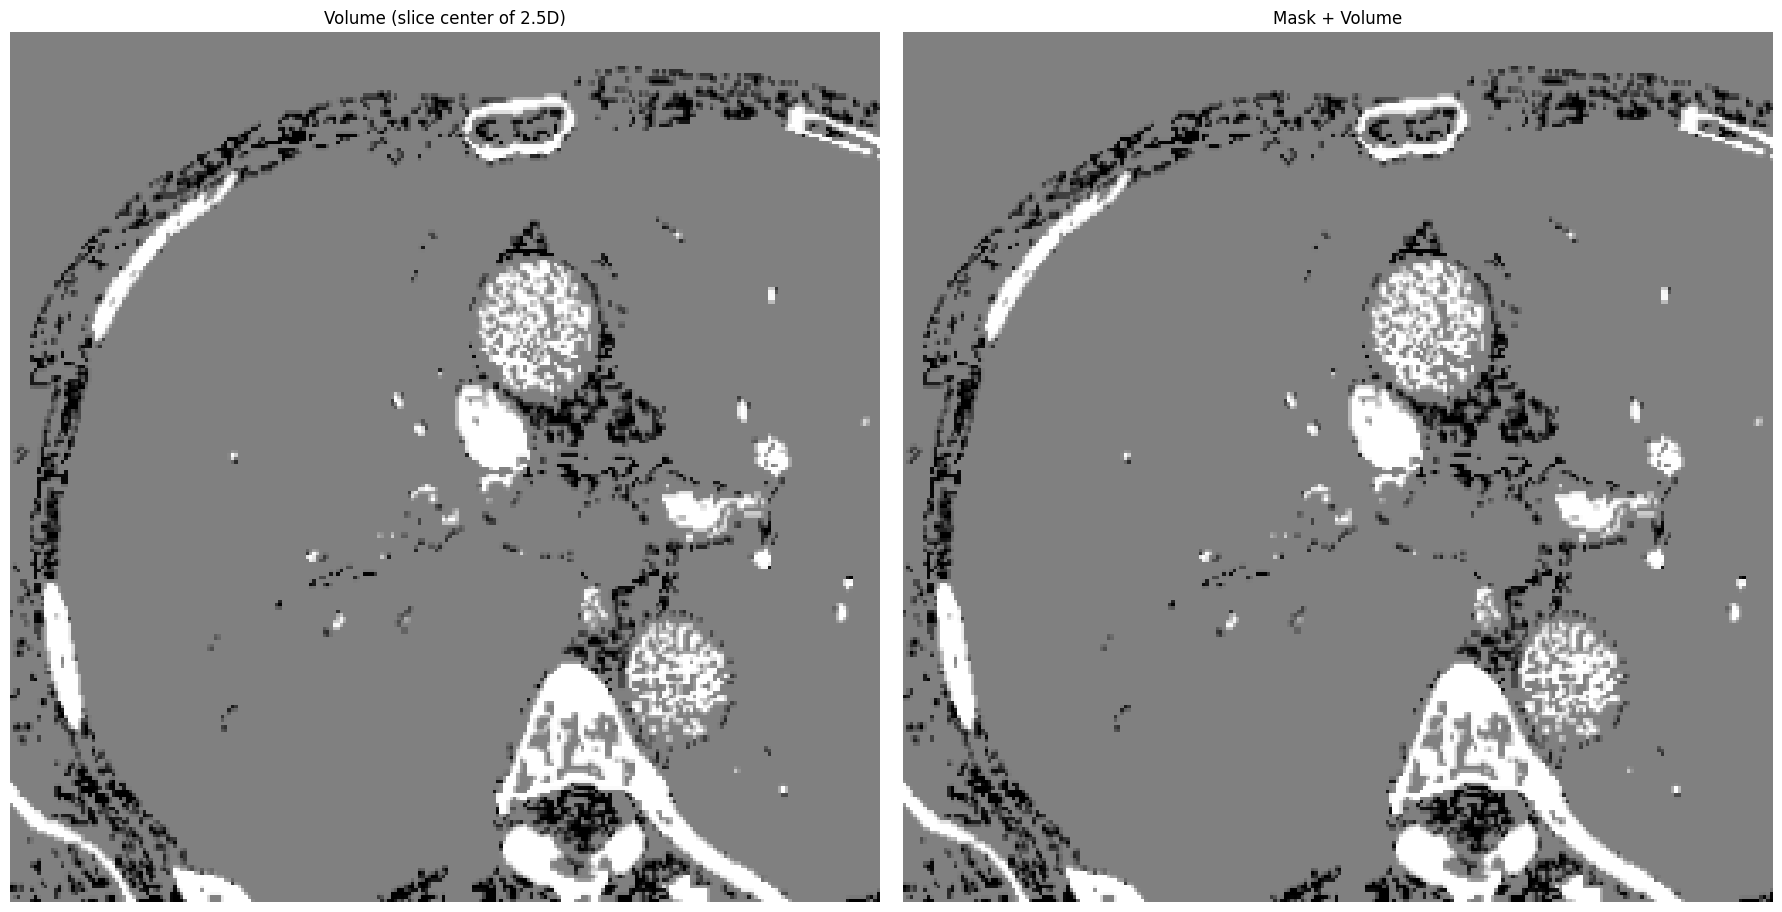

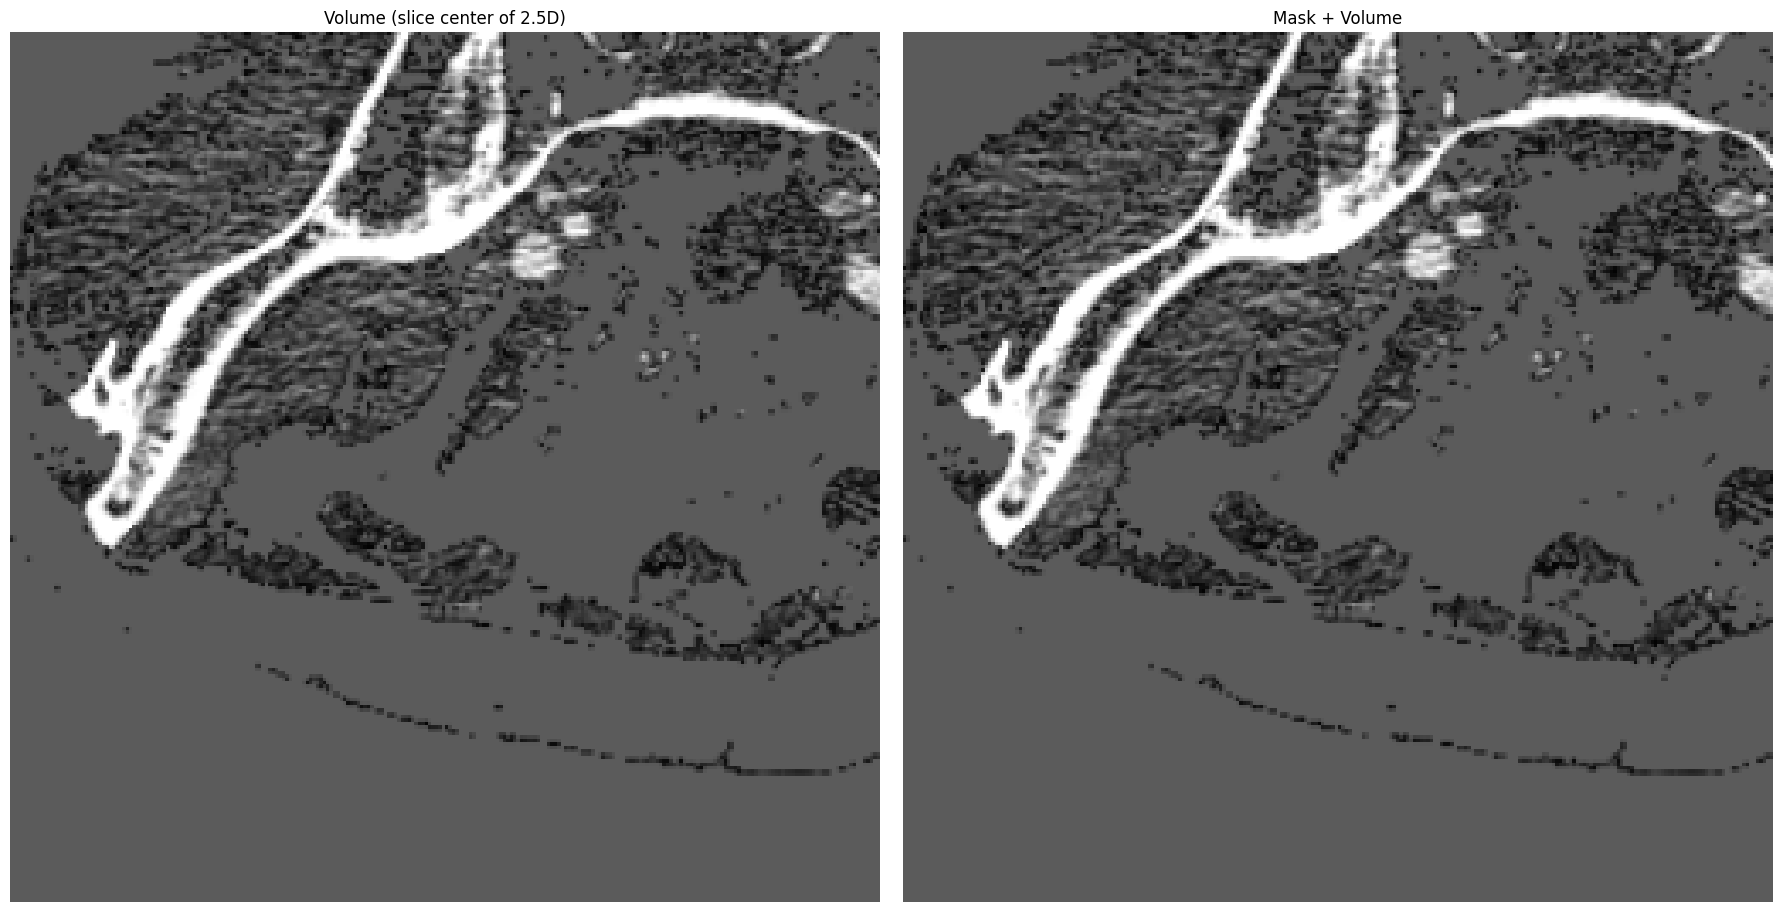

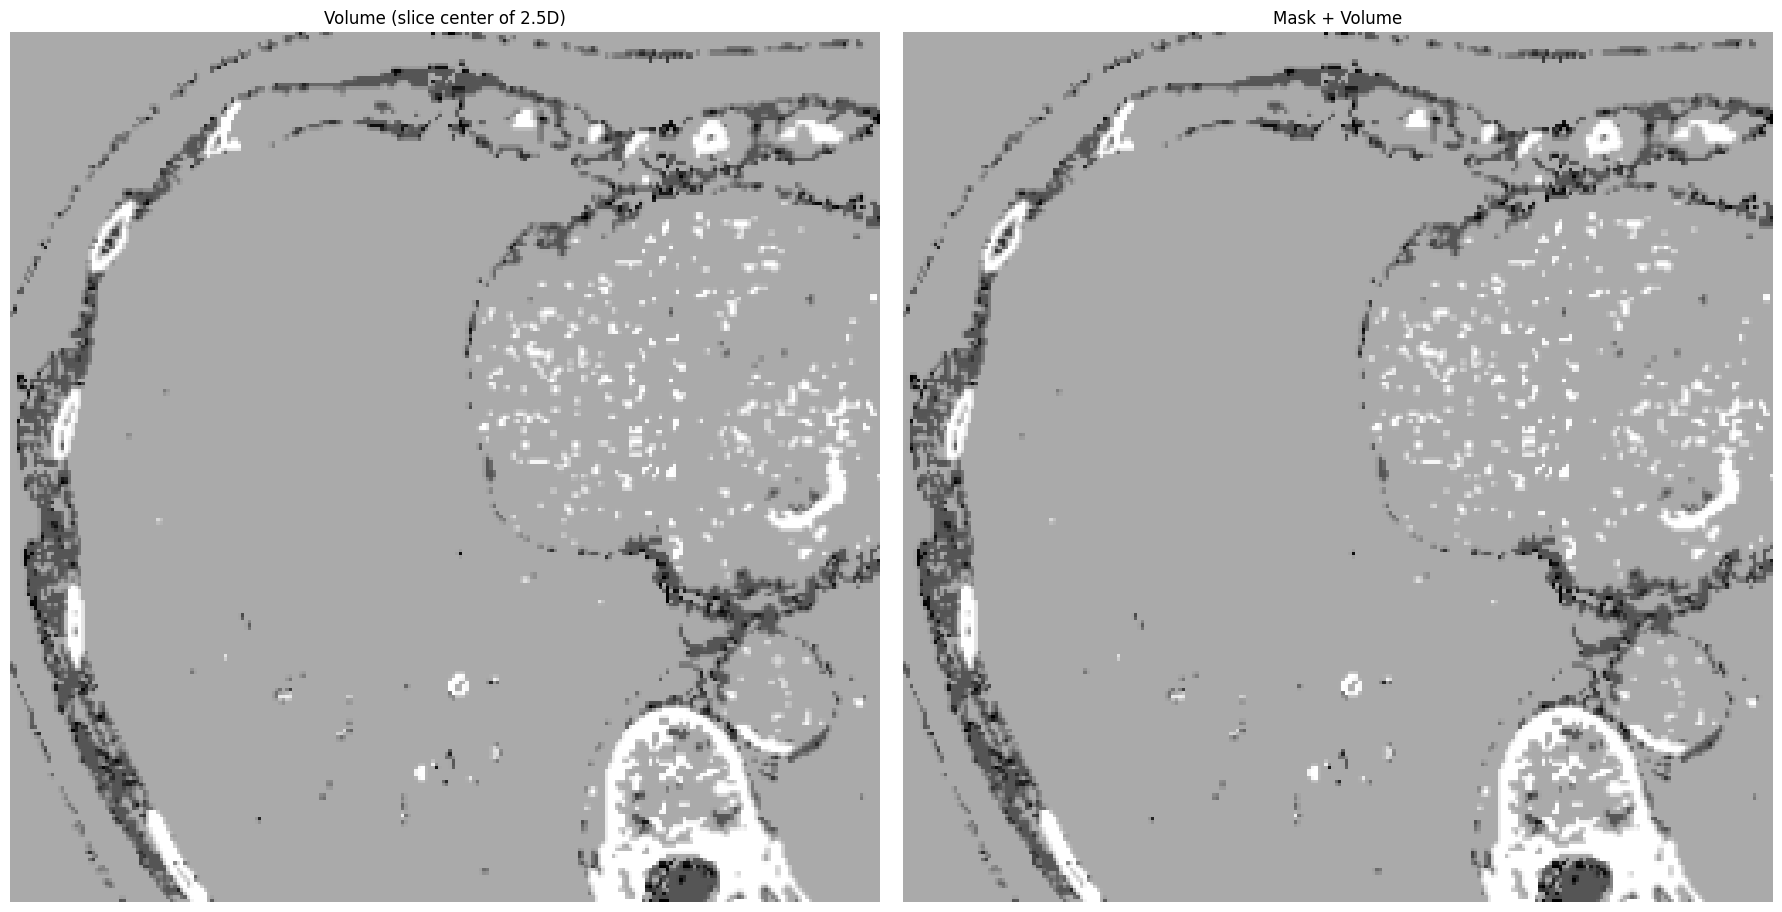

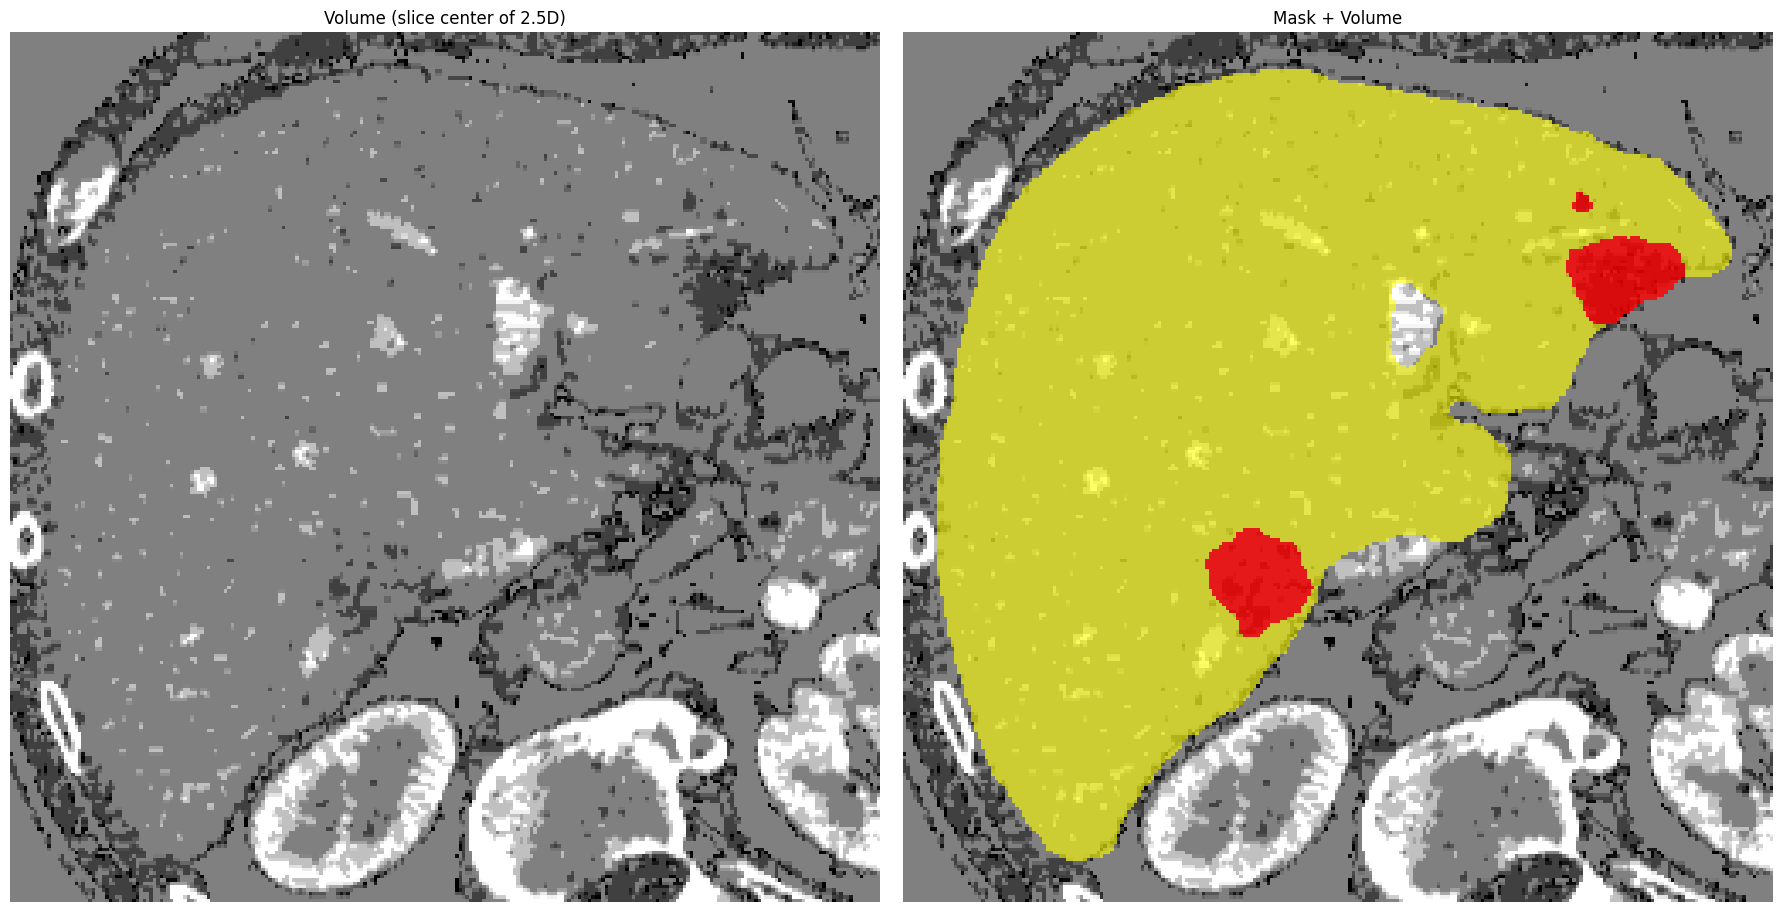

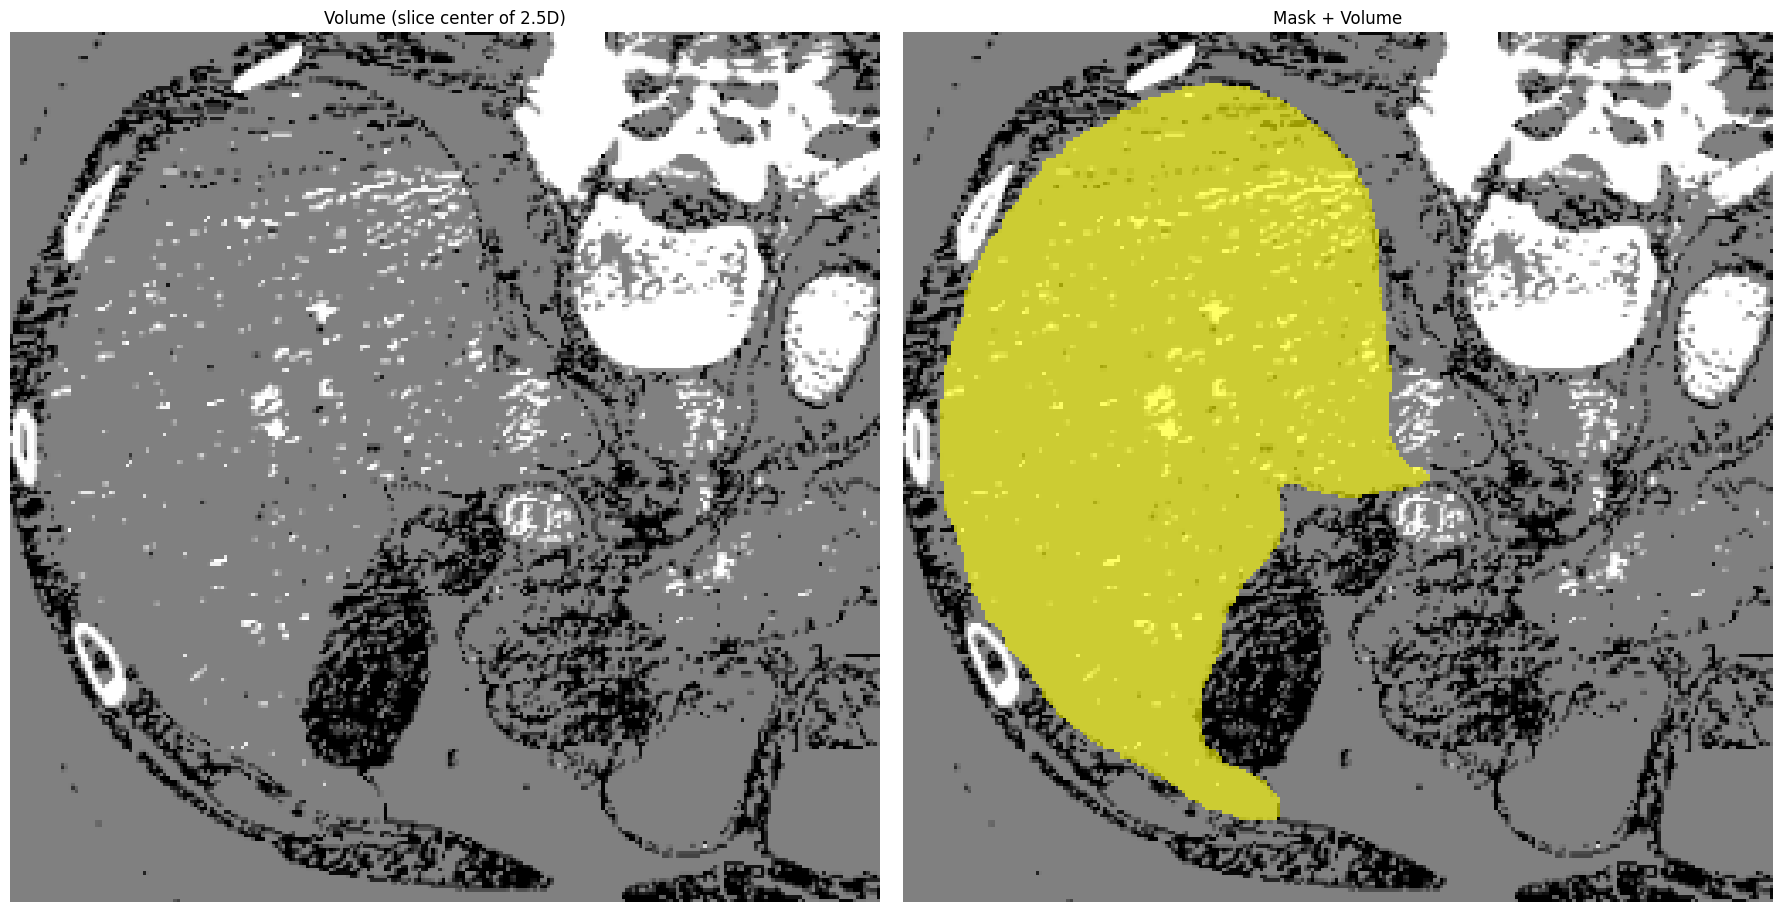

In [ ]:
i = 20
for val_data in val_loader:
    i+= 1

    image = val_data["image"]
    label = val_data["label"]
    liver_mask = val_data["liver_mask"]
    visualize_from_loader(image, label, liver_mask)

    if i == 30:
      break

## Custom train dataset

In [9]:
import random

indices_liver = []
indices_tumor = []
indices_background = []

for i in range(len(full_train_dataset)):
    sample = full_train_dataset[i]
    label = sample["label"]
    liver = sample["liver_mask"]

    if label.sum() > 0:
        indices_tumor.append(i)
    elif liver.sum() > 0:
        indices_liver.append(i)
    else:
        indices_background.append(i)
random.seed(42)
selected_background = random.sample(indices_background, k=int(len(indices_background) * 0.5))
final_indices = indices_tumor + indices_liver + selected_background

In [10]:
from torch.utils.data import Subset
balanced_dataset = Subset(full_train_dataset, final_indices)

In [11]:
print(len(balanced_dataset))

15561


## WeightedRandomSampler

In [12]:
import torch
from torch.utils.data import WeightedRandomSampler

weights = []
for i in range(len(balanced_dataset)):
    sample = balanced_dataset[i]
    has_tumor = sample["label"].sum() > 0
    weights.append(5.0 if has_tumor else 1.0)

In [13]:
sampler = WeightedRandomSampler(weights, num_samples=len(balanced_dataset), replacement=True)
train_loader = torch.utils.data.DataLoader(balanced_dataset, batch_size=16, sampler=sampler, shuffle=False, pin_memory=True, num_workers=1, drop_last=True)

## Training

In [14]:
# criterion = DiceLossWSigmoid().to(device)
criterion = TverskyLossWSigmoid().to(device)

dice_acc = DiceMetric(include_background=False, reduction='mean_batch', get_not_nans=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=float(config["learning_rate_train"]), weight_decay=float(config["weight_decay"]))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=int(config["max_epochs"]), eta_min = float(config["eta_min"]))

In [ ]:
LOGGER.info("[TRAINER] Start TRAIN process...")

(
    val_acc_max,
    best_epoch,
    dices_tumor,
    loss_epochs,
    trains_epoch,
    ious_tumor,
    precisions_tumor,
    recalls_tumor,
    time_tmp
) = trainer_stage2(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_func=criterion,
    acc_func=dice_acc,
    scheduler=scheduler,
    batch_size=config["batch_size"],
    # max_epochs = config["max_epochs"],
    max_epochs = 8,
    start_epoch = config["start_epoch"],
    val_every=config["val_every"],
    path_save_model=config["path_save_model_state"],
    logger=LOGGER,
    save_model=False,
    post_fix="tumor_2d"
)

[TRAINER] Start TRAIN process...
INFO:kltn.utils.logger:[TRAINER] Start TRAIN process...

==============================Training epoch 1==============================
INFO:kltn.utils.logger:
==============================Training epoch 1==============================


Epoch 1/8 1/972 loss: 0.9108 time 3.67s
Epoch 1/8 2/972 loss: 0.8922 time 0.57s
Epoch 1/8 3/972 loss: 0.8829 time 0.57s
Epoch 1/8 4/972 loss: 0.8835 time 0.57s
Epoch 1/8 5/972 loss: 0.8814 time 0.57s
Epoch 1/8 6/972 loss: 0.8793 time 0.81s
Epoch 1/8 7/972 loss: 0.8764 time 0.81s
Epoch 1/8 8/972 loss: 0.8740 time 1.13s
Epoch 1/8 9/972 loss: 0.8727 time 0.98s
Epoch 1/8 10/972 loss: 0.8708 time 0.76s
Epoch 1/8 11/972 loss: 0.8696 time 0.93s
Epoch 1/8 12/972 loss: 0.8671 time 0.79s
Epoch 1/8 13/972 loss: 0.8658 time 0.67s
Epoch 1/8 14/972 loss: 0.8645 time 0.69s
Epoch 1/8 15/972 loss: 0.8629 time 0.66s
Epoch 1/8 16/972 loss: 0.8613 time 0.69s
Epoch 1/8 17/972 loss: 0.8594 time 0.65s
Epoch 1/8 18/972 loss: 0.8580 time 0.62s
Epoch 1/8 19/972 loss: 0.8570 time 0.70s
Epoch 1/8 20/972 loss: 0.8551 time 0.64s
Epoch 1/8 21/972 loss: 0.8540 time 0.63s
Epoch 1/8 22/972 loss: 0.8528 time 0.78s
Epoch 1/8 23/972 loss: 0.8511 time 0.61s
Epoch 1/8 24/972 loss: 0.8497 time 0.71s
Epoch 1/8 25/972 loss: 0.

Final training epochs: 1/8 ---[loss: 0.6199] ---[time 737.86s]
INFO:kltn.utils.logger:Final training epochs: 1/8 ---[loss: 0.6199] ---[time 737.86s]

********************Epoch 1 Validation********************
INFO:kltn.utils.logger:
********************Epoch 1 Validation********************


Epoch 1/8 972/972 loss: 0.6199 time 1.04s


Val 1/8 1/366, Dice_Tumor: 0.630453, time 1.38s
INFO:kltn.utils.logger:Val 1/8 1/366, Dice_Tumor: 0.630453, time 1.38s
Val 1/8 2/366, Dice_Tumor: 0.070383, time 0.41s
INFO:kltn.utils.logger:Val 1/8 2/366, Dice_Tumor: 0.070383, time 0.41s
Val 1/8 3/366, Dice_Tumor: 0.000000, time 0.43s
INFO:kltn.utils.logger:Val 1/8 3/366, Dice_Tumor: 0.000000, time 0.43s
Val 1/8 4/366, Dice_Tumor: 0.290709, time 0.40s
INFO:kltn.utils.logger:Val 1/8 4/366, Dice_Tumor: 0.290709, time 0.40s
Val 1/8 5/366, Dice_Tumor: 0.293390, time 0.43s
INFO:kltn.utils.logger:Val 1/8 5/366, Dice_Tumor: 0.293390, time 0.43s
Val 1/8 6/366, Dice_Tumor: 0.152294, time 0.49s
INFO:kltn.utils.logger:Val 1/8 6/366, Dice_Tumor: 0.152294, time 0.49s
Val 1/8 7/366, Dice_Tumor: 0.000000, time 0.42s
INFO:kltn.utils.logger:Val 1/8 7/366, Dice_Tumor: 0.000000, time 0.42s
Val 1/8 8/366, Dice_Tumor: 0.842040, time 0.42s
INFO:kltn.utils.logger:Val 1/8 8/366, Dice_Tumor: 0.842040, time 0.42s
Val 1/8 9/366, Dice_Tumor: 0.644775, time 0.42s


New best (0.000000 --> 0.395317). At epoch 1
Epoch 2/8 1/972 loss: 0.5916 time 0.98s
Epoch 2/8 2/972 loss: 0.5772 time 0.67s
Epoch 2/8 3/972 loss: 0.6032 time 0.59s
Epoch 2/8 4/972 loss: 0.6025 time 0.72s
Epoch 2/8 5/972 loss: 0.6035 time 0.69s
Epoch 2/8 6/972 loss: 0.5883 time 0.79s
Epoch 2/8 7/972 loss: 0.5832 time 0.80s
Epoch 2/8 8/972 loss: 0.5807 time 0.71s
Epoch 2/8 9/972 loss: 0.5824 time 0.93s
Epoch 2/8 10/972 loss: 0.5691 time 0.87s
Epoch 2/8 11/972 loss: 0.5754 time 0.92s
Epoch 2/8 12/972 loss: 0.5703 time 0.97s
Epoch 2/8 13/972 loss: 0.5702 time 0.95s
Epoch 2/8 14/972 loss: 0.5700 time 1.15s
Epoch 2/8 15/972 loss: 0.5641 time 0.83s
Epoch 2/8 16/972 loss: 0.5646 time 0.77s
Epoch 2/8 17/972 loss: 0.5663 time 0.79s
Epoch 2/8 18/972 loss: 0.5674 time 0.57s
Epoch 2/8 19/972 loss: 0.5648 time 0.60s
Epoch 2/8 20/972 loss: 0.5653 time 0.67s
Epoch 2/8 21/972 loss: 0.5660 time 0.65s
Epoch 2/8 22/972 loss: 0.5641 time 0.66s
Epoch 2/8 23/972 loss: 0.5614 time 0.69s
Epoch 2/8 24/972 loss

Final training epochs: 2/8 ---[loss: 0.5252] ---[time 745.81s]
INFO:kltn.utils.logger:Final training epochs: 2/8 ---[loss: 0.5252] ---[time 745.81s]

********************Epoch 2 Validation********************
INFO:kltn.utils.logger:
********************Epoch 2 Validation********************


Epoch 2/8 972/972 loss: 0.5252 time 0.60s


Val 2/8 1/366, Dice_Tumor: 0.623021, time 0.78s
INFO:kltn.utils.logger:Val 2/8 1/366, Dice_Tumor: 0.623021, time 0.78s
Val 2/8 2/366, Dice_Tumor: 0.352673, time 0.46s
INFO:kltn.utils.logger:Val 2/8 2/366, Dice_Tumor: 0.352673, time 0.46s
Val 2/8 3/366, Dice_Tumor: 0.000000, time 0.40s
INFO:kltn.utils.logger:Val 2/8 3/366, Dice_Tumor: 0.000000, time 0.40s
Val 2/8 4/366, Dice_Tumor: 0.453584, time 0.41s
INFO:kltn.utils.logger:Val 2/8 4/366, Dice_Tumor: 0.453584, time 0.41s
Val 2/8 5/366, Dice_Tumor: 0.450678, time 0.39s
INFO:kltn.utils.logger:Val 2/8 5/366, Dice_Tumor: 0.450678, time 0.39s
Val 2/8 6/366, Dice_Tumor: 0.293286, time 0.39s
INFO:kltn.utils.logger:Val 2/8 6/366, Dice_Tumor: 0.293286, time 0.39s
Val 2/8 7/366, Dice_Tumor: 0.000000, time 0.42s
INFO:kltn.utils.logger:Val 2/8 7/366, Dice_Tumor: 0.000000, time 0.42s
Val 2/8 8/366, Dice_Tumor: 0.844523, time 0.40s
INFO:kltn.utils.logger:Val 2/8 8/366, Dice_Tumor: 0.844523, time 0.40s
Val 2/8 9/366, Dice_Tumor: 0.752340, time 0.42s


New best (0.395317 --> 0.458598). At epoch 2
Epoch 3/8 1/972 loss: 0.5794 time 0.97s
Epoch 3/8 2/972 loss: 0.5629 time 0.72s
Epoch 3/8 3/972 loss: 0.5394 time 0.79s
Epoch 3/8 4/972 loss: 0.5239 time 0.96s
Epoch 3/8 5/972 loss: 0.5171 time 0.87s
Epoch 3/8 6/972 loss: 0.5128 time 0.98s
Epoch 3/8 7/972 loss: 0.5045 time 0.99s
Epoch 3/8 8/972 loss: 0.5043 time 0.90s
Epoch 3/8 9/972 loss: 0.4950 time 1.11s
Epoch 3/8 10/972 loss: 0.4876 time 0.61s
Epoch 3/8 11/972 loss: 0.4969 time 0.59s
Epoch 3/8 12/972 loss: 0.4960 time 0.59s
Epoch 3/8 13/972 loss: 0.4949 time 0.68s
Epoch 3/8 14/972 loss: 0.4970 time 0.67s
Epoch 3/8 15/972 loss: 0.4985 time 0.61s
Epoch 3/8 16/972 loss: 0.5016 time 0.57s
Epoch 3/8 17/972 loss: 0.5083 time 0.57s
Epoch 3/8 18/972 loss: 0.5054 time 0.69s
Epoch 3/8 19/972 loss: 0.5035 time 0.63s
Epoch 3/8 20/972 loss: 0.5048 time 0.69s
Epoch 3/8 21/972 loss: 0.5008 time 0.59s
Epoch 3/8 22/972 loss: 0.5038 time 0.62s
Epoch 3/8 23/972 loss: 0.5049 time 0.61s
Epoch 3/8 24/972 loss

Final training epochs: 3/8 ---[loss: 0.4985] ---[time 739.29s]
INFO:kltn.utils.logger:Final training epochs: 3/8 ---[loss: 0.4985] ---[time 739.29s]

********************Epoch 3 Validation********************
INFO:kltn.utils.logger:
********************Epoch 3 Validation********************


Epoch 3/8 972/972 loss: 0.4985 time 0.77s


Val 3/8 1/366, Dice_Tumor: 0.620631, time 0.81s
INFO:kltn.utils.logger:Val 3/8 1/366, Dice_Tumor: 0.620631, time 0.81s
Val 3/8 2/366, Dice_Tumor: 0.437347, time 0.43s
INFO:kltn.utils.logger:Val 3/8 2/366, Dice_Tumor: 0.437347, time 0.43s
Val 3/8 3/366, Dice_Tumor: 0.000000, time 0.42s
INFO:kltn.utils.logger:Val 3/8 3/366, Dice_Tumor: 0.000000, time 0.42s
Val 3/8 4/366, Dice_Tumor: 0.550666, time 0.42s
INFO:kltn.utils.logger:Val 3/8 4/366, Dice_Tumor: 0.550666, time 0.42s
Val 3/8 5/366, Dice_Tumor: 0.302395, time 0.65s
INFO:kltn.utils.logger:Val 3/8 5/366, Dice_Tumor: 0.302395, time 0.65s
Val 3/8 6/366, Dice_Tumor: 0.304079, time 0.64s
INFO:kltn.utils.logger:Val 3/8 6/366, Dice_Tumor: 0.304079, time 0.64s
Val 3/8 7/366, Dice_Tumor: 0.000000, time 0.67s
INFO:kltn.utils.logger:Val 3/8 7/366, Dice_Tumor: 0.000000, time 0.67s
Val 3/8 8/366, Dice_Tumor: 0.854560, time 0.64s
INFO:kltn.utils.logger:Val 3/8 8/366, Dice_Tumor: 0.854560, time 0.64s
Val 3/8 9/366, Dice_Tumor: 0.757580, time 0.62s


New best (0.458598 --> 0.474912). At epoch 3
Epoch 4/8 1/972 loss: 0.4795 time 1.31s
Epoch 4/8 2/972 loss: 0.4889 time 1.01s
Epoch 4/8 3/972 loss: 0.4978 time 1.29s
Epoch 4/8 4/972 loss: 0.5007 time 0.87s
Epoch 4/8 5/972 loss: 0.4730 time 0.74s
Epoch 4/8 6/972 loss: 0.4774 time 0.86s
Epoch 4/8 7/972 loss: 0.4676 time 0.62s
Epoch 4/8 8/972 loss: 0.4692 time 0.65s
Epoch 4/8 9/972 loss: 0.4818 time 0.62s
Epoch 4/8 10/972 loss: 0.4761 time 0.59s
Epoch 4/8 11/972 loss: 0.4650 time 0.60s
Epoch 4/8 12/972 loss: 0.4661 time 0.76s
Epoch 4/8 13/972 loss: 0.4651 time 0.56s
Epoch 4/8 14/972 loss: 0.4658 time 0.74s
Epoch 4/8 15/972 loss: 0.4709 time 0.72s
Epoch 4/8 16/972 loss: 0.4782 time 0.59s
Epoch 4/8 17/972 loss: 0.4853 time 0.74s
Epoch 4/8 18/972 loss: 0.4829 time 0.67s
Epoch 4/8 19/972 loss: 0.4798 time 0.96s
Epoch 4/8 20/972 loss: 0.4808 time 1.14s
Epoch 4/8 21/972 loss: 0.4822 time 1.17s
Epoch 4/8 22/972 loss: 0.4786 time 0.97s
Epoch 4/8 23/972 loss: 0.4777 time 1.29s
Epoch 4/8 24/972 loss

Final training epochs: 4/8 ---[loss: 0.4851] ---[time 745.13s]
INFO:kltn.utils.logger:Final training epochs: 4/8 ---[loss: 0.4851] ---[time 745.13s]

********************Epoch 4 Validation********************
INFO:kltn.utils.logger:
********************Epoch 4 Validation********************


Epoch 4/8 972/972 loss: 0.4851 time 0.69s


Val 4/8 1/366, Dice_Tumor: 0.616700, time 0.79s
INFO:kltn.utils.logger:Val 4/8 1/366, Dice_Tumor: 0.616700, time 0.79s
Val 4/8 2/366, Dice_Tumor: 0.259956, time 0.45s
INFO:kltn.utils.logger:Val 4/8 2/366, Dice_Tumor: 0.259956, time 0.45s
Val 4/8 3/366, Dice_Tumor: 0.000000, time 0.40s
INFO:kltn.utils.logger:Val 4/8 3/366, Dice_Tumor: 0.000000, time 0.40s
Val 4/8 4/366, Dice_Tumor: 0.767072, time 0.40s
INFO:kltn.utils.logger:Val 4/8 4/366, Dice_Tumor: 0.767072, time 0.40s
Val 4/8 5/366, Dice_Tumor: 0.454388, time 0.43s
INFO:kltn.utils.logger:Val 4/8 5/366, Dice_Tumor: 0.454388, time 0.43s
Val 4/8 6/366, Dice_Tumor: 0.333333, time 0.40s
INFO:kltn.utils.logger:Val 4/8 6/366, Dice_Tumor: 0.333333, time 0.40s
Val 4/8 7/366, Dice_Tumor: 0.000000, time 0.40s
INFO:kltn.utils.logger:Val 4/8 7/366, Dice_Tumor: 0.000000, time 0.40s
Val 4/8 8/366, Dice_Tumor: 0.854514, time 0.41s
INFO:kltn.utils.logger:Val 4/8 8/366, Dice_Tumor: 0.854514, time 0.41s
Val 4/8 9/366, Dice_Tumor: 0.735697, time 0.39s


New best (0.474912 --> 0.490139). At epoch 4
Epoch 5/8 1/972 loss: 0.5028 time 0.97s
Epoch 5/8 2/972 loss: 0.4887 time 0.75s
Epoch 5/8 3/972 loss: 0.5081 time 0.71s
Epoch 5/8 4/972 loss: 0.4885 time 0.66s
Epoch 5/8 5/972 loss: 0.5068 time 0.63s
Epoch 5/8 6/972 loss: 0.4907 time 0.77s
Epoch 5/8 7/972 loss: 0.4742 time 0.80s
Epoch 5/8 8/972 loss: 0.4804 time 0.65s
Epoch 5/8 9/972 loss: 0.4916 time 0.75s
Epoch 5/8 10/972 loss: 0.4975 time 0.65s
Epoch 5/8 11/972 loss: 0.4904 time 0.65s
Epoch 5/8 12/972 loss: 0.4908 time 0.57s
Epoch 5/8 13/972 loss: 0.4857 time 0.59s
Epoch 5/8 14/972 loss: 0.4864 time 0.77s
Epoch 5/8 15/972 loss: 0.4902 time 0.88s
Epoch 5/8 16/972 loss: 0.4904 time 1.01s
Epoch 5/8 17/972 loss: 0.4862 time 0.73s
Epoch 5/8 18/972 loss: 0.4907 time 0.97s
Epoch 5/8 19/972 loss: 0.4957 time 1.03s
Epoch 5/8 20/972 loss: 0.4913 time 1.01s
Epoch 5/8 21/972 loss: 0.4900 time 0.78s
Epoch 5/8 22/972 loss: 0.4891 time 0.63s
Epoch 5/8 23/972 loss: 0.4901 time 0.60s
Epoch 5/8 24/972 loss

Final training epochs: 5/8 ---[loss: 0.4773] ---[time 745.42s]
INFO:kltn.utils.logger:Final training epochs: 5/8 ---[loss: 0.4773] ---[time 745.42s]

********************Epoch 5 Validation********************
INFO:kltn.utils.logger:
********************Epoch 5 Validation********************


Epoch 5/8 972/972 loss: 0.4773 time 0.59s


Val 5/8 1/366, Dice_Tumor: 0.709883, time 0.80s
INFO:kltn.utils.logger:Val 5/8 1/366, Dice_Tumor: 0.709883, time 0.80s
Val 5/8 2/366, Dice_Tumor: 0.478070, time 0.45s
INFO:kltn.utils.logger:Val 5/8 2/366, Dice_Tumor: 0.478070, time 0.45s
Val 5/8 3/366, Dice_Tumor: 0.000000, time 0.42s
INFO:kltn.utils.logger:Val 5/8 3/366, Dice_Tumor: 0.000000, time 0.42s
Val 5/8 4/366, Dice_Tumor: 0.765407, time 0.40s
INFO:kltn.utils.logger:Val 5/8 4/366, Dice_Tumor: 0.765407, time 0.40s
Val 5/8 5/366, Dice_Tumor: 0.426178, time 0.48s
INFO:kltn.utils.logger:Val 5/8 5/366, Dice_Tumor: 0.426178, time 0.48s
Val 5/8 6/366, Dice_Tumor: 0.149132, time 0.59s
INFO:kltn.utils.logger:Val 5/8 6/366, Dice_Tumor: 0.149132, time 0.59s
Val 5/8 7/366, Dice_Tumor: 0.000000, time 0.70s
INFO:kltn.utils.logger:Val 5/8 7/366, Dice_Tumor: 0.000000, time 0.70s
Val 5/8 8/366, Dice_Tumor: 0.860051, time 0.66s
INFO:kltn.utils.logger:Val 5/8 8/366, Dice_Tumor: 0.860051, time 0.66s
Val 5/8 9/366, Dice_Tumor: 0.761601, time 0.68s


New best (0.490139 --> 0.514477). At epoch 5
Epoch 6/8 1/972 loss: 0.3955 time 1.09s
Epoch 6/8 2/972 loss: 0.4573 time 1.12s
Epoch 6/8 3/972 loss: 0.4743 time 1.12s
Epoch 6/8 4/972 loss: 0.4854 time 1.05s
Epoch 6/8 5/972 loss: 0.4833 time 0.91s
Epoch 6/8 6/972 loss: 0.4780 time 0.87s
Epoch 6/8 7/972 loss: 0.4752 time 0.82s
Epoch 6/8 8/972 loss: 0.4634 time 0.69s
Epoch 6/8 9/972 loss: 0.4629 time 0.63s
Epoch 6/8 10/972 loss: 0.4650 time 0.65s
Epoch 6/8 11/972 loss: 0.4590 time 0.65s
Epoch 6/8 12/972 loss: 0.4593 time 0.60s
Epoch 6/8 13/972 loss: 0.4572 time 0.57s
Epoch 6/8 14/972 loss: 0.4588 time 0.67s
Epoch 6/8 15/972 loss: 0.4603 time 0.71s
Epoch 6/8 16/972 loss: 0.4650 time 0.70s
Epoch 6/8 17/972 loss: 0.4644 time 0.73s
Epoch 6/8 18/972 loss: 0.4633 time 0.60s
Epoch 6/8 19/972 loss: 0.4556 time 0.57s
Epoch 6/8 20/972 loss: 0.4575 time 0.57s
Epoch 6/8 21/972 loss: 0.4583 time 0.67s
Epoch 6/8 22/972 loss: 0.4584 time 0.68s
Epoch 6/8 23/972 loss: 0.4589 time 0.86s
Epoch 6/8 24/972 loss

Final training epochs: 6/8 ---[loss: 0.4634] ---[time 742.57s]
INFO:kltn.utils.logger:Final training epochs: 6/8 ---[loss: 0.4634] ---[time 742.57s]

********************Epoch 6 Validation********************
INFO:kltn.utils.logger:
********************Epoch 6 Validation********************


Epoch 6/8 972/972 loss: 0.4634 time 0.59s


Val 6/8 1/366, Dice_Tumor: 0.739029, time 0.78s
INFO:kltn.utils.logger:Val 6/8 1/366, Dice_Tumor: 0.739029, time 0.78s
Val 6/8 2/366, Dice_Tumor: 0.439897, time 0.58s
INFO:kltn.utils.logger:Val 6/8 2/366, Dice_Tumor: 0.439897, time 0.58s
Val 6/8 3/366, Dice_Tumor: 0.000000, time 0.65s
INFO:kltn.utils.logger:Val 6/8 3/366, Dice_Tumor: 0.000000, time 0.65s
Val 6/8 4/366, Dice_Tumor: 0.698883, time 0.58s
INFO:kltn.utils.logger:Val 6/8 4/366, Dice_Tumor: 0.698883, time 0.58s
Val 6/8 5/366, Dice_Tumor: 0.457335, time 0.67s
INFO:kltn.utils.logger:Val 6/8 5/366, Dice_Tumor: 0.457335, time 0.67s
Val 6/8 6/366, Dice_Tumor: 0.155321, time 0.63s
INFO:kltn.utils.logger:Val 6/8 6/366, Dice_Tumor: 0.155321, time 0.63s
Val 6/8 7/366, Dice_Tumor: 0.000000, time 0.65s
INFO:kltn.utils.logger:Val 6/8 7/366, Dice_Tumor: 0.000000, time 0.65s
Val 6/8 8/366, Dice_Tumor: 0.830936, time 0.70s
INFO:kltn.utils.logger:Val 6/8 8/366, Dice_Tumor: 0.830936, time 0.70s
Val 6/8 9/366, Dice_Tumor: 0.785825, time 0.68s


New best (0.514477 --> 0.532642). At epoch 6
Epoch 7/8 1/972 loss: 0.4782 time 1.06s
Epoch 7/8 2/972 loss: 0.5358 time 0.77s
Epoch 7/8 3/972 loss: 0.4900 time 0.63s
Epoch 7/8 4/972 loss: 0.4830 time 0.89s
Epoch 7/8 5/972 loss: 0.5120 time 0.94s
Epoch 7/8 6/972 loss: 0.5061 time 0.85s
Epoch 7/8 7/972 loss: 0.5187 time 1.02s
Epoch 7/8 8/972 loss: 0.4999 time 1.12s
Epoch 7/8 9/972 loss: 0.4994 time 1.10s
Epoch 7/8 10/972 loss: 0.4905 time 0.64s
Epoch 7/8 11/972 loss: 0.4781 time 0.68s
Epoch 7/8 12/972 loss: 0.4812 time 0.67s
Epoch 7/8 13/972 loss: 0.4728 time 0.67s
Epoch 7/8 14/972 loss: 0.4687 time 0.64s
Epoch 7/8 15/972 loss: 0.4633 time 0.72s
Epoch 7/8 16/972 loss: 0.4674 time 0.67s
Epoch 7/8 17/972 loss: 0.4676 time 0.67s
Epoch 7/8 18/972 loss: 0.4657 time 0.76s
Epoch 7/8 19/972 loss: 0.4593 time 0.67s
Epoch 7/8 20/972 loss: 0.4615 time 0.75s
Epoch 7/8 21/972 loss: 0.4535 time 0.67s
Epoch 7/8 22/972 loss: 0.4519 time 0.61s
Epoch 7/8 23/972 loss: 0.4558 time 0.69s
Epoch 7/8 24/972 loss

Final training epochs: 7/8 ---[loss: 0.4580] ---[time 746.64s]
INFO:kltn.utils.logger:Final training epochs: 7/8 ---[loss: 0.4580] ---[time 746.64s]

********************Epoch 7 Validation********************
INFO:kltn.utils.logger:
********************Epoch 7 Validation********************


Epoch 7/8 972/972 loss: 0.4580 time 1.00s


Val 7/8 1/366, Dice_Tumor: 0.664649, time 1.34s
INFO:kltn.utils.logger:Val 7/8 1/366, Dice_Tumor: 0.664649, time 1.34s
Val 7/8 2/366, Dice_Tumor: 0.417713, time 0.69s
INFO:kltn.utils.logger:Val 7/8 2/366, Dice_Tumor: 0.417713, time 0.69s
Val 7/8 3/366, Dice_Tumor: 0.000000, time 0.77s
INFO:kltn.utils.logger:Val 7/8 3/366, Dice_Tumor: 0.000000, time 0.77s
Val 7/8 4/366, Dice_Tumor: 0.830576, time 0.67s
INFO:kltn.utils.logger:Val 7/8 4/366, Dice_Tumor: 0.830576, time 0.67s
Val 7/8 5/366, Dice_Tumor: 0.448177, time 0.59s
INFO:kltn.utils.logger:Val 7/8 5/366, Dice_Tumor: 0.448177, time 0.59s
Val 7/8 6/366, Dice_Tumor: 0.000000, time 0.40s
INFO:kltn.utils.logger:Val 7/8 6/366, Dice_Tumor: 0.000000, time 0.40s
Val 7/8 7/366, Dice_Tumor: 0.000000, time 0.41s
INFO:kltn.utils.logger:Val 7/8 7/366, Dice_Tumor: 0.000000, time 0.41s
Val 7/8 8/366, Dice_Tumor: 0.865165, time 0.42s
INFO:kltn.utils.logger:Val 7/8 8/366, Dice_Tumor: 0.865165, time 0.42s
Val 7/8 9/366, Dice_Tumor: 0.720793, time 0.40s


Epoch 8/8 1/972 loss: 0.5381 time 1.32s
Epoch 8/8 2/972 loss: 0.4810 time 1.06s
Epoch 8/8 3/972 loss: 0.5192 time 1.05s
Epoch 8/8 4/972 loss: 0.4925 time 1.14s
Epoch 8/8 5/972 loss: 0.5040 time 1.16s
Epoch 8/8 6/972 loss: 0.5035 time 0.87s
Epoch 8/8 7/972 loss: 0.4970 time 0.61s
Epoch 8/8 8/972 loss: 0.5034 time 0.67s
Epoch 8/8 9/972 loss: 0.5061 time 0.61s
Epoch 8/8 10/972 loss: 0.4989 time 0.62s
Epoch 8/8 11/972 loss: 0.4961 time 0.62s
Epoch 8/8 12/972 loss: 0.4885 time 0.57s
Epoch 8/8 13/972 loss: 0.4867 time 0.69s
Epoch 8/8 14/972 loss: 0.4851 time 0.65s
Epoch 8/8 15/972 loss: 0.4749 time 0.68s
Epoch 8/8 16/972 loss: 0.4737 time 0.70s
Epoch 8/8 17/972 loss: 0.4675 time 0.68s
Epoch 8/8 18/972 loss: 0.4656 time 0.63s
Epoch 8/8 19/972 loss: 0.4670 time 0.63s
Epoch 8/8 20/972 loss: 0.4658 time 0.66s
Epoch 8/8 21/972 loss: 0.4641 time 0.89s
Epoch 8/8 22/972 loss: 0.4617 time 1.18s
Epoch 8/8 23/972 loss: 0.4557 time 0.89s
Epoch 8/8 24/972 loss: 0.4512 time 0.91s
Epoch 8/8 25/972 loss: 0.

In [ ]:
import json
path_save_result = f"/content/gdrive/MyDrive/KLTN/code/result_model_{model.__class__.__name__}_tumor_2d.json"

results = {
    "dice_tumor": [float(x) for x in np.array(dices_tumor, dtype=np.float32)],
    "loss": [float(x) for x in np.array(loss_epochs, dtype= np.float32)],
    "iou_tumor": [float(x) for x in np.array(ious_tumor, dtype=np.float32)],
    "precision_tumor": [float(x) for x in np.array(precisions_tumor, dtype=np.float32)],
    "recall_tumor": [float(x) for x in np.array(recalls_tumor, dtype=np.float32)],
    "best_epoch": best_epoch,
    "time_train": time_tmp
}
with open(path_save_result, "w") as f:
    json.dump(results, f, indent=4)

## Víualize result

In [ ]:
import glob
print(glob.glob(f"{config['path_save_model_state']}/best_metric_model*"))

In [ ]:
num_images = len(val_loader)
weight_path = "/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWResNeXtCoT_tumor_2d.pth"
visualize_results_stage_2(model, val_loader, weight_path, num_images, device)

## Result Metrics

In [ ]:
def load_metrics(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

In [ ]:
import glob
print(glob.glob("/content/gdrive/MyDrive/KLTN/code/result_model_*.json"))

['/content/gdrive/MyDrive/KLTN/code/result_model_UNet3D.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWCoT.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWCoTDA.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DPretrained_pretrained.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWConvNeXtV2CoT.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT_liver.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT_tumor.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT_tumor_1.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT_tumor_2.json']


## Result using diceloss + BCE Loss

In [ ]:
model_result = load_metrics("/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT_tumor.json")

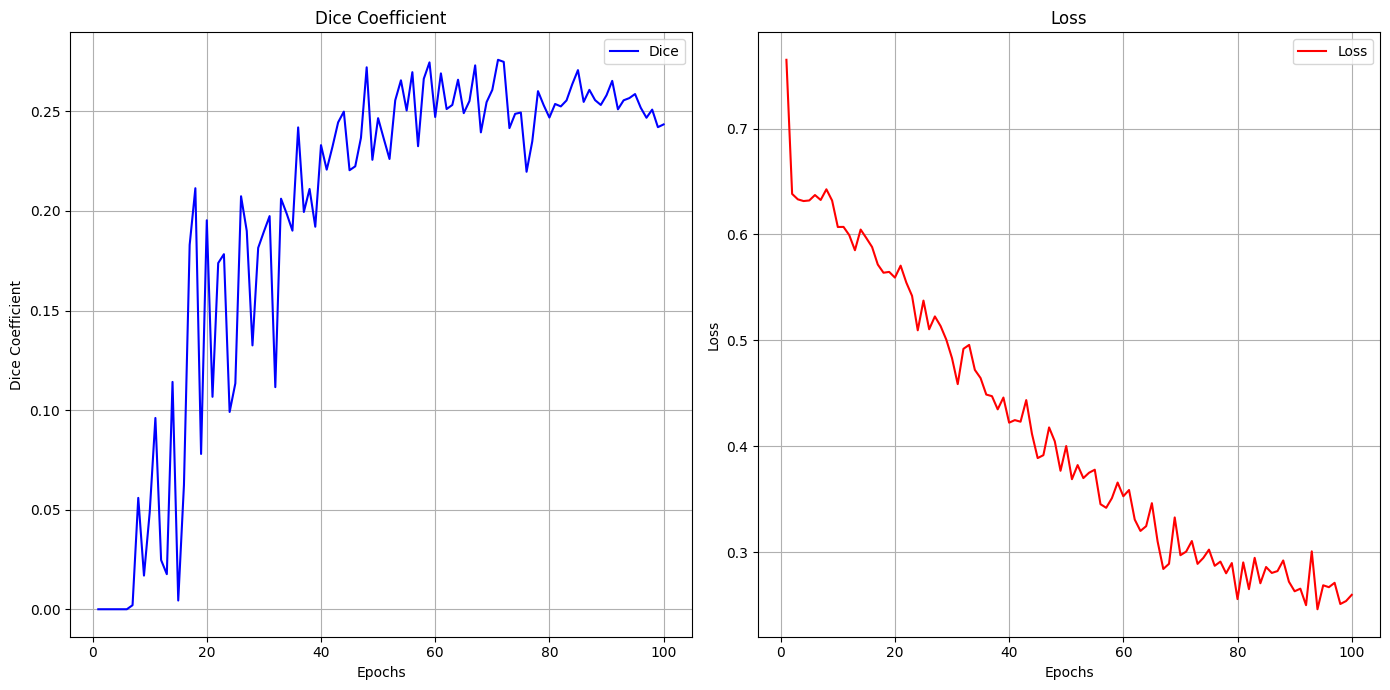

In [ ]:
epochs = np.arange(1, len(model_result["dice_tumor"]) + 1)
plt.figure(figsize=(14, 7))

# dice
plt.subplot(1, 2, 1)
plt.plot(epochs, model_result["dice_tumor"], label="Dice", color='blue')
plt.title("Dice Coefficient")
plt.xlabel("Epochs")
plt.ylabel("Dice Coefficient")
plt.legend()
plt.grid()

# loss
plt.subplot(1, 2, 2)
plt.plot(epochs, model_result["loss"], label="Loss", color='red')
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

## Result using tversky + focal loss

In [ ]:
model_result = load_metrics("/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT_tumor_1.json")

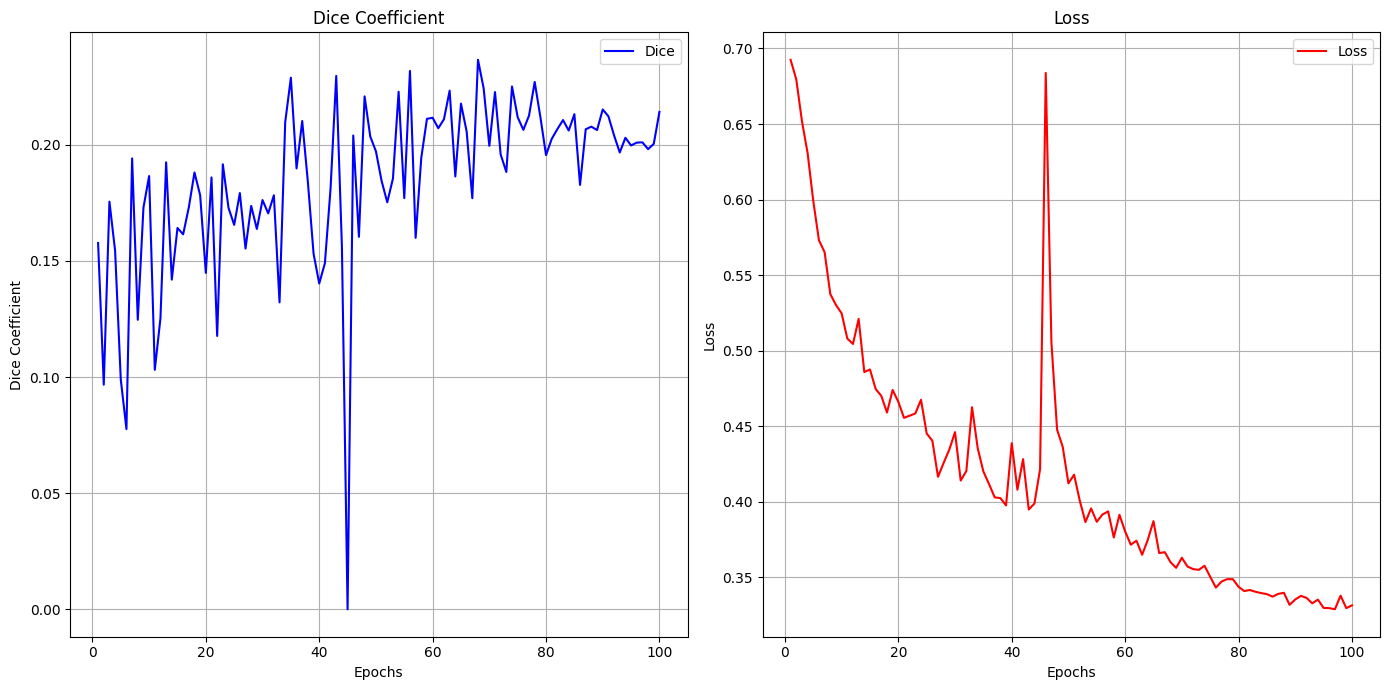

In [ ]:
epochs = np.arange(1, len(model_result["dice_tumor"]) + 1)
plt.figure(figsize=(14, 7))

# dice
plt.subplot(1, 2, 1)
plt.plot(epochs, model_result["dice_tumor"], label="Dice", color='blue')
plt.title("Dice Coefficient")
plt.xlabel("Epochs")
plt.ylabel("Dice Coefficient")
plt.legend()
plt.grid()

# loss
plt.subplot(1, 2, 2)
plt.plot(epochs, model_result["loss"], label="Loss", color='red')
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

##Result using tversky + BCE Loss

In [ ]:
model_result = load_metrics("/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT_tumor_2.json")

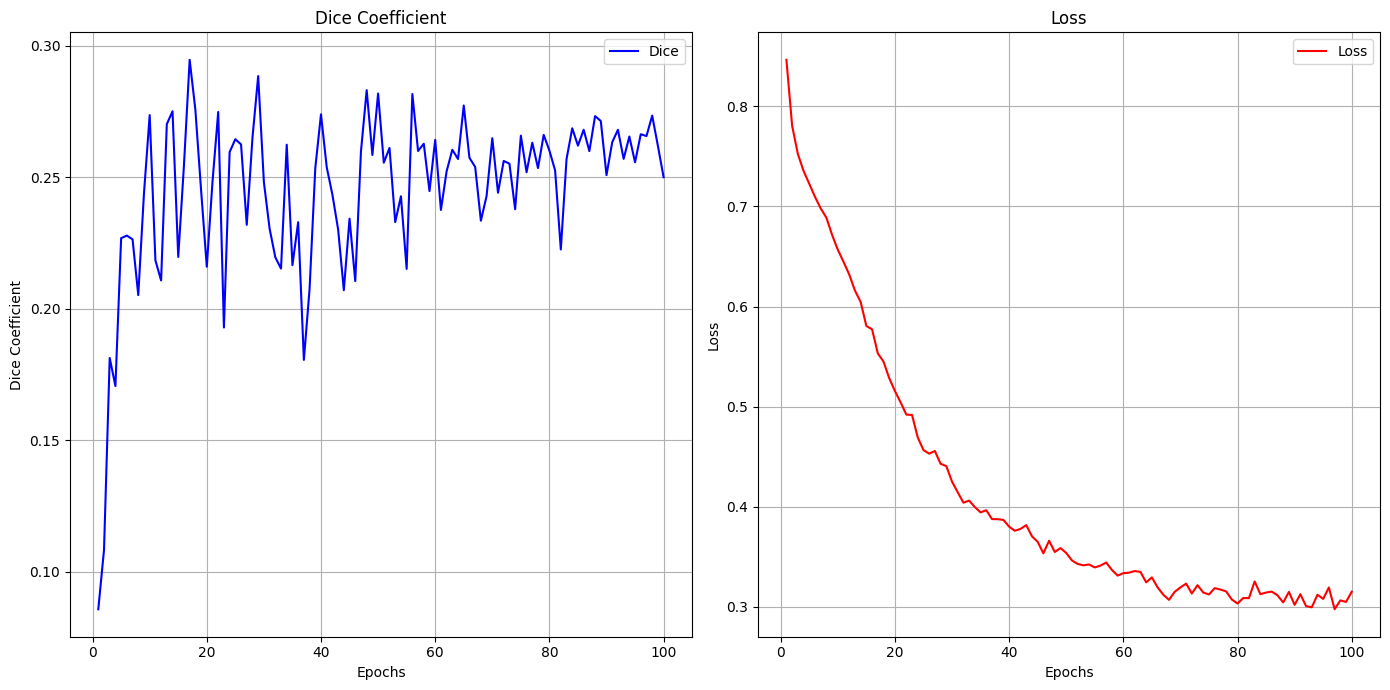

In [ ]:
epochs = np.arange(1, len(model_result["dice_tumor"]) + 1)
plt.figure(figsize=(14, 7))

# dice
plt.subplot(1, 2, 1)
plt.plot(epochs, model_result["dice_tumor"], label="Dice", color='blue')
plt.title("Dice Coefficient")
plt.xlabel("Epochs")
plt.ylabel("Dice Coefficient")
plt.legend()
plt.grid()

# loss
plt.subplot(1, 2, 2)
plt.plot(epochs, model_result["loss"], label="Loss", color='red')
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()